In [2]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import os
import re
import datetime
import itertools
import gc

In [3]:
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (12,6)

## Data Loading

In [33]:
data_dir = 'data/oil_gas_train'
directory = os.fsencode(data_dir)
rows_27 = pd.DataFrame([])

num_files = 0
row_success = 0
col_success = 0
date_success = 0
comp_names = []
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if re.search("^[A-Z]", filename) is not None:
        comp_names.append(filename)
        num_files+=1
        comp = pd.read_excel(data_dir+'/'+filename)
        if ('INCOME STATEMENT' in list(comp.loc[27,:])) and ('DDM Terminal Value' in list(comp.loc[409,:])):
            row_success+=1
        if comp.iloc[:, 7].isna().all() and comp.iloc[27, 8] == 'INCOME STATEMENT' \
            and comp.iloc[123,8] == 'BALANCE SHEET' and comp.iloc[261,8] == 'CASH FLOW STATEMENT' \
            and comp.iloc[324,8] == 'CHANGES TO SHAREHOLDER EQUITY' and comp.iloc[346,8] == 'Ratios' \
            and comp.iloc[362,8] == 'Valuation':
            col_success+=1
        if (comp.iloc[27,9:] == comp.iloc[123,9:]).all() and (comp.iloc[27,9:] == comp.iloc[324,9:]).all() \
            and (comp.iloc[27,9:] == comp.iloc[261,9:]).all() and (comp.iloc[27,9:] == comp.iloc[346,9:]).all() \
            and (comp.iloc[27,9:] == comp.iloc[362,9:]).all():
            date_success+=1
        
        rows_27 = pd.concat([rows_27, comp.iloc[27,:]], axis=1)

In [4]:
# let's store indexes of all of the statements
IS_index = 27
BS_index = 123
CFS_index = 261
CTSE_index = 324
R_index = 346
V_index = 362

Firstly, we need to dermine a pattern of all files

In [5]:
num_files, row_success, col_success, date_success

(53, 53, 53, 53)

From the code above we see that:

* 'INCOME STATEMENT' line is always 27th, 'DDM Terminal Value' line is always 409. These are the row boundaries of all of our statements

* Moreover, we see that all statements have the same position. These should help us to parse all of the files

* Finally, all of the date ranges are the same

Let's explore date range

In [6]:
rows_27

27                    27                    27  \
Unnamed: 0   BEST_PERIOD_END_DATE  BEST_PERIOD_END_DATE  BEST_PERIOD_END_DATE   
Unnamed: 1                    NaN                   NaN                   NaN   
Unnamed: 2                    NaN                   NaN                   NaN   
Unnamed: 3                    NaN                   NaN                   NaN   
Unnamed: 4                     21                    21                    21   
Unnamed: 5                    NaN                   NaN                   NaN   
Unnamed: 6                    NaN                   NaN                   NaN   
Unnamed: 7                    NaN                   NaN                   NaN   
Unnamed: 8       INCOME STATEMENT      INCOME STATEMENT      INCOME STATEMENT   
Unnamed: 9    2011-03-31 00:00:00   2011-03-31 00:00:00   2011-03-31 00:00:00   
Unnamed: 10   2011-06-30 00:00:00   2011-06-30 00:00:00   2011-06-30 00:00:00   
Unnamed: 11   2011-09-30 00:00:00   2011-09-30 00:00:00   2011-09-30 00:00:00   
Unnamed: 12   2011-12-31 00:00:00   2011-12-31 00:00:00   2011-12-31 00:00:00   
Unnamed: 13   2012-03-31 00:00:00   2012-03-31 00:00:00   2012-03-31 00:00:00   
Unnamed: 14   2012-06-30 00:00:00   2012-06-30 00:00:00   2012-06-30 00:00:00   
Unnamed: 15   2012-09-30 00:00:00   2012-09-30 00:00:00   2012-09-30 00:00:00   
Unnamed: 16   2012-12-31 00:00:00   2012-12-31 00:00:00   2012-12-31 00:00:00   
Unnamed: 17   2013-03-31 00:00:00   2013-03-31 00:00:00   2013-03-31 00:00:00   
Unnamed: 18   2013-06-30 00:00:00   2013-06-30 00:00:00   2013-06-30 00:00:00   
Unnamed: 19   2013-09-30 00:00:00   2013-09-30 00:00:00   2013-09-30 00:00:00   
Unnamed: 20   2013-12-31 00:00:00   2013-12-31 00:00:00   2013-12-31 00:00:00   
Unnamed: 21   2014-03-31 00:00:00   2014-03-31 00:00:00   2014-03-31 00:00:00   
Unnamed: 22   2014-06-30 00:00:00   2014-06-30 00:00:00   2014-06-30 00:00:00   
Unnamed: 23   2014-09-30 00:00:00   2014-09-30 00:00:00   2014-09-30 00:00:00   
Unnamed: 24   2014-12-31 00:00:00   2014-12-31 00:00:00   2014-12-31 00:00:00   
Unnamed: 25   2015-03-31 00:00:00   2015-03-31 00:00:00   2015-03-31 00:00:00   
Unnamed: 26   2015-06-30 00:00:00   2015-06-30 00:00:00   2015-06-30 00:00:00   
Unnamed: 27   2015-09-30 00:00:00   2015-09-30 00:00:00   2015-09-30 00:00:00   
Unnamed: 28   2015-12-31 00:00:00   2015-12-31 00:00:00   2015-12-31 00:00:00   
Unnamed: 29   2016-03-31 00:00:00   2016-03-31 00:00:00   2016-03-31 00:00:00   
Unnamed: 30   2016-06-30 00:00:00   2016-06-30 00:00:00   2016-06-30 00:00:00   
Unnamed: 31   2016-09-30 00:00:00   2016-09-30 00:00:00   2016-09-30 00:00:00   
Unnamed: 32   2016-12-31 00:00:00   2016-12-31 00:00:00   2016-12-31 00:00:00   
Unnamed: 33   2017-03-31 00:00:00   2017-03-31 00:00:00   2017-03-31 00:00:00   
Unnamed: 34   2017-06-30 00:00:00   2017-06-30 00:00:00   2017-06-30 00:00:00   
Unnamed: 35   2017-09-30 00:00:00   2017-09-30 00:00:00   2017-09-30 00:00:00   
Unnamed: 36   2017-12-31 00:00:00   2017-12-31 00:00:00   2017-12-31 00:00:00   
Unnamed: 37   2018-03-31 00:00:00   2018-03-31 00:00:00   2018-03-31 00:00:00   
Unnamed: 38   2018-06-30 00:00:00   2018-06-30 00:00:00   2018-06-30 00:00:00   
Unnamed: 39   2018-09-30 00:00:00   2018-09-30 00:00:00   2018-09-30 00:00:00   
Unnamed: 40   2018-12-31 00:00:00   2018-12-31 00:00:00   2018-12-31 00:00:00   
Unnamed: 41   2019-03-31 00:00:00   2019-03-31 00:00:00   2019-03-31 00:00:00   
Unnamed: 42   2019-06-30 00:00:00   2019-06-30 00:00:00   2019-06-30 00:00:00   
Unnamed: 43   2019-09-30 00:00:00   2019-09-30 00:00:00   2019-09-30 00:00:00   
Unnamed: 44   2019-12-31 00:00:00   2019-12-31 00:00:00   2019-12-31 00:00:00   
Unnamed: 45   2020-03-31 00:00:00   2020-03-31 00:00:00   2020-03-31 00:00:00   
Unnamed: 46   2020-06-30 00:00:00   2020-06-30 00:00:00   2020-06-30 00:00:00   
Unnamed: 47                   NaN                   NaN                   NaN   
Unnamed: 48                   NaN                   NaN       

We see that the last statement for any company is at '2020-06-30', but date ranges are different.

In [7]:
# minimal date
rows_27.iloc[9,:].min()

datetime.datetime(2009, 6, 30, 0, 0)

Let's read our files again and store them

In [8]:
# let's store indexes of all of the statements
IS_index = 27
BS_index = 123
CFS_index = 261
CTSE_index = 324
R_index = 346
V_index = 362

In [9]:
statement_index = ['INCOME STATEMENT']*(BS_index-IS_index)+ \
['BALANCE SHEET']*(CFS_index-BS_index)+['CASH FLOW STATEMENT']*(CTSE_index-CFS_index)+\
['CHANGES TO SHAREHOLDER EQUITY']*(R_index-CTSE_index)+\
['Ratio']*(V_index-R_index)+['Valuation']*(comp.index[-1]+1-V_index)

In [58]:
comp_data = {}
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if re.search("^[A-Z]", filename) is not None:
        comp = pd.read_excel(data_dir+'/'+filename)
        comp = comp.iloc[27:, 8:]
        # here's the date range
        cols = comp.iloc[0, 1:].values
        comp['STATEMENT'] = statement_index
        comp.drop(index=[IS_index, BS_index, CFS_index, CTSE_index, R_index, V_index], inplace=True)
        comp.index = pd.MultiIndex.from_arrays([comp['STATEMENT'], comp['Unnamed: 8']], names=['STATEMENT','METRIC'])
        comp.drop(columns=['Unnamed: 8', 'STATEMENT'], inplace=True)
        comp.columns = cols
        comp_data[filename.split('.')[0]] = comp

#### Issue with REI report

In [59]:
dups = pd.Series(comp_data['REI'].columns).value_counts()
dups[dups>1]

2011-09-30    2
2011-12-31    2
2011-06-30    2
dtype: int64

For some reason the data for REI has duplications, we drop less informative.

In [60]:
comp_data['REI'].columns

DatetimeIndex(['2011-03-31', '2011-06-30', '2011-09-30', '2011-12-31',
               '2011-06-30', '2011-09-30', '2011-12-31', '2012-03-31',
               '2012-06-30', '2013-06-30', '2013-09-30', '2013-12-31',
               '2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31',
               '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
               '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31',
               '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31',
               '2018-03-31', '2018-06-30', '2018-09-30', '2018-12-31',
               '2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31',
               '2020-03-31', '2020-06-30'],
              dtype='datetime64[ns]', freq=None)

In [61]:
df_temp = comp_data['REI'][datetime.datetime(2011, 6, 30, 0, 0)]
# number of different non-na values in each of the columns
(~df_temp[~(df_temp.iloc[:,0] == df_temp.iloc[:,0])].isna()).sum()

2011-06-30     0
2011-06-30    26
dtype: int64

In [62]:
df_temp = comp_data['REI'][datetime.datetime(2011, 9, 30, 0, 0)]
(~df_temp[~(df_temp.iloc[:,0] == df_temp.iloc[:,0])].isna()).sum()

2011-09-30     0
2011-09-30    23
dtype: int64

In [63]:
df_temp = comp_data['REI'][datetime.datetime(2011, 12, 31, 0, 0)]
(~df_temp[~(df_temp.iloc[:,0] == df_temp.iloc[:,0])].isna()).sum()

2011-12-31     0
2011-12-31    23
dtype: int64

In [64]:
mask = [True]*comp_data['REI'].shape[1]
mask[1] = False
mask[2] = False
mask[3] = False
comp_data['REI'] = comp_data['REI'].iloc[:,mask]

In [65]:
dups = pd.Series(comp_data['REI'].columns).value_counts()
dups[dups>1]

Series([], dtype: int64)

That's better!

### Combining the data together

Firstly, we drop duplications in metrics

In [66]:
for k in comp_data.keys():
    comp_data[k] = comp_data[k][~comp_data[k].index.duplicated()]

In [131]:
data = pd.concat(comp_data, names=['Company', 'Statement', 'Metric'])

In [132]:
data

2009-06-30  \
Company Statement        Metric                                        
CDEV    INCOME STATEMENT Revenue                                 NaN   
                         Consensus:                              NaN   
                         % Surprise | % Est. vs Consensus        NaN   
                         Revenue Growth (YoY)                    NaN   
                         Cost of Revenue                         NaN   
...                                                              ...   
MCF     Valuation        Dividends Per Share (fwd only)          NaN   
                         Discounted Value (Base)                 NaN   
                         Discounted Value (Bull)                 NaN   
                         Discounted Value (Bear)                 NaN   
                         DDM Terminal Value                      NaN   

                                                          2009-09-30  \
Company Statement        Metric                                        
CDEV    INCOME STATEMENT Revenue                                 NaN   
                         Consensus:                              NaN   
                         % Surprise | % Est. vs Consensus        NaN   
                         Revenue Growth (YoY)                    NaN   
                         Cost of Revenue                         NaN   
...                                                              ...   
MCF     Valuation        Dividends Per Share (fwd only)          NaN   
                         Discounted Value (Base)                 NaN   
                         Discounted Value (Bull)                 NaN   
                         Discounted Value (Bear)                 NaN   
                         DDM Terminal Value                      NaN   

                                                          2009-12-31  \
Company Statement        Metric                                        
CDEV    INCOME STATEMENT Revenue                                 NaN   
                         Consensus:                              NaN   
                         % Surprise | % Est. vs Consensus        NaN   
                         Revenue Growth (YoY)                    NaN   
                         Cost of Revenue                         NaN   
...                                                              ...   
MCF     Valuation        Dividends Per Share (fwd only)          NaN   
                         Discounted Value (Base)                 NaN   
                         Discounted Value (Bull)                 NaN   
                         Discounted Value (Bear)                 NaN   
                         DDM Terminal Value                      NaN   

                                                          2010-03-31  \
Company Statement        Metric                                        
CDEV    INCOME STATEMENT Revenue                                 NaN   
                         Consensus:                              NaN   
                         % Surprise | % Est. vs Consensus        NaN   
                         Revenue Growth (YoY)                    NaN   
                         Cost of Revenue                         NaN   
...                                                              ...   
MCF     Valuation        Dividends Per Share (fwd only)          NaN   
                         Discounted Value (Base)                 NaN   
                         Discounted Value (Bull)                 NaN   
                         Discounted Value (Bear)                 NaN   
                         DDM Terminal Value                      NaN   

                                                          2010-06-30  \
Company Statement        Metric                                        
CDEV    INCOME STATEMENT Revenue                                 NaN   
                         Consensus:                              NaN   
                      

In [133]:
data.index

MultiIndex([('CDEV', 'INCOME STATEMENT',                          'Revenue'),
            ('CDEV', 'INCOME STATEMENT',                       'Consensus:'),
            ('CDEV', 'INCOME STATEMENT', '% Surprise | % Est. vs Consensus'),
            ('CDEV', 'INCOME STATEMENT',             'Revenue Growth (YoY)'),
            ('CDEV', 'INCOME STATEMENT',                  'Cost of Revenue'),
            ('CDEV', 'INCOME STATEMENT',                     'Gross Profit'),
            ('CDEV', 'INCOME STATEMENT',                     'Gross margin'),
            ('CDEV', 'INCOME STATEMENT',           'Other Operating Income'),
            ('CDEV', 'INCOME STATEMENT',               'Operating Expenses'),
            ('CDEV', 'INCOME STATEMENT',         'Selling, General & Admin'),
            ...
            ( 'MCF',        'Valuation',                              'ROE'),
            ( 'MCF',        'Valuation',                         'ROE - rE'),
            ( 'MCF',        'Valuation',        

In [134]:
data.index.levels[2]

Index(['% Surprise | % Est. vs Consensus', '(Inc) Dec in Accts Receiv',
       '(Inc) Dec in Inventories', '-Dividend', '-Net Share Repurchases',
       'A = L + SE', 'ARD Loss/(Recovery) on Impair of Intangible Assets',
       'Accounts & Notes Receivable', 'Accounts Payable',
       'Accounts Receivable',
       ...
       'Total Long-Term Assets', 'Total Noncurrent Liabilities',
       'Total Operating Lease Commitment', 'Treasury Stock',
       'Unbilled Revenue', 'WACC Discount Factor', 'Work In Process',
       'XO & Accounting Changes', 'change in ROE-rE',
       'year + weight + convention'],
      dtype='object', name='Metric', length=310)

In [135]:
data.columns

DatetimeIndex(['2009-06-30', '2009-09-30', '2009-12-31', '2010-03-31',
               '2010-06-30', '2010-09-30', '2010-12-31', '2011-03-31',
               '2011-06-30', '2011-09-30', '2011-12-31', '2012-03-31',
               '2012-06-30', '2012-09-30', '2012-12-31', '2013-03-31',
               '2013-06-30', '2013-09-30', '2013-12-31', '2014-03-31',
               '2014-06-30', '2014-09-30', '2014-12-31', '2015-03-31',
               '2015-06-30', '2015-09-30', '2015-12-31', '2016-03-31',
               '2016-06-30', '2016-09-30', '2016-12-31', '2017-03-31',
               '2017-06-30', '2017-09-30', '2017-12-31', '2018-03-31',
               '2018-06-30', '2018-09-30', '2018-12-31', '2019-03-31',
               '2019-06-30', '2019-09-30', '2019-12-31', '2020-03-31',
               '2020-06-30'],
              dtype='datetime64[ns]', freq='Q-DEC')

Great! Finally, we've gotten what we want.

## EDA

Index slicing (for me to know)

In [136]:
idx = pd.IndexSlice

In [137]:
data.loc[idx[:,'INCOME STATEMENT',:]]

2009-06-30  \
Company Statement        Metric                                        
CDEV    INCOME STATEMENT Revenue                                 NaN   
                         Consensus:                              NaN   
                         % Surprise | % Est. vs Consensus        NaN   
                         Revenue Growth (YoY)                    NaN   
                         Cost of Revenue                         NaN   
...                                                              ...   
MCF     INCOME STATEMENT ROE                                     NaN   
                         Book Value Per Share                    NaN   
                         Cash Flow Per Share                     NaN   
                         Sales Per Share                         NaN   
                         Price                                   NaN   

                                                          2009-09-30  \
Company Statement        Metric                                        
CDEV    INCOME STATEMENT Revenue                                 NaN   
                         Consensus:                              NaN   
                         % Surprise | % Est. vs Consensus        NaN   
                         Revenue Growth (YoY)                    NaN   
                         Cost of Revenue                         NaN   
...                                                              ...   
MCF     INCOME STATEMENT ROE                                     NaN   
                         Book Value Per Share                    NaN   
                         Cash Flow Per Share                     NaN   
                         Sales Per Share                         NaN   
                         Price                                   NaN   

                                                          2009-12-31  \
Company Statement        Metric                                        
CDEV    INCOME STATEMENT Revenue                                 NaN   
                         Consensus:                              NaN   
                         % Surprise | % Est. vs Consensus        NaN   
                         Revenue Growth (YoY)                    NaN   
                         Cost of Revenue                         NaN   
...                                                              ...   
MCF     INCOME STATEMENT ROE                                     NaN   
                         Book Value Per Share                    NaN   
                         Cash Flow Per Share                     NaN   
                         Sales Per Share                         NaN   
                         Price                                   NaN   

                                                          2010-03-31  \
Company Statement        Metric                                        
CDEV    INCOME STATEMENT Revenue                                 NaN   
                         Consensus:                              NaN   
                         % Surprise | % Est. vs Consensus        NaN   
                         Revenue Growth (YoY)                    NaN   
                         Cost of Revenue                         NaN   
...                                                              ...   
MCF     INCOME STATEMENT ROE                                     NaN   
                         Book Value Per Share                    NaN   
                         Cash Flow Per Share                     NaN   
                         Sales Per Share                         NaN   
                         Price                                   NaN   

                                                          2010-06-30  \
Company Statement        Metric                                        
CDEV    INCOME STATEMENT Revenue                                 NaN   
                         Consensus:                              NaN   
                      

In [138]:
data.loc[idx[:,:,'Revenue']]

2009-06-30 2009-09-30 2009-12-31 2010-03-31  \
Company Statement        Metric                                                
CDEV    INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
COG     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
CNX     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
FANG    INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
AR      INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
TALO    INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
HES     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
MTDR    INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
GDP     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
WLL     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
CRK     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
LPI     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
SBOW    INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
RRC     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
CLR     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
APA     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
EOG     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
CRBO    INCOME STATEMENT Revenue    0.00028    0.00026   0.000202   0.100144   
VNOM    INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
DVN     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
EQT     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
MUR     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
CHK     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
SD      INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
OVV     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
MGY     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
ESTE    INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
SWN     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
AMPY    INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
NOG     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
MRO     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
DEN     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
BSM     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
LONE    INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
XOG     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
CRC     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
BCEI    INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
MNRL    INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
BRY     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
SM      INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
PVAC    INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
PXD     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
COP     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
PDCE    INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
WTI     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
OAS     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
EGY     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
XEC     INCOME STATEMENT Revenue        NaN        NaN        NaN        NaN   
TPL     INCOME STATEMENT Revenue 

### First look: NA values

We need to find less informative features and delete them

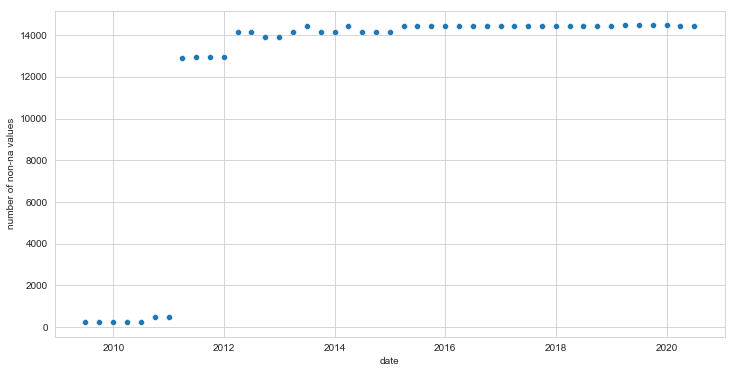

In [139]:
plot_data = (~data.isna()).sum()
ax = sns.scatterplot(x=plot_data.index, y=plot_data.values)
ax.set(xlabel='date', ylabel='number of non-na values')
plt.show()

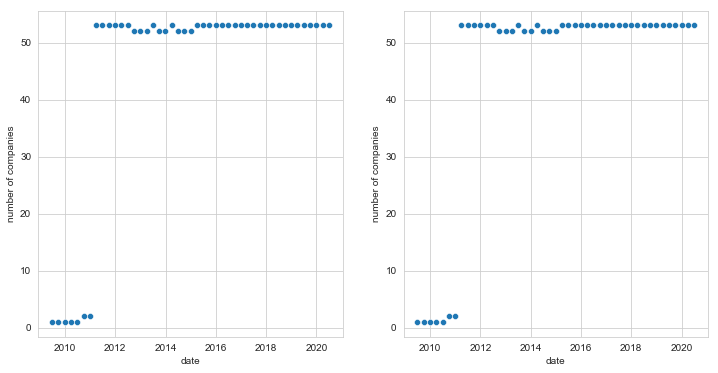

In [140]:
plot_data1 = (~data.loc[idx[:,:,'Revenue']].isna()).sum()
plot_data2 = (~data.loc[idx[:,:,'Operating Income']].isna()).sum()
fig, axs = plt.subplots(ncols=2)
sns.scatterplot(x=plot_data1.index, y=plot_data1.values, ax=axs[0])
axs[0].set(xlabel='date')
axs[0].set(ylabel='number of companies')
sns.scatterplot(x=plot_data2.index, y=plot_data2.values, ax=axs[1])
axs[1].set(xlabel='date')
axs[1].set(ylabel='number of companies')
plt.show()

We see that our target values are determined after 2011-03-31 predominantly. 

Now, let's see what we have with other features. For each company we have the following number of features.

In [141]:
len(data.loc[idx['CDEV',:,:]].index)-2

319

The number of companies is:

In [142]:
len(data.index.levels[0])

53

Firstly, we drop indexes with nan namings

In [143]:
data.drop(np.nan, level=2, inplace=True)

Of course, not all of values are given. We could definitely dispose of those that almost have not values.

In [144]:
# here for each of the features we have number of companies with non-na values
na_stat = (~data.isna()).groupby(['Statement','Metric']).sum()
na_stat

2009-06-30  2009-09-30  2009-12-31  \
Statement     Metric                                                            
BALANCE SHEET A = L + SE                            0           0           0   
              Accounts & Notes Receivable           1           1           1   
              Accounts Payable                      1           1           1   
              Accounts Receivable                   1           1           1   
              Accruals & Other                      0           0           0   
...                                               ...         ...         ...   
Valuation     Terminal Value of RI (Bear)           0           0           0   
              Terminal Value of RI (Bull)           0           0           0   
              WACC Discount Factor                  0           0           0   
              change in ROE-rE                      0           0           0   
              year + weight + convention            0           0           0   

                                           2010-03-31  2010-06-30  2010-09-30  \
Statement     Metric                                                            
BALANCE SHEET A = L + SE                            0           0           0   
              Accounts & Notes Receivable           1           1           2   
              Accounts Payable                      1           1           2   
              Accounts Receivable                   1           1           2   
              Accruals & Other                      0           0           0   
...                                               ...         ...         ...   
Valuation     Terminal Value of RI (Bear)           0           0           0   
              Terminal Value of RI (Bull)           0           0           0   
              WACC Discount Factor                  0           0           0   
              change in ROE-rE                      0           0           0   
              year + weight + convention            0           0           0   

                                           2010-12-31  2011-03-31  2011-06-30  \
Statement     Metric                                                            
BALANCE SHEET A = L + SE                            0           1           3   
              Accounts & Notes Receivable           2          53          53   
              Accounts Payable                      2          53          53   
              Accounts Receivable                   2          53          53   
              Accruals & Other                      0           0           0   
...                                               ...         ...         ...   
Valuation     Terminal Value of RI (Bear)           0           0           0   
              Terminal Value of RI (Bull)           0           0           0   
              WACC Discount Factor                  0           0           0   
              change in ROE-rE                      0           0           0   
              year + weight + convention            0           0           0   

                                           2011-09-30  ...  2018-03-31  \
Statement     Metric                                   ...               
BALANCE SHEET A = L + SE                            4  ...          53   
              Accounts & Notes Receivable          53  ...          53   
              Accounts Payable                     53  ...          53   
              Accounts Receivable                  53  ...          53   
              Accruals & Other                      0  ...          53   
...                                               ...  ...         ...   
Valuation     Terminal Value of RI (Bear)           0  ...           0   
              Terminal Value of RI (Bull)           0  ...           0   
              WACC Discount Factor                  0  ...           0   
              change in ROE-rE                      0  ...         

In [145]:
# each feature in overall
na_stat.sum(axis=1)

Statement      Metric                     
BALANCE SHEET  A = L + SE                     1806
               Accounts & Notes Receivable    2015
               Accounts Payable               2015
               Accounts Receivable            2015
               Accruals & Other               1594
                                              ... 
Valuation      Terminal Value of RI (Bear)       0
               Terminal Value of RI (Bull)       0
               WACC Discount Factor              0
               change in ROE-rE                  0
               year + weight + convention        0
Length: 315, dtype: int64

In [146]:
# number of possible non-na values for each feature is
max_values = data.shape[1]*len(data.index.levels[0])
max_values

2385

That is, we can drop those metrics that have more then, for example, 85% na-s

In [147]:
drop_index = na_stat[na_stat.sum(axis=1)<=int(max_values*0.15)].sum(axis=1).index.to_numpy()
len(drop_index)

42

We also drop features with small amount of unique values:

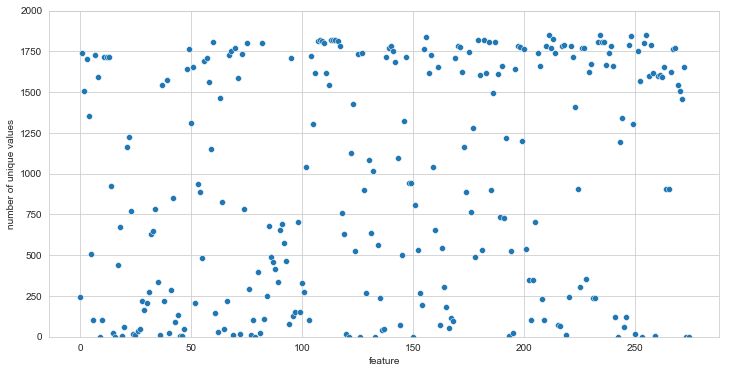

In [148]:
un_stat = data.stack(0).groupby(['Statement','Metric']).nunique()
ax = sns.scatterplot(x=range(len(un_stat.index)), y=un_stat.values)
ax.set_xlabel('feature')
ax.set_ylabel('number of unique values')
ax.set_ylim(0,2000)
plt.show()

In [149]:
# let's drop those that have less than 10 unique values
drop_index = np.append(drop_index, un_stat[un_stat<10].index.to_numpy())
len(drop_index)

58

In [150]:
drop_index

array([('BALANCE SHEET', 'NI QQQQ = Y'),
       ('BALANCE SHEET', 'Operating Leases'),
       ('BALANCE SHEET', 'Reference Items'),
       ('INCOME STATEMENT', 'Dep % of D&A'), ('Valuation', '-Dividend'),
       ('Valuation', '-Net Share Repurchases'), ('Valuation', 'Bear'),
       ('Valuation', 'Beginning Book Value'), ('Valuation', 'Bull'),
       ('Valuation', 'DDM Terminal Value'),
       ('Valuation', 'Discounted Residual Income'),
       ('Valuation', 'Discounted Residual Income (Bear)'),
       ('Valuation', 'Discounted Residual Income (Bull)'),
       ('Valuation', 'Discounted Value (Base)'),
       ('Valuation', 'Discounted Value (Bear)'),
       ('Valuation', 'Discounted Value (Bull)'),
       ('Valuation', 'Div Ex date:'),
       ('Valuation', 'Dividend Discount Model'),
       ('Valuation', 'Dividends Per Share (fwd only)'),
       ('Valuation', 'Ending Book Value'), ('Valuation', 'Equity Charge'),
       ('Valuation', 'Equity Discount Factor'),
       ('Valuation', 'Forwar

In [161]:
temp = data.unstack(0)
temp = temp[~temp.index.isin(drop_index)]
data = temp.stack(0).unstack([0,1]).T

In [162]:
data

2009-06-30  \
Company Statement     Metric                                            
AMPY    BALANCE SHEET A = L + SE                                  NaN   
                      Accounts & Notes Receivable                 NaN   
                      Accounts Payable                            NaN   
                      Accounts Receivable                         NaN   
                      Accruals & Other                            NaN   
...                                                               ...   
XOG     Ratio         EBITDAR (8x Rental Expense)                 NaN   
                      FCF / DEBT                                  NaN   
                      Gross Leverage (Total Debt / EBITDA)        NaN   
                      Net Leverage (Net Debt / EBITDA)            NaN   
                      Total Liabilities / Tangible Assets         NaN   

                                                           2009-09-30  \
Company Statement     Metric                                            
AMPY    BALANCE SHEET A = L + SE                                  NaN   
                      Accounts & Notes Receivable                 NaN   
                      Accounts Payable                            NaN   
                      Accounts Receivable                         NaN   
                      Accruals & Other                            NaN   
...                                                               ...   
XOG     Ratio         EBITDAR (8x Rental Expense)                 NaN   
                      FCF / DEBT                                  NaN   
                      Gross Leverage (Total Debt / EBITDA)        NaN   
                      Net Leverage (Net Debt / EBITDA)            NaN   
                      Total Liabilities / Tangible Assets         NaN   

                                                           2009-12-31  \
Company Statement     Metric                                            
AMPY    BALANCE SHEET A = L + SE                                  NaN   
                      Accounts & Notes Receivable                 NaN   
                      Accounts Payable                            NaN   
                      Accounts Receivable                         NaN   
                      Accruals & Other                            NaN   
...                                                               ...   
XOG     Ratio         EBITDAR (8x Rental Expense)                 NaN   
                      FCF / DEBT                                  NaN   
                      Gross Leverage (Total Debt / EBITDA)        NaN   
                      Net Leverage (Net Debt / EBITDA)            NaN   
                      Total Liabilities / Tangible Assets         NaN   

                                                           2010-03-31  \
Company Statement     Metric                                            
AMPY    BALANCE SHEET A = L + SE                                  NaN   
                      Accounts & Notes Receivable                 NaN   
                      Accounts Payable                            NaN   
                      Accounts Receivable                         NaN   
                      Accruals & Other                            NaN   
...                                                               ...   
XOG     Ratio         EBITDAR (8x Rental Expense)                 NaN   
                      FCF / DEBT                                  NaN   
                      Gross Leverage (Total Debt / EBITDA)        NaN   
                      Net Leverage (Net Debt / EBITDA)            NaN   
                      Total Liabilities / Tangible Assets         NaN   

                                                           2010-06-30  \
Company Statement     Metric                                            
AMPY    BALANCE SHEET A = L + SE                                  NaN   
                      Accounts & Notes R

Let's save this dataframe

In [380]:
data.to_excel('data/data1.xlsx')

### Transforming the data

In [342]:
data_tmp = pd.DataFrame([])
for cmp in data.index.levels[0]:
    ttt = data.loc[idx[cmp,:,:]]
    ttt.index=ttt.index.droplevel(0)
    ttt = ttt.T
    ttt.columns = ttt.columns.tolist()
    ttt['date'] = ttt.index
    ttt['company'] = cmp
    ttt = ttt[ttt.columns[-2:].tolist() + ttt.columns[:-2].tolist()]
    ttt.reset_index(drop=True, inplace=True)
    data_tmp = pd.concat([data_tmp, ttt],axis=0)
data_tmp = data_tmp.rename(columns = {x: x[0] + '///' + x[1] for x in data_tmp.columns[2:]})
data_tmp.reset_index(drop=True, inplace=True)

/Users/danilculkov/opt/anaconda3/envs/practice/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


We convert their types

In [343]:
for c in data_tmp.columns[2:]:
    #print(c)
    try:
        data_tmp[c] = pd.to_numeric(data_tmp[c])
    except:
        pass

Let's consider remaining object types

In [324]:
obj_comps = data_tmp.columns[data_tmp.dtypes=='object'].tolist()
obj_comps.remove('company')

In [350]:
pd.to_numeric(data_tmp[obj_comps[0]])

ValueError: Unable to parse string "#N/A Field Not Applicable" at position 1177

In [354]:
data_tmp[obj_comps[0]][data_tmp[obj_comps[0]]=="#N/A Field Not Applicable"] = np.nan

/Users/danilculkov/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [356]:
data_tmp[obj_comps[0]] = pd.to_numeric(data_tmp[obj_comps[0]])

In [359]:
data_tmp[obj_comps[1]].unique()

array([nan, 0, 29.529374008834985, 27.533176930224496, 27.390731764674044,
       30.151220834996618, 38.273542412728666, 41.23640185617809,
       51.89915928296857, 73.47125163001962, 79.37732290787703,
       65.72223462407496, 69.8217082505718, 71.8208524705385,
       57.81407198489463, 57.39852505366813, 54.28143187924339,
       43.92615953395148, 39.53688367409338, 24.397418527210384,
       18.309606865719633, 15.478386402847867, 15.764259114400845,
       15.071680895690022, 15.677809634618502, 14.902711457933622,
       19.019867932567756, 14.94495381737272, 16.19355937195635,
       13.119690937422776, 12.183482366598072, 10.96926012783697,
       12.685478777606912, 16.72895671833564, 15.862497159608052,
       15.281910312433448, 7.48868618614555, 'n.a.', 566, 418,
       34.14631899115844, 39.4618891850449, 42.61971253722135,
       52.7850095554014, 48.098823488518086, 40.26869025493556,
       92.65723736813024, 158.0368754855822, 74.82633902988346,
       90.698712903

In [361]:
data_tmp[obj_comps[1]][data_tmp[obj_comps[1]]=="n.a."] = np.nan

/Users/danilculkov/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [363]:
data_tmp[obj_comps[1]] = pd.to_numeric(data_tmp[obj_comps[1]])

In [365]:
data_tmp[obj_comps[2]][data_tmp[obj_comps[2]]=="n.a."] = np.nan

/Users/danilculkov/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [367]:
data_tmp[obj_comps[2]] = pd.to_numeric(data_tmp[obj_comps[2]])

In [369]:
data_tmp[obj_comps[3]][data_tmp[obj_comps[3]]=="n.a."] = np.nan

/Users/danilculkov/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [370]:
data_tmp[obj_comps[3]] = pd.to_numeric(data_tmp[obj_comps[3]])

In [372]:
data_tmp[obj_comps[4]][data_tmp[obj_comps[4]]=="n.a."] = np.nan

/Users/danilculkov/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [373]:
data_tmp[obj_comps[4]] = pd.to_numeric(data_tmp[obj_comps[4]])

In [377]:
data_tmp.dtypes.value_counts()

float64           259
datetime64[ns]      1
object              1
dtype: int64

We've converted all of our columns into numeric values. Let's save this dataframe

In [379]:
data_tmp.to_excel('data/data_tmp.xlsx')

In [381]:
data_tmp

date company  BALANCE SHEET///A = L + SE  \
0    2009-06-30    AMPY                         NaN   
1    2009-09-30    AMPY                         NaN   
2    2009-12-31    AMPY                         NaN   
3    2010-03-31    AMPY                         NaN   
4    2010-06-30    AMPY                         NaN   
...         ...     ...                         ...   
2380 2019-06-30     XOG                         0.0   
2381 2019-09-30     XOG                         0.0   
2382 2019-12-31     XOG                         0.0   
2383 2020-03-31     XOG                         0.0   
2384 2020-06-30     XOG                         0.0   

      BALANCE SHEET///Accounts & Notes Receivable  \
0                                             NaN   
1                                             NaN   
2                                             NaN   
3                                             NaN   
4                                             NaN   
...                                           ...   
2380                                      121.660   
2381                                      124.845   
2382                                      137.112   
2383                                       88.728   
2384                                       96.874   

      BALANCE SHEET///Accounts Payable  BALANCE SHEET///Accounts Receivable  \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                                  NaN                                  NaN   
4                                  NaN                                  NaN   
...                                ...                                  ...   
2380                            94.310                              121.660   
2381                            96.140                              124.845   
2382                           108.493                              137.112   
2383                           104.702                               88.728   
2384                             5.030                               96.874   

      BALANCE SHEET///Accruals & Other  BALANCE SHEET///Accrued Income Taxes  \
0                                  NaN                                   NaN   
1                                  NaN                                   NaN   
2                                  NaN                                   NaN   
3                                  NaN                                   NaN   
4                                  NaN                                   NaN   
...                                ...                                   ...   
2380                        410.788984                               120.964   
2381                        339.197992                               114.969   
2382                        309.590000                               115.489   
2383                        343.432000                               115.556   
2384                         47.474000                                 0.000   

      BALANCE SHEET///Accrued Liabilities  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   
...                                   ...   
2380                                  0.0   
2381                                  0.0   
2382                                  0.0   
2383                                  0.0   
2384                                  0.0   

      BALANCE SHEET///Accumulated Depreciation  ...  \
0                                          NaN  ...   
1                                          NaN  ...   
2                                          NaN  ...   
3                                         

In [404]:
target = ['INCOME STATEMENT///Operating Income', 'INCOME STATEMENT///Revenue']
data_tmp[target]

INCOME STATEMENT///Operating Income  INCOME STATEMENT///Revenue
0                                     NaN                         NaN
1                                     NaN                         NaN
2                                     NaN                         NaN
3                                     NaN                         NaN
4                                     NaN                         NaN
...                                   ...                         ...
2380                               19.823                  236.260000
2381                              -18.356                  176.942000
2382                              -87.464                  230.844000
2383                             -157.080                  165.187008
2384                             -174.478                   63.129000

[2385 rows x 2 columns]

### Dealing with correlations

In [420]:
corr_inf = data_tmp.corr().unstack().abs()
highly_corr = corr_inf[corr_inf>0.7]
highly_corr

BALANCE SHEET///A = L + SE                    BALANCE SHEET///A = L + SE                      1.000000
BALANCE SHEET///Accounts & Notes Receivable   BALANCE SHEET///Accounts & Notes Receivable     1.000000
                                              BALANCE SHEET///Accounts Payable                0.958740
                                              BALANCE SHEET///Accruals & Other                0.702575
                                              BALANCE SHEET///Accrued Income Taxes            0.881991
                                                                                                ...   
Ratio///Gross Leverage (Total Debt / EBITDA)  Ratio///Gross Leverage (Total Debt / EBITDA)    1.000000
                                              Ratio///Net Leverage (Net Debt / EBITDA)        0.989205
Ratio///Net Leverage (Net Debt / EBITDA)      Ratio///Gross Leverage (Total Debt / EBITDA)    0.989205
                                              Ratio///Net Leverage (Net D

We have more than 2k higly correlated pairs! Let's left those feature that have more non-na values:

In [421]:
nonna_inf = (~data_tmp.isna()).sum()

In [497]:
features_to_drop = np.array([])
for pair in highly_corr.index:
    f1, f2 = pair
    if f1 == f2:
        continue
    if f1 in target and f2 in target:
        continue
    elif f1 in target:
        features_to_drop = np.append(features_to_drop, f2)
    elif f2 in target:
        features_to_drop = np.append(features_to_drop, f1)
    elif nonna_inf[f1] >= nonna_inf[f2]:
        features_to_drop = np.append(features_to_drop, f2)
    else:
        features_to_drop = np.append(features_to_drop, f1)

In [498]:
len(np.unique(features_to_drop))

160

We're gonna drop 162 features (out of ~ 259)

In [500]:
data_tmp1 = data_tmp.drop(columns=features_to_drop)
data_tmp1.tail()

date company  BALANCE SHEET///A = L + SE  \
2380 2019-06-30     XOG                         0.0   
2381 2019-09-30     XOG                         0.0   
2382 2019-12-31     XOG                         0.0   
2383 2020-03-31     XOG                         0.0   
2384 2020-06-30     XOG                         0.0   

      BALANCE SHEET///Accounts Receivable  \
2380                              121.660   
2381                              124.845   
2382                              137.112   
2383                               88.728   
2384                               96.874   

      BALANCE SHEET///Assets Heldfor-Sale  BALANCE SHEET///Common Stock  \
2380                                  0.0                         1.384   
2381                                  0.0                         1.336   
2382                                  0.0                         1.336   
2383                                  0.0                         1.336   
2384                                  0.0                         1.336   

      BALANCE SHEET///Current Assets  BALANCE SHEET///Deferred Compensation  \
2380                             0.0                                    0.0   
2381                             0.0                                    0.0   
2382                             0.0                                    0.0   
2383                             0.0                                    0.0   
2384                             0.0                                    0.0   

      BALANCE SHEET///Derivative & Hedging Assets  \
2380                                       11.959   
2381                                       66.480   
2382                                       17.554   
2383                                      164.330   
2384                                       55.667   

      BALANCE SHEET///Derivatives & Hedging  ...  \
2380                                  0.134  ...   
2381                                  0.083  ...   
2382                                  0.108  ...   
2383                                  0.000  ...   
2384                                  0.000  ...   

      INCOME STATEMENT///Prov. For Doubful Accounts  \
2380                                            0.0   
2381                                            0.0   
2382                                            0.0   
2383                                            0.0   
2384                                            0.0   

      INCOME STATEMENT///Revenue  INCOME STATEMENT///Revenue Growth (YoY)  \
2380                  236.260000                                -0.201414   
2381                  176.942000                                -0.452478   
2382                  230.844000                                -0.259581   
2383                  165.187008                                -0.288741   
2384                   63.129000                                -0.732799   

      Ratio///CAPEX / EBITDA  Ratio///CAPEX / REVENUE  \
2380                3.504594                 0.959024   
2381                0.971638                 0.583745   
2382                3.270434                 1.380560   
2383               -1.652038                 0.810372   
2384               -0.684277                 0.995691   

      Ratio///Cash % of Revenue  Ratio///Cash + AR / Total Assets  \
2380                   0.032541                          0.037052   
2381                   0.060308                          0.041221   
2382                   0.035490                          0.057908   
2383                   0.037845                          0.044655   
2384                   0.093052                          0.066308   

      Ratio///FCF / DEBT  Ratio///Gross Leverage (Total Debt / EBITDA)  \
2380           -0.089272                                      2.653758   
2381            0.020965                                      3.434923   
2382           -0.073757                                      2.940712   
238

We have 101-4 = 97 features left! That's a lot better.

### Dealing with non-informative features

Consider again % of nonna-s

In [501]:
(~data_tmp1.isna()).sum().sort_values()/data_tmp1.shape[0]

INCOME STATEMENT///Dep from Median % of D&A       0.286373
INCOME STATEMENT///Revenue Growth (YoY)           0.670860
CASH FLOW STATEMENT///Free Cash Flow per Share    0.681342
Ratio///Total Liabilities / Tangible Assets       0.739623
Ratio///Gross Leverage (Total Debt / EBITDA)      0.747589
                                                    ...   
BALANCE SHEET///Rental Expense                    0.844864
BALANCE SHEET///Raw Materials                     0.844864
BALANCE SHEET///ST Investments                    0.844864
company                                           1.000000
date                                              1.000000
Length: 101, dtype: float64

Let's drop INCOME STATEMENT///Dep from Median % of D&A, the rest of the features have acceptable level:

In [502]:
data_tmp1.drop(columns='INCOME STATEMENT///Dep from Median % of D&A', inplace=True)

In [503]:
data_tmp1.tail()

date company  BALANCE SHEET///A = L + SE  \
2380 2019-06-30     XOG                         0.0   
2381 2019-09-30     XOG                         0.0   
2382 2019-12-31     XOG                         0.0   
2383 2020-03-31     XOG                         0.0   
2384 2020-06-30     XOG                         0.0   

      BALANCE SHEET///Accounts Receivable  \
2380                              121.660   
2381                              124.845   
2382                              137.112   
2383                               88.728   
2384                               96.874   

      BALANCE SHEET///Assets Heldfor-Sale  BALANCE SHEET///Common Stock  \
2380                                  0.0                         1.384   
2381                                  0.0                         1.336   
2382                                  0.0                         1.336   
2383                                  0.0                         1.336   
2384                                  0.0                         1.336   

      BALANCE SHEET///Current Assets  BALANCE SHEET///Deferred Compensation  \
2380                             0.0                                    0.0   
2381                             0.0                                    0.0   
2382                             0.0                                    0.0   
2383                             0.0                                    0.0   
2384                             0.0                                    0.0   

      BALANCE SHEET///Derivative & Hedging Assets  \
2380                                       11.959   
2381                                       66.480   
2382                                       17.554   
2383                                      164.330   
2384                                       55.667   

      BALANCE SHEET///Derivatives & Hedging  ...  \
2380                                  0.134  ...   
2381                                  0.083  ...   
2382                                  0.108  ...   
2383                                  0.000  ...   
2384                                  0.000  ...   

      INCOME STATEMENT///Prov. For Doubful Accounts  \
2380                                            0.0   
2381                                            0.0   
2382                                            0.0   
2383                                            0.0   
2384                                            0.0   

      INCOME STATEMENT///Revenue  INCOME STATEMENT///Revenue Growth (YoY)  \
2380                  236.260000                                -0.201414   
2381                  176.942000                                -0.452478   
2382                  230.844000                                -0.259581   
2383                  165.187008                                -0.288741   
2384                   63.129000                                -0.732799   

      Ratio///CAPEX / EBITDA  Ratio///CAPEX / REVENUE  \
2380                3.504594                 0.959024   
2381                0.971638                 0.583745   
2382                3.270434                 1.380560   
2383               -1.652038                 0.810372   
2384               -0.684277                 0.995691   

      Ratio///Cash % of Revenue  Ratio///Cash + AR / Total Assets  \
2380                   0.032541                          0.037052   
2381                   0.060308                          0.041221   
2382                   0.035490                          0.057908   
2383                   0.037845                          0.044655   
2384                   0.093052                          0.066308   

      Ratio///FCF / DEBT  Ratio///Gross Leverage (Total Debt / EBITDA)  \
2380           -0.089272                                      2.653758   
2381            0.020965                                      3.434923   
2382           -0.073757                                      2.940712   
238

In [560]:
data_tmp1.to_excel('data/data_tmp1.xlsx')

Consider again unique values. Let's drop those features that have more than 90% of zeros

In [515]:
features_to_drop = np.array([])
for f in data_tmp1.columns:
    f_counts = data_tmp1[f].value_counts()
    if 0 in f_counts.index and f not in target + ['date', 'company']:
        if f_counts.loc[0]/len(f_counts) > 0.75:
            features_to_drop = np.append(features_to_drop, f)

In [516]:
len(features_to_drop)

63

We also drop these features:

In [517]:
data_tmp2 = data_tmp1.drop(columns=features_to_drop)

In [518]:
data_tmp2.tail()

date company  BALANCE SHEET///Accounts Receivable  \
2380 2019-06-30     XOG                              121.660   
2381 2019-09-30     XOG                              124.845   
2382 2019-12-31     XOG                              137.112   
2383 2020-03-31     XOG                               88.728   
2384 2020-06-30     XOG                               96.874   

      BALANCE SHEET///Common Stock  \
2380                         1.384   
2381                         1.336   
2382                         1.336   
2383                         1.336   
2384                         1.336   

      BALANCE SHEET///Derivative & Hedging Assets  \
2380                                       11.959   
2381                                       66.480   
2382                                       17.554   
2383                                      164.330   
2384                                       55.667   

      BALANCE SHEET///Line of Credit Used  BALANCE SHEET///Misc LT Assets  \
2380                                480.0                          33.962   
2381                                550.0                          45.876   
2382                                470.0                          53.575   
2383                                470.0                          30.600   
2384                                600.5                          15.692   

      BALANCE SHEET///Other Accrued Liabilities  \
2380                                 270.177984   
2381                                 206.956992   
2382                                 173.476000   
2383                                 209.834000   
2384                                  43.329000   

      CASH FLOW STATEMENT///(Inc) Dec in Accts Receiv  \
2380                                           -5.525   
2381                                            5.534   
2382                                          -27.894   
2383                                           57.126   
2384                                          -17.296   

      CASH FLOW STATEMENT///Cash From (Repayment) Debt  ...  \
2380                                           155.000  ...   
2381                                            30.675  ...   
2382                                           -40.675  ...   
2383                                             0.000  ...   
2384                                           145.500  ...   

      INCOME STATEMENT///Other Operating Expenses  INCOME STATEMENT///Revenue  \
2380                                      -13.287                  236.260000   
2381                                      -13.245                  176.942000   
2382                                      -58.326                  230.844000   
2383                                     -168.990                  165.187008   
2384                                      -75.870                   63.129000   

      INCOME STATEMENT///Revenue Growth (YoY)  Ratio///CAPEX / EBITDA  \
2380                                -0.201414                3.504594   
2381                                -0.452478                0.971638   
2382                                -0.259581                3.270434   
2383                                -0.288741               -1.652038   
2384                                -0.732799               -0.684277   

      Ratio///CAPEX / REVENUE  Ratio///Cash % of Revenue  \
2380                 0.959024                   0.032541   
2381                 0.583745                   0.060308   
2382                 1.380560                   0.035490   
2383                 0.810372                   0.037845   
2384                 0.995691                   0.093052   

      Ratio///Cash + AR / Total Assets  Ratio///FCF / DEBT  \
2380                          0.037052           -0.089272   
2381                          0.041221            0.020965   
2382                          0.057908           -0.073757   
2383                          0.044655            0

In [561]:
data_tmp2.to_excel('data/data_tmp2.xlsx')

We have only 37-4=33 features left!

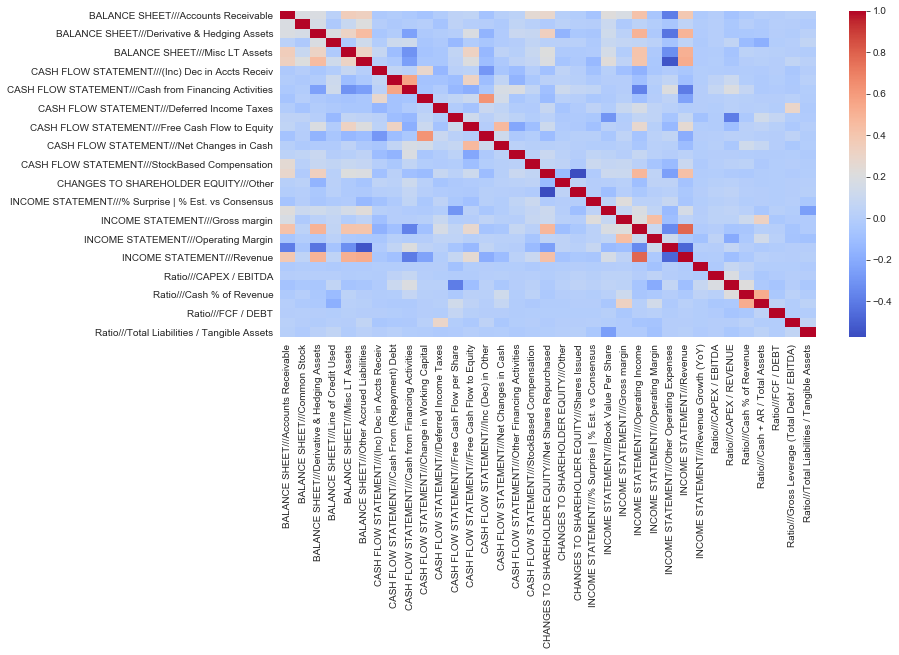

In [523]:
_ = sns.heatmap(data_tmp2.corr(),cmap= 'coolwarm')

Our correlation heatmap looks pretty well.

### Dealing with NA-s

Na statistics along features:

In [527]:
data_tmp2.isna().sum()/data_tmp2.shape[0]

date                                                      0.000000
company                                                   0.000000
BALANCE SHEET///Accounts Receivable                       0.155136
BALANCE SHEET///Common Stock                              0.155136
BALANCE SHEET///Derivative & Hedging Assets               0.155136
BALANCE SHEET///Line of Credit Used                       0.242767
BALANCE SHEET///Misc LT Assets                            0.155136
BALANCE SHEET///Other Accrued Liabilities                 0.155136
CASH FLOW STATEMENT///(Inc) Dec in Accts Receiv           0.155136
CASH FLOW STATEMENT///Cash From (Repayment) Debt          0.155136
CASH FLOW STATEMENT///Cash from Financing Activities      0.155136
CASH FLOW STATEMENT///Change in Working Capital           0.155136
CASH FLOW STATEMENT///Deferred Income Taxes               0.155136
CASH FLOW STATEMENT///Free Cash Flow per Share            0.318658
CASH FLOW STATEMENT///Free Cash Flow to Equity            0.15

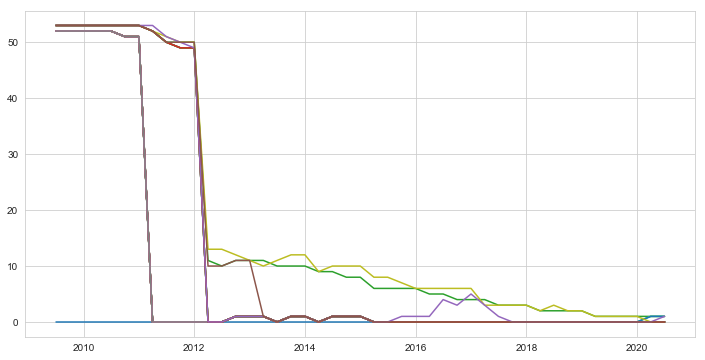

In [545]:
na_data = data_tmp2.groupby('date').aggregate(lambda x: sum(x.isna()))
_ = plt.plot(na_data)

Wee see that most of the nas come from the time before 2012. There's definitely no sense to consider samples without actual target values:

In [650]:
data_tmp3 = data_tmp2[~np.any(data_tmp2[target].isna(),axis=1)]

In [651]:
data_tmp3

date company  BALANCE SHEET///Accounts Receivable  \
7    2011-03-31    AMPY                                0.000   
8    2011-06-30    AMPY                                0.000   
9    2011-09-30    AMPY                                0.000   
10   2011-12-31    AMPY                               27.454   
11   2012-03-31    AMPY                               21.830   
...         ...     ...                                  ...   
2380 2019-06-30     XOG                              121.660   
2381 2019-09-30     XOG                              124.845   
2382 2019-12-31     XOG                              137.112   
2383 2020-03-31     XOG                               88.728   
2384 2020-06-30     XOG                               96.874   

      BALANCE SHEET///Common Stock  \
7                            0.000   
8                            0.000   
9                            0.000   
10                           0.000   
11                           0.000   
...                            ...   
2380                         1.384   
2381                         1.336   
2382                         1.336   
2383                         1.336   
2384                         1.336   

      BALANCE SHEET///Derivative & Hedging Assets  \
7                                           0.000   
8                                           0.000   
9                                           0.000   
10                                          4.957   
11                                          0.517   
...                                           ...   
2380                                       11.959   
2381                                       66.480   
2382                                       17.554   
2383                                      164.330   
2384                                       55.667   

      BALANCE SHEET///Line of Credit Used  BALANCE SHEET///Misc LT Assets  \
7                                     NaN                           0.000   
8                                     NaN                           0.000   
9                                     NaN                           0.000   
10                                    NaN                           1.879   
11                                  234.8                           1.663   
...                                   ...                             ...   
2380                                480.0                          33.962   
2381                                550.0                          45.876   
2382                                470.0                          53.575   
2383                                470.0                          30.600   
2384                                600.5                          15.692   

      BALANCE SHEET///Other Accrued Liabilities  \
7                                      0.000000   
8                                      0.000000   
9                                      0.000000   
10                                     0.000000   
11                                    50.477000   
...                                         ...   
2380                                 270.177984   
2381                                 206.956992   
2382                                 173.476000   
2383                                 209.834000   
2384                                  43.329000   

      CASH FLOW STATEMENT///(Inc) Dec in Accts Receiv  \
7                                               0.000   
8                                               0.000   
9                                               0.000   
10                                             -3.905   
11                                              5.624   
...                                               ...   
2380                                           -5.525   
2381                                            5.534   
2382                                          -27.894   
2383                                    

In [652]:
data_tmp3.isna().sum()[data_tmp3.isna().sum()>0]

BALANCE SHEET///Line of Credit Used                       209
CASH FLOW STATEMENT///Free Cash Flow per Share            390
CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased    211
CHANGES TO SHAREHOLDER EQUITY///Other                       2
CHANGES TO SHAREHOLDER EQUITY///Shares Issued               2
INCOME STATEMENT///Revenue Growth (YoY)                   415
Ratio///CAPEX / EBITDA                                    209
Ratio///CAPEX / REVENUE                                   209
Ratio///Cash % of Revenue                                 209
Ratio///Cash + AR / Total Assets                          209
Ratio///FCF / DEBT                                        209
Ratio///Gross Leverage (Total Debt / EBITDA)              232
Ratio///Total Liabilities / Tangible Assets               251
dtype: int64

It's much more better! Consider now zero target values:

In [653]:
data_tmp3[np.all(data_tmp3[target]==0,axis=1)]

date company  BALANCE SHEET///Accounts Receivable  \
7    2011-03-31    AMPY                                  0.0   
8    2011-06-30    AMPY                                  0.0   
9    2011-09-30    AMPY                                  0.0   
102  2012-06-30      AR                                  0.0   
103  2012-09-30      AR                                  0.0   
...         ...     ...                                  ...   
2362 2014-12-31     XOG                                  0.0   
2363 2015-03-31     XOG                                  0.0   
2364 2015-06-30     XOG                                  0.0   
2365 2015-09-30     XOG                                  0.0   
2366 2015-12-31     XOG                                  0.0   

      BALANCE SHEET///Common Stock  \
7                              0.0   
8                              0.0   
9                              0.0   
102                            0.0   
103                            0.0   
...                            ...   
2362                           0.0   
2363                           0.0   
2364                           0.0   
2365                           0.0   
2366                           0.0   

      BALANCE SHEET///Derivative & Hedging Assets  \
7                                             0.0   
8                                             0.0   
9                                             0.0   
102                                           0.0   
103                                           0.0   
...                                           ...   
2362                                          0.0   
2363                                          0.0   
2364                                          0.0   
2365                                          0.0   
2366                                          0.0   

      BALANCE SHEET///Line of Credit Used  BALANCE SHEET///Misc LT Assets  \
7                                     NaN                             0.0   
8                                     NaN                             0.0   
9                                     NaN                             0.0   
102                                   0.0                             0.0   
103                                   0.0                             0.0   
...                                   ...                             ...   
2362                                  0.0                             0.0   
2363                                  0.0                             0.0   
2364                                  0.0                             0.0   
2365                                  0.0                             0.0   
2366                                  0.0                             0.0   

      BALANCE SHEET///Other Accrued Liabilities  \
7                                           0.0   
8                                           0.0   
9                                           0.0   
102                                         0.0   
103                                         0.0   
...                                         ...   
2362                                        0.0   
2363                                        0.0   
2364                                        0.0   
2365                                        0.0   
2366                                        0.0   

      CASH FLOW STATEMENT///(Inc) Dec in Accts Receiv  \
7                                                 0.0   
8                                                 0.0   
9                                                 0.0   
102                                               0.0   
103                                               0.0   
...                                               ...   
2362                                              0.0   
2363                                              0.0   
2364                                              0.0   
2365                                    

There's no sense in such samples, so we drop them:

In [654]:
data_tmp3 = data_tmp3[~np.all(data_tmp3[target]==0,axis=1)]

In [655]:
data_tmp3

date company  BALANCE SHEET///Accounts Receivable  \
10   2011-12-31    AMPY                               27.454   
11   2012-03-31    AMPY                               21.830   
12   2012-06-30    AMPY                               19.567   
13   2012-09-30    AMPY                               23.307   
14   2012-12-31    AMPY                               39.484   
...         ...     ...                                  ...   
2380 2019-06-30     XOG                              121.660   
2381 2019-09-30     XOG                              124.845   
2382 2019-12-31     XOG                              137.112   
2383 2020-03-31     XOG                               88.728   
2384 2020-06-30     XOG                               96.874   

      BALANCE SHEET///Common Stock  \
10                           0.000   
11                           0.000   
12                           0.665   
13                           0.665   
14                           0.666   
...                            ...   
2380                         1.384   
2381                         1.336   
2382                         1.336   
2383                         1.336   
2384                         1.336   

      BALANCE SHEET///Derivative & Hedging Assets  \
10                                          4.957   
11                                          0.517   
12                                         12.038   
13                                          0.987   
14                                          5.695   
...                                           ...   
2380                                       11.959   
2381                                       66.480   
2382                                       17.554   
2383                                      164.330   
2384                                       55.667   

      BALANCE SHEET///Line of Credit Used  BALANCE SHEET///Misc LT Assets  \
10                                    NaN                           1.879   
11                                  234.8                           1.663   
12                                  151.7                           3.660   
13                                  250.0                          13.454   
14                                  344.0                          25.413   
...                                   ...                             ...   
2380                                480.0                          33.962   
2381                                550.0                          45.876   
2382                                470.0                          53.575   
2383                                470.0                          30.600   
2384                                600.5                          15.692   

      BALANCE SHEET///Other Accrued Liabilities  \
10                                     0.000000   
11                                    50.477000   
12                                    62.985000   
13                                    64.507000   
14                                    98.649000   
...                                         ...   
2380                                 270.177984   
2381                                 206.956992   
2382                                 173.476000   
2383                                 209.834000   
2384                                  43.329000   

      CASH FLOW STATEMENT///(Inc) Dec in Accts Receiv  \
10                                             -3.905   
11                                              5.624   
12                                              2.263   
13                                             -3.740   
14                                            -26.992   
...                                               ...   
2380                                           -5.525   
2381                                            5.534   
2382                                          -27.894   
2383                                    

In [656]:
data_tmp3.isna().sum()[data_tmp3.isna().sum()>0]

BALANCE SHEET///Line of Credit Used                       165
CASH FLOW STATEMENT///Free Cash Flow per Share            191
CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased    167
CHANGES TO SHAREHOLDER EQUITY///Other                       2
CHANGES TO SHAREHOLDER EQUITY///Shares Issued               2
INCOME STATEMENT///Revenue Growth (YoY)                   216
Ratio///CAPEX / EBITDA                                    165
Ratio///CAPEX / REVENUE                                   165
Ratio///Cash % of Revenue                                 165
Ratio///Cash + AR / Total Assets                          165
Ratio///FCF / DEBT                                        165
Ratio///Gross Leverage (Total Debt / EBITDA)              188
Ratio///Total Liabilities / Tangible Assets               165
dtype: int64

In [657]:
data_tmp3.to_excel('data/data_tmp3.xlsx')

In [740]:
data_tmp3 = pd.read_excel('data/data_tmp3.xlsx',index_col=0)

Consider now these features separetely:

__BALANCE SHEET///Line of Credit Used__

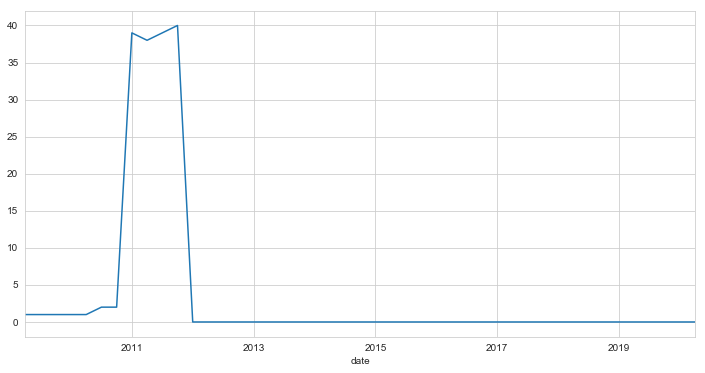

In [741]:
_ = data_tmp3[['date', 'company','BALANCE SHEET///Line of Credit Used']].groupby('date').aggregate(lambda x: sum(x.isna()))['BALANCE SHEET///Line of Credit Used'].plot()

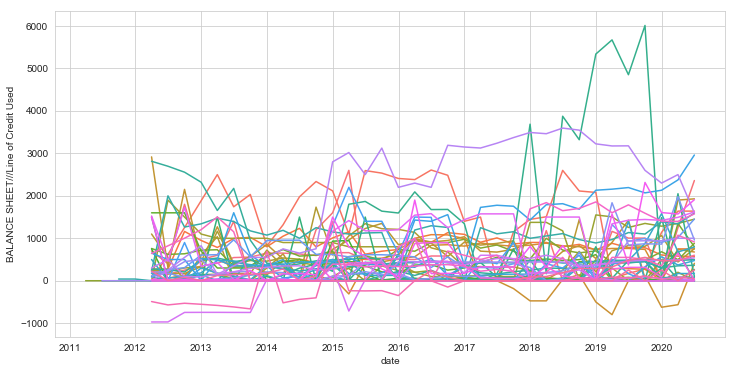

In [742]:
_ = sns.lineplot(x=data_tmp3['date'], y = data_tmp3['BALANCE SHEET///Line of Credit Used'], hue=data_tmp3['company'], legend=False)

Let's take the values from the nearest date (backfill)

In [743]:
for c in data_tmp3['company'].unique():
    data_tmp3.loc[data_tmp3['company']==c,'BALANCE SHEET///Line of Credit Used'] =\
    data_tmp3.loc[data_tmp3['company']==c,'BALANCE SHEET///Line of Credit Used'].fillna(method='backfill')

In [744]:
data_tmp3['BALANCE SHEET///Line of Credit Used'].isna().sum()

0

__CASH FLOW STATEMENT///Free Cash Flow per Share__

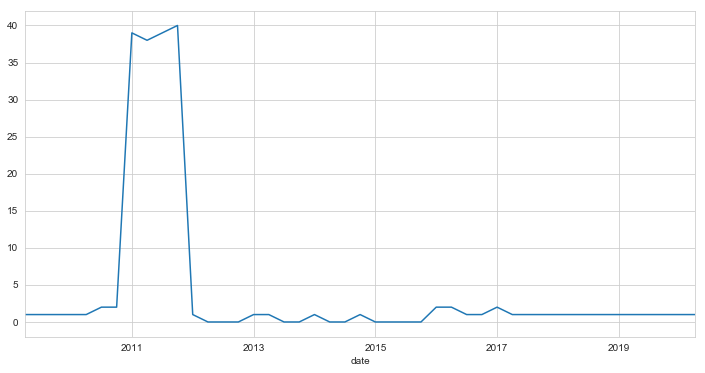

In [745]:
_ = data_tmp3[['date', 'company','CASH FLOW STATEMENT///Free Cash Flow per Share']].groupby('date').aggregate(lambda x: sum(x.isna()))['CASH FLOW STATEMENT///Free Cash Flow per Share'].plot()

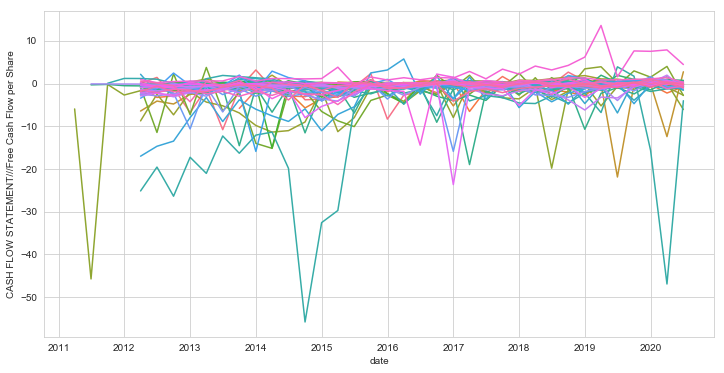

In [746]:
_ = sns.lineplot(x=data_tmp3['date'], y = data_tmp3['CASH FLOW STATEMENT///Free Cash Flow per Share'], hue=data_tmp3['company'], legend=False)

Let's fill in this way:

* Before 2012 with backfill
* Starting from 2012 with mean

In [747]:
for c in data_tmp3['company'].unique():
    m = data_tmp3.loc[(data_tmp3['date'].dt.year>=2012)&(data_tmp3['company']==c),
                      'CASH FLOW STATEMENT///Free Cash Flow per Share'].mean()
    data_tmp3.loc[(data_tmp3['date'].dt.year>=2012)&(data_tmp3['company']==c),
                  'CASH FLOW STATEMENT///Free Cash Flow per Share']=\
    data_tmp3.loc[(data_tmp3['date'].dt.year>=2012)&(data_tmp3['company']==c),
                  'CASH FLOW STATEMENT///Free Cash Flow per Share'].fillna(value=m)

In [748]:
for c in data_tmp3['company'].unique():
    data_tmp3.loc[data_tmp3['company']==c,'CASH FLOW STATEMENT///Free Cash Flow per Share']=\
    data_tmp3.loc[data_tmp3['company']==c,'CASH FLOW STATEMENT///Free Cash Flow per Share'].fillna(method='backfill')

In [749]:
data_tmp3['CASH FLOW STATEMENT///Free Cash Flow per Share'].isna().sum()

18

In [750]:
data_tmp3.loc[data_tmp3['company']=='LONE','CASH FLOW STATEMENT///Free Cash Flow per Share']

1197   NaN
1198   NaN
1199   NaN
1200   NaN
1201   NaN
1202   NaN
1203   NaN
1204   NaN
1205   NaN
1206   NaN
1207   NaN
1208   NaN
1209   NaN
1210   NaN
1211   NaN
1212   NaN
1213   NaN
1214   NaN
Name: CASH FLOW STATEMENT///Free Cash Flow per Share, dtype: float64

For this company we have no informatino about this feature at all, let's fill with the median for the corresponding year: 

In [751]:
for d in data_tmp3.loc[data_tmp3['company']=='LONE'].date:
    data_tmp3.loc[(data_tmp3['company']=='LONE')&(data_tmp3['date']==d),'CASH FLOW STATEMENT///Free Cash Flow per Share'] =\
    data_tmp3.loc[data_tmp3['date']==d,'CASH FLOW STATEMENT///Free Cash Flow per Share'].median()

In [752]:
data_tmp3['CASH FLOW STATEMENT///Free Cash Flow per Share'].isna().sum()

0

No nas left here!

__CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased__

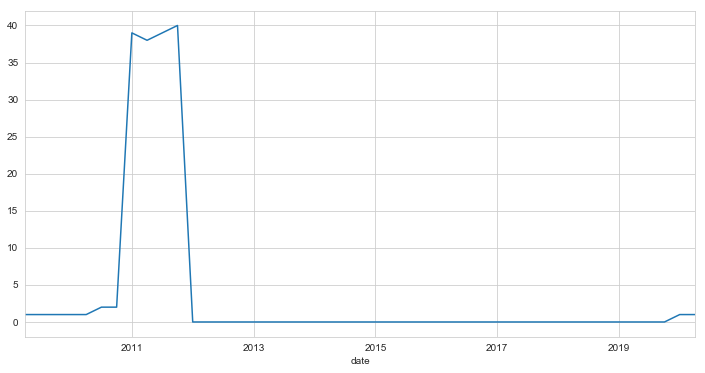

In [753]:
_ = data_tmp3[['date', 'company','CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased']].groupby('date').aggregate(lambda x: sum(x.isna()))['CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased'].plot()

Let's forward propogate after 2012 and do backfill before 2012

In [755]:
for c in data_tmp3['company'].unique():
    data_tmp3.loc[(data_tmp3['date'].dt.year>=2012)&(data_tmp3['company']==c),
                  'CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased']=\
    data_tmp3.loc[(data_tmp3['date'].dt.year>=2012)&(data_tmp3['company']==c),
                  'CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased'].fillna(method='ffill')

In [756]:
for c in data_tmp3['company'].unique():
    data_tmp3.loc[data_tmp3['company']==c,'CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased']=\
    data_tmp3.loc[data_tmp3['company']==c,'CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased'].fillna(method='backfill')

In [757]:
data_tmp3['CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased'].isna().sum()

0

__CHANGES TO SHAREHOLDER EQUITY///Other__

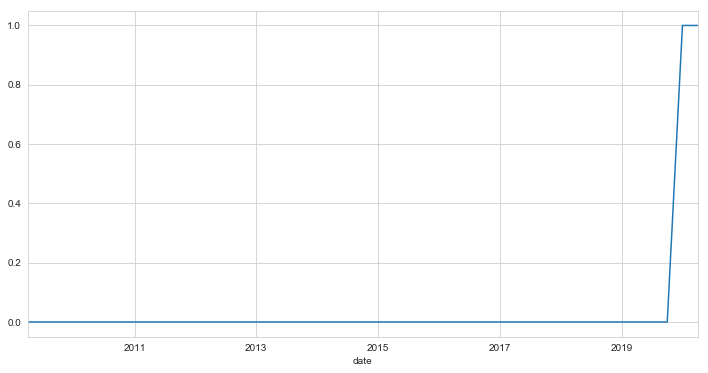

In [739]:
_ = data_tmp3[['date', 'company','CHANGES TO SHAREHOLDER EQUITY///Other']].groupby('date').aggregate(lambda x: sum(x.isna()))['CHANGES TO SHAREHOLDER EQUITY///Other'].plot()

Let's forward propagate

In [758]:
for c in data_tmp3['company'].unique():
    data_tmp3.loc[data_tmp3['company']==c,'CHANGES TO SHAREHOLDER EQUITY///Other']=\
    data_tmp3.loc[data_tmp3['company']==c,'CHANGES TO SHAREHOLDER EQUITY///Other'].fillna(method='ffill')

In [759]:
data_tmp3['CHANGES TO SHAREHOLDER EQUITY///Other'].isna().sum()

0

__CHANGES TO SHAREHOLDER EQUITY///Shares Issued__

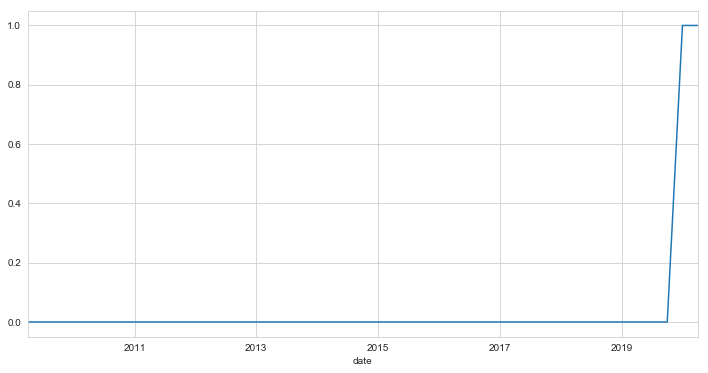

In [760]:
_ = data_tmp3[['date', 'company','CHANGES TO SHAREHOLDER EQUITY///Shares Issued']].groupby('date').aggregate(lambda x: sum(x.isna()))['CHANGES TO SHAREHOLDER EQUITY///Shares Issued'].plot()

Let's forward propagate

In [761]:
for c in data_tmp3['company'].unique():
    data_tmp3.loc[data_tmp3['company']==c,'CHANGES TO SHAREHOLDER EQUITY///Shares Issued']=\
    data_tmp3.loc[data_tmp3['company']==c,'CHANGES TO SHAREHOLDER EQUITY///Shares Issued'].fillna(method='ffill')

In [762]:
data_tmp3['CHANGES TO SHAREHOLDER EQUITY///Shares Issued'].isna().sum()

0

__INCOME STATEMENT///Revenue Growth (YoY)__

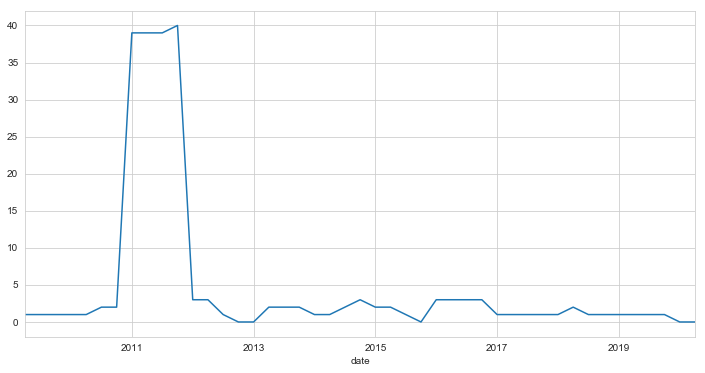

In [763]:
_ = data_tmp3[['date', 'company','INCOME STATEMENT///Revenue Growth (YoY)']].groupby('date').aggregate(lambda x: sum(x.isna()))['INCOME STATEMENT///Revenue Growth (YoY)'].plot()

Let's fill in this way:

* Before 2012 with backfill
* Starting from 2012 with mean

In [764]:
for c in data_tmp3['company'].unique():
    m = data_tmp3.loc[(data_tmp3['date'].dt.year>=2012)&(data_tmp3['company']==c),
                      'INCOME STATEMENT///Revenue Growth (YoY)'].mean()
    data_tmp3.loc[(data_tmp3['date'].dt.year>=2012)&(data_tmp3['company']==c),
                  'INCOME STATEMENT///Revenue Growth (YoY)']=\
    data_tmp3.loc[(data_tmp3['date'].dt.year>=2012)&(data_tmp3['company']==c),
                  'INCOME STATEMENT///Revenue Growth (YoY)'].fillna(value=m)

In [765]:
for c in data_tmp3['company'].unique():
    data_tmp3.loc[data_tmp3['company']==c,'INCOME STATEMENT///Revenue Growth (YoY)']=\
    data_tmp3.loc[data_tmp3['company']==c,'INCOME STATEMENT///Revenue Growth (YoY)'].fillna(method='backfill')

In [766]:
data_tmp3['CASH FLOW STATEMENT///Free Cash Flow per Share'].isna().sum()

0

__Ratio///CAPEX / EBITDA__

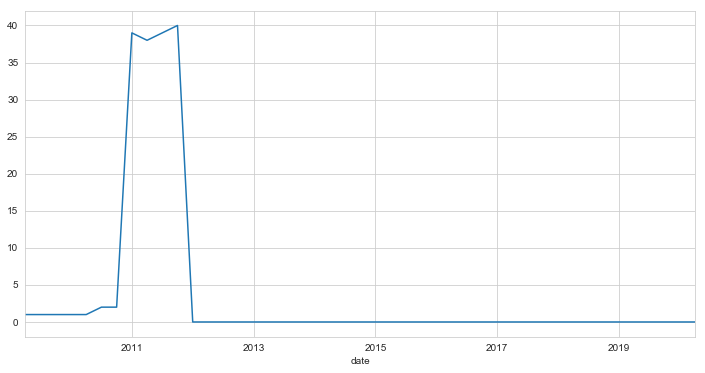

In [767]:
_ = data_tmp3[['date', 'company','Ratio///CAPEX / EBITDA']].groupby('date').aggregate(lambda x: sum(x.isna()))['Ratio///CAPEX / EBITDA'].plot()

In [768]:
for c in data_tmp3['company'].unique():
    data_tmp3.loc[data_tmp3['company']==c,'Ratio///CAPEX / EBITDA'] =\
    data_tmp3.loc[data_tmp3['company']==c,'Ratio///CAPEX / EBITDA'].fillna(method='backfill')

In [769]:
data_tmp3['Ratio///CAPEX / EBITDA'].isna().sum()

0

__Ratio///CAPEX / REVENUE__

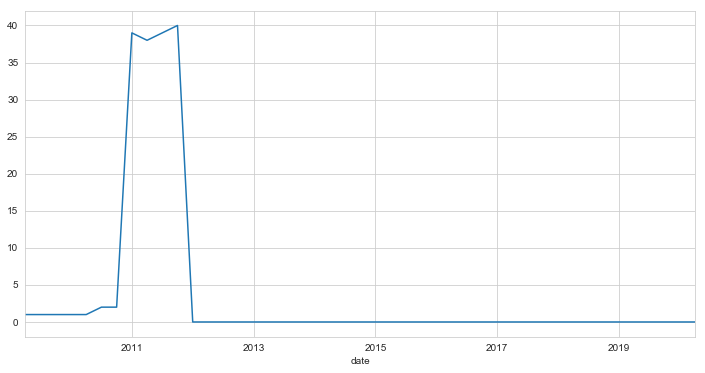

In [771]:
_ = data_tmp3[['date', 'company','Ratio///CAPEX / REVENUE']].groupby('date').aggregate(lambda x: sum(x.isna()))['Ratio///CAPEX / REVENUE'].plot()

Let's take the values from the nearest date (backfill)

In [772]:
for c in data_tmp3['company'].unique():
    data_tmp3.loc[data_tmp3['company']==c,'Ratio///CAPEX / REVENUE'] =\
    data_tmp3.loc[data_tmp3['company']==c,'Ratio///CAPEX / REVENUE'].fillna(method='backfill')

In [773]:
data_tmp3['Ratio///CAPEX / REVENUE'].isna().sum()

0

__Ratio///Cash % of Revenue__

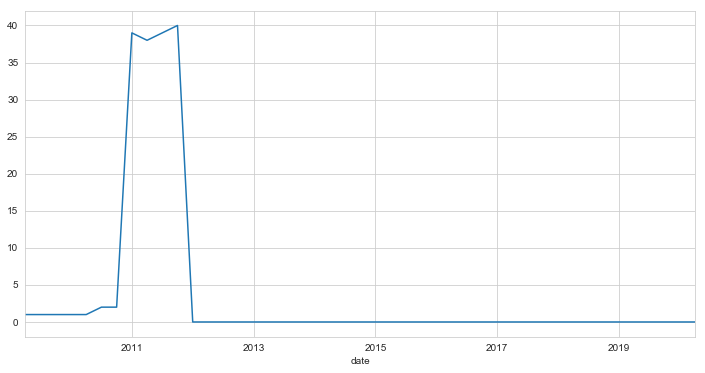

In [774]:
_ = data_tmp3[['date', 'company','Ratio///Cash % of Revenue']].groupby('date').aggregate(lambda x: sum(x.isna()))['Ratio///Cash % of Revenue'].plot()

Let's take the values from the nearest date (backfill)

In [775]:
for c in data_tmp3['company'].unique():
    data_tmp3.loc[data_tmp3['company']==c,'Ratio///Cash % of Revenue'] =\
    data_tmp3.loc[data_tmp3['company']==c,'Ratio///Cash % of Revenue'].fillna(method='backfill')

In [776]:
data_tmp3['Ratio///Cash % of Revenue'].isna().sum()

0

__Ratio///Cash + AR / Total Assets__

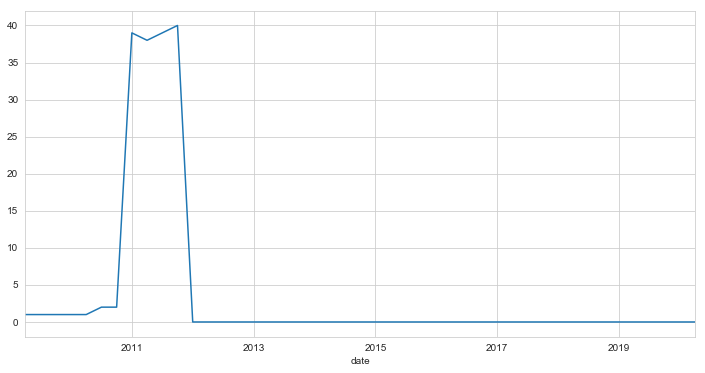

In [777]:
_ = data_tmp3[['date', 'company','Ratio///Cash + AR / Total Assets']].groupby('date').aggregate(lambda x: sum(x.isna()))['Ratio///Cash + AR / Total Assets'].plot()

Let's take the values from the nearest date (backfill)

In [778]:
for c in data_tmp3['company'].unique():
    data_tmp3.loc[data_tmp3['company']==c,'Ratio///Cash + AR / Total Assets'] =\
    data_tmp3.loc[data_tmp3['company']==c,'Ratio///Cash + AR / Total Assets'].fillna(method='backfill')

In [779]:
data_tmp3['Ratio///Cash + AR / Total Assets'].isna().sum()

0

__Ratio///FCF / DEBT__

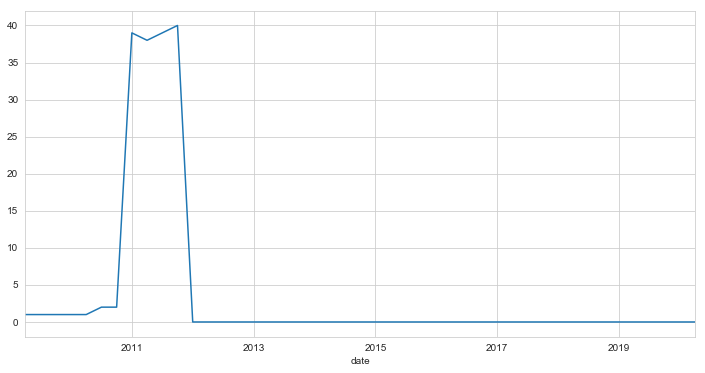

In [780]:
_ = data_tmp3[['date', 'company','Ratio///FCF / DEBT']].groupby('date').aggregate(lambda x: sum(x.isna()))['Ratio///FCF / DEBT'].plot()

Let's take the values from the nearest date (backfill)

In [781]:
for c in data_tmp3['company'].unique():
    data_tmp3.loc[data_tmp3['company']==c,'Ratio///FCF / DEBT'] =\
    data_tmp3.loc[data_tmp3['company']==c,'Ratio///FCF / DEBT'].fillna(method='backfill')

In [782]:
data_tmp3['Ratio///FCF / DEBT'].isna().sum()

0

__Ratio///Gross Leverage (Total Debt / EBITDA)__

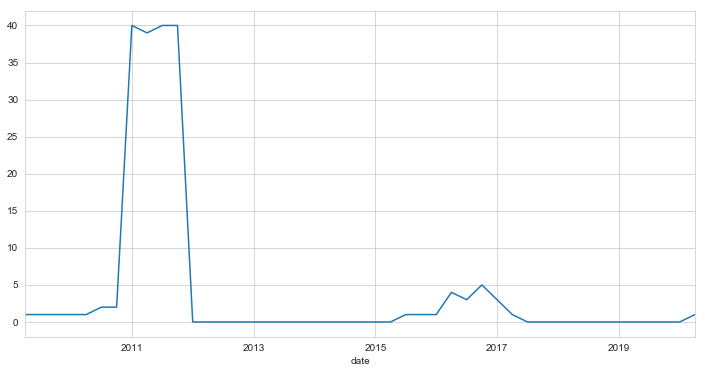

In [783]:
_ = data_tmp3[['date', 'company','Ratio///Gross Leverage (Total Debt / EBITDA)']].groupby('date').aggregate(lambda x: sum(x.isna()))['Ratio///Gross Leverage (Total Debt / EBITDA)'].plot()

Let's fill in this way:

* Before 2012 with backfill
* Starting from 2012 with mean

In [784]:
for c in data_tmp3['company'].unique():
    m = data_tmp3.loc[(data_tmp3['date'].dt.year>=2012)&(data_tmp3['company']==c),
                      'Ratio///Gross Leverage (Total Debt / EBITDA)'].mean()
    data_tmp3.loc[(data_tmp3['date'].dt.year>=2012)&(data_tmp3['company']==c),
                  'Ratio///Gross Leverage (Total Debt / EBITDA)']=\
    data_tmp3.loc[(data_tmp3['date'].dt.year>=2012)&(data_tmp3['company']==c),
                  'Ratio///Gross Leverage (Total Debt / EBITDA)'].fillna(value=m)

In [785]:
for c in data_tmp3['company'].unique():
    data_tmp3.loc[data_tmp3['company']==c,'Ratio///Gross Leverage (Total Debt / EBITDA)']=\
    data_tmp3.loc[data_tmp3['company']==c,'Ratio///Gross Leverage (Total Debt / EBITDA)'].fillna(method='backfill')

In [786]:
data_tmp3['Ratio///Gross Leverage (Total Debt / EBITDA)'].isna().sum()

0

__Ratio///Total Liabilities / Tangible Assets__

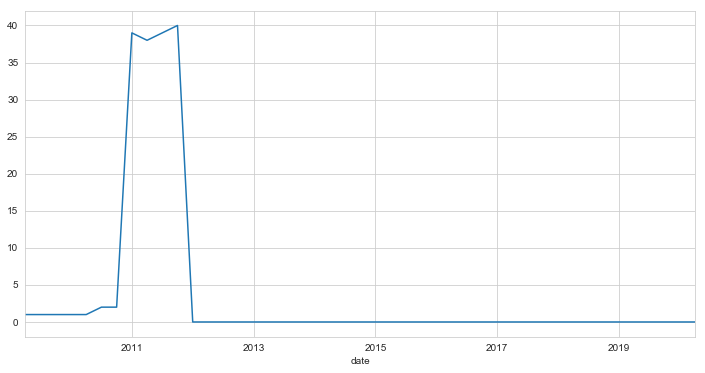

In [787]:
_ = data_tmp3[['date', 'company','Ratio///Total Liabilities / Tangible Assets']].groupby('date').aggregate(lambda x: sum(x.isna()))['Ratio///Total Liabilities / Tangible Assets'].plot()

Let's take the values from the nearest date (backfill)

In [788]:
for c in data_tmp3['company'].unique():
    data_tmp3.loc[data_tmp3['company']==c,'Ratio///Total Liabilities / Tangible Assets'] =\
    data_tmp3.loc[data_tmp3['company']==c,'Ratio///Total Liabilities / Tangible Assets'].fillna(method='backfill')

In [789]:
data_tmp3['Ratio///Total Liabilities / Tangible Assets'].isna().sum()

0

__RESULT__

In [791]:
data_tmp3.isna().sum().sum()

0

We have zero na values left!!!

In [795]:
data_tmp4 = data_tmp3.copy()
data_tmp4.reset_index(drop=True, inplace=True)
data_tmp4.to_excel('data/data_tmp4.xlsx')

In [796]:
data_tmp4

date company  BALANCE SHEET///Accounts Receivable  \
0    2011-12-31    AMPY                               27.454   
1    2012-03-31    AMPY                               21.830   
2    2012-06-30    AMPY                               19.567   
3    2012-09-30    AMPY                               23.307   
4    2012-12-31    AMPY                               39.484   
...         ...     ...                                  ...   
1811 2019-06-30     XOG                              121.660   
1812 2019-09-30     XOG                              124.845   
1813 2019-12-31     XOG                              137.112   
1814 2020-03-31     XOG                               88.728   
1815 2020-06-30     XOG                               96.874   

      BALANCE SHEET///Common Stock  \
0                            0.000   
1                            0.000   
2                            0.665   
3                            0.665   
4                            0.666   
...                            ...   
1811                         1.384   
1812                         1.336   
1813                         1.336   
1814                         1.336   
1815                         1.336   

      BALANCE SHEET///Derivative & Hedging Assets  \
0                                           4.957   
1                                           0.517   
2                                          12.038   
3                                           0.987   
4                                           5.695   
...                                           ...   
1811                                       11.959   
1812                                       66.480   
1813                                       17.554   
1814                                      164.330   
1815                                       55.667   

      BALANCE SHEET///Line of Credit Used  BALANCE SHEET///Misc LT Assets  \
0                                   234.8                           1.879   
1                                   234.8                           1.663   
2                                   151.7                           3.660   
3                                   250.0                          13.454   
4                                   344.0                          25.413   
...                                   ...                             ...   
1811                                480.0                          33.962   
1812                                550.0                          45.876   
1813                                470.0                          53.575   
1814                                470.0                          30.600   
1815                                600.5                          15.692   

      BALANCE SHEET///Other Accrued Liabilities  \
0                                      0.000000   
1                                     50.477000   
2                                     62.985000   
3                                     64.507000   
4                                     98.649000   
...                                         ...   
1811                                 270.177984   
1812                                 206.956992   
1813                                 173.476000   
1814                                 209.834000   
1815                                  43.329000   

      CASH FLOW STATEMENT///(Inc) Dec in Accts Receiv  \
0                                              -3.905   
1                                               5.624   
2                                               2.263   
3                                              -3.740   
4                                             -26.992   
...                                               ...   
1811                                           -5.525   
1812                                            5.534   
1813                                          -27.894   
1814                                    

### Data Description

In [5]:
data_tmp4 = pd.read_excel('data/data_tmp4.xlsx',index_col=0)
data_tmp4

date company  BALANCE SHEET///Accounts Receivable  \
0    2011-12-31    AMPY                               27.454   
1    2012-03-31    AMPY                               21.830   
2    2012-06-30    AMPY                               19.567   
3    2012-09-30    AMPY                               23.307   
4    2012-12-31    AMPY                               39.484   
...         ...     ...                                  ...   
1811 2019-06-30     XOG                              121.660   
1812 2019-09-30     XOG                              124.845   
1813 2019-12-31     XOG                              137.112   
1814 2020-03-31     XOG                               88.728   
1815 2020-06-30     XOG                               96.874   

      BALANCE SHEET///Common Stock  \
0                            0.000   
1                            0.000   
2                            0.665   
3                            0.665   
4                            0.666   
...                            ...   
1811                         1.384   
1812                         1.336   
1813                         1.336   
1814                         1.336   
1815                         1.336   

      BALANCE SHEET///Derivative & Hedging Assets  \
0                                           4.957   
1                                           0.517   
2                                          12.038   
3                                           0.987   
4                                           5.695   
...                                           ...   
1811                                       11.959   
1812                                       66.480   
1813                                       17.554   
1814                                      164.330   
1815                                       55.667   

      BALANCE SHEET///Line of Credit Used  BALANCE SHEET///Misc LT Assets  \
0                                   234.8                           1.879   
1                                   234.8                           1.663   
2                                   151.7                           3.660   
3                                   250.0                          13.454   
4                                   344.0                          25.413   
...                                   ...                             ...   
1811                                480.0                          33.962   
1812                                550.0                          45.876   
1813                                470.0                          53.575   
1814                                470.0                          30.600   
1815                                600.5                          15.692   

      BALANCE SHEET///Other Accrued Liabilities  \
0                                      0.000000   
1                                     50.477000   
2                                     62.985000   
3                                     64.507000   
4                                     98.649000   
...                                         ...   
1811                                 270.177984   
1812                                 206.956992   
1813                                 173.476000   
1814                                 209.834000   
1815                                  43.329000   

      CASH FLOW STATEMENT///(Inc) Dec in Accts Receiv  \
0                                              -3.905   
1                                               5.624   
2                                               2.263   
3                                              -3.740   
4                                             -26.992   
...                                               ...   
1811                                           -5.525   
1812                                            5.534   
1813                                          -27.894   
1814                                    

In [6]:
target = ['INCOME STATEMENT///Operating Income', 'INCOME STATEMENT///Revenue']

In [8]:
data_tmp4[target]

INCOME STATEMENT///Operating Income  INCOME STATEMENT///Revenue
0                                 -32.289                   61.863000
1                                   2.342                   48.410000
2                                   4.064                   49.259000
3                                   3.674                   55.498000
4                                  20.680                   89.839000
...                                   ...                         ...
1811                               19.823                  236.260000
1812                              -18.356                  176.942000
1813                              -87.464                  230.844000
1814                             -157.080                  165.187008
1815                             -174.478                   63.129000

[1816 rows x 2 columns]

In [12]:
data_tmp4.loc[:,~data_tmp4.columns.isin(target+['date','company'])].describe()

BALANCE SHEET///Accounts Receivable  BALANCE SHEET///Common Stock  \
count                          1816.000000                   1816.000000   
mean                            341.019705                    206.668117   
std                             581.519343                    896.198210   
min                               0.000000                      0.000000   
25%                              29.443250                      0.152000   
50%                             100.660000                      1.225000   
75%                             346.083000                     18.000000   
max                            6497.999872                   9388.903424   

       BALANCE SHEET///Derivative & Hedging Assets  \
count                                  1816.000000   
mean                                     99.112152   
std                                     288.805970   
min                                       0.000000   
25%                                       0.000000   
50%                                       8.694500   
75%                                      74.833500   
max                                    5048.000000   

       BALANCE SHEET///Line of Credit Used  BALANCE SHEET///Misc LT Assets  \
count                          1816.000000                     1816.000000   
mean                            449.318563                      213.088573   
std                             693.916638                      592.367383   
min                            -971.299968                        0.000000   
25%                               0.000000                        8.866000   
50%                             199.999744                       34.660000   
75%                             625.249968                      146.051256   
max                            6012.999936                    11237.000192   

       BALANCE SHEET///Other Accrued Liabilities  \
count                                1816.000000   
mean                                  253.973596   
std                                   538.985718   
min                                     0.000000   
25%                                     5.386500   
50%                                    57.551000   
75%                                   215.662008   
max                                  3904.999936   

       CASH FLOW STATEMENT///(Inc) Dec in Accts Receiv  \
count                                      1816.000000   
mean                                          3.833619   
std                                         107.965596   
min                                       -1376.000000   
25%                                          -8.481367   
50%                                           0.000000   
75%                                           5.863750   
max                                        1368.000000   

       CASH FLOW STATEMENT///Cash From (Repayment) Debt  \
count                                       1816.000000   
mean                                          22.326741   
std                                          443.241371   
min                                        -3771.000064   
25%                                           -9.561500   
50%                                            0.000000   
75%                                           58.000000   
max                                         6360.000000   

       CASH FLOW STATEMENT///Cash from Financing Activities  \
count                                        1816.000000      
mean                                           -6.249523      
std                                           546.431228      
min                                         -5896.999936      
25%                                           -35.161250      
50%                                             0.000000      
75%                                            71.400000      
max                                          5072.999936      

       CASH FLOW STATEMENT///Change in W

Features boxplots:

In [14]:
features = data_tmp4.columns[~data_tmp4.columns.isin(target+['date','company'])]
features

Index(['BALANCE SHEET///Accounts Receivable', 'BALANCE SHEET///Common Stock',
       'BALANCE SHEET///Derivative & Hedging Assets',
       'BALANCE SHEET///Line of Credit Used', 'BALANCE SHEET///Misc LT Assets',
       'BALANCE SHEET///Other Accrued Liabilities',
       'CASH FLOW STATEMENT///(Inc) Dec in Accts Receiv',
       'CASH FLOW STATEMENT///Cash From (Repayment) Debt',
       'CASH FLOW STATEMENT///Cash from Financing Activities',
       'CASH FLOW STATEMENT///Change in Working Capital',
       'CASH FLOW STATEMENT///Deferred Income Taxes',
       'CASH FLOW STATEMENT///Free Cash Flow per Share',
       'CASH FLOW STATEMENT///Free Cash Flow to Equity',
       'CASH FLOW STATEMENT///Inc (Dec) in Other',
       'CASH FLOW STATEMENT///Net Changes in Cash',
       'CASH FLOW STATEMENT///Other Financing Activities',
       'CASH FLOW STATEMENT///StockBased Compensation',
       'CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased',
       'CHANGES TO SHAREHOLDER EQUITY///Other',

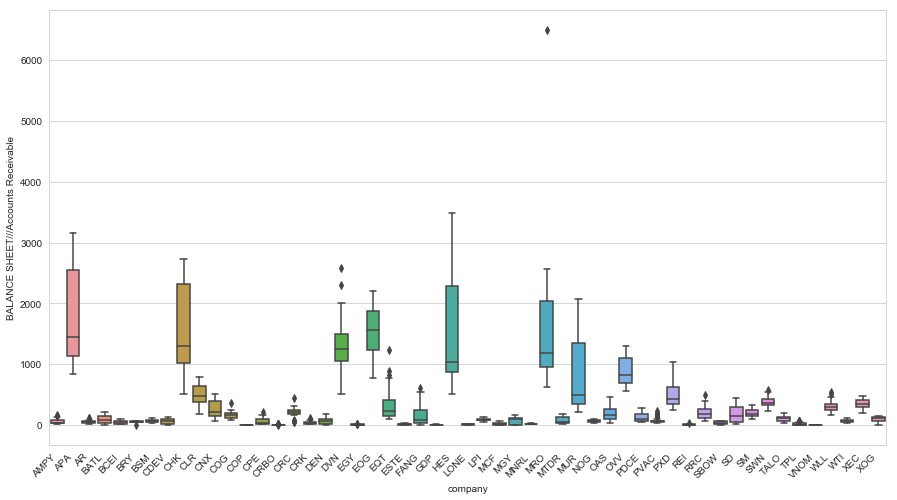

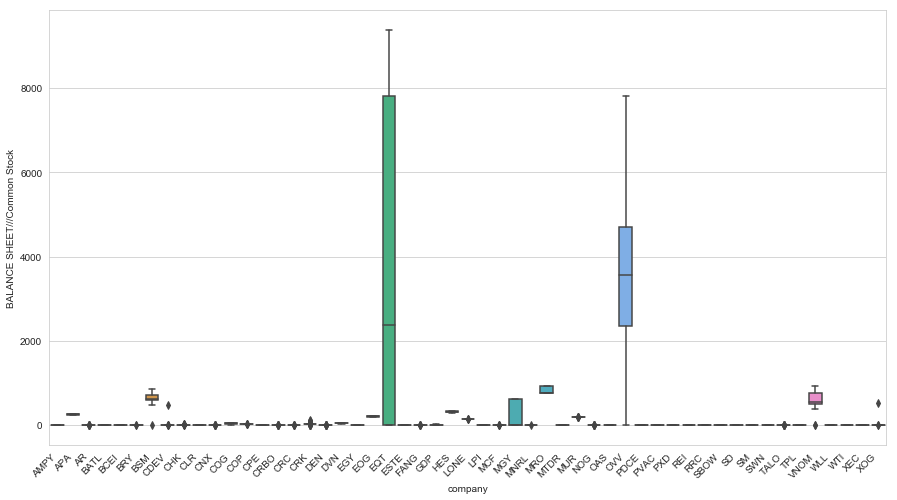

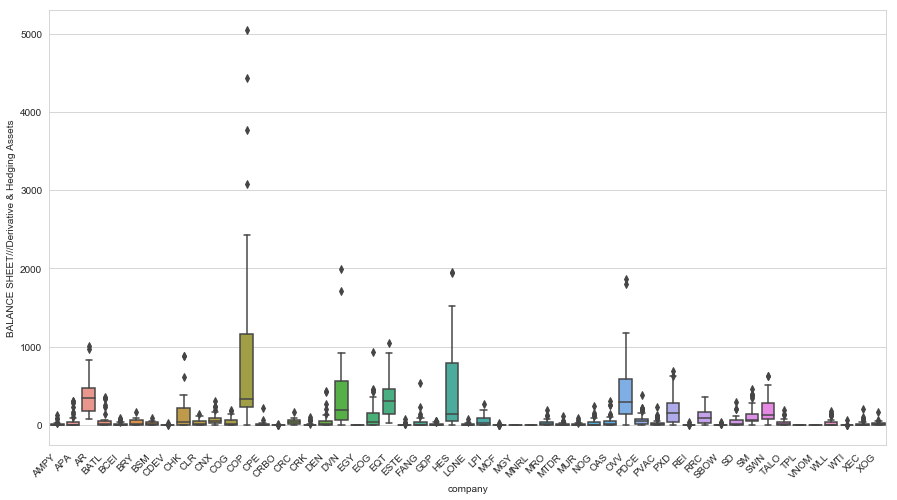

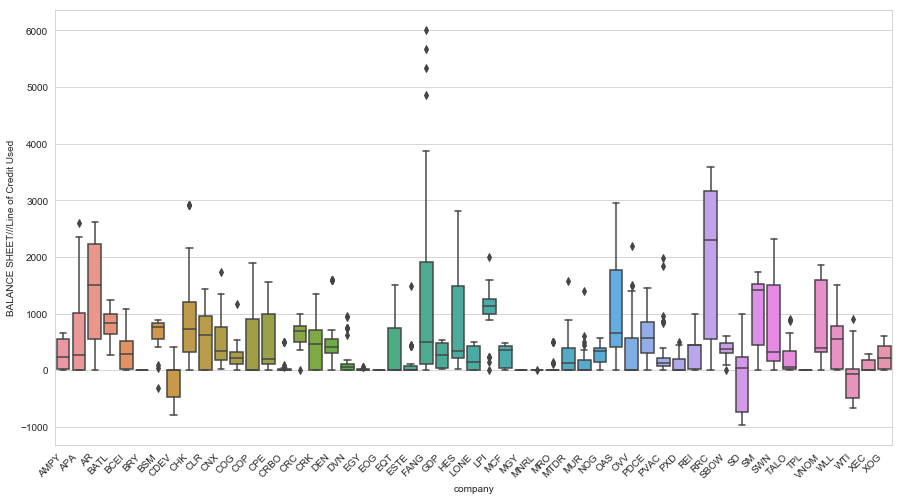

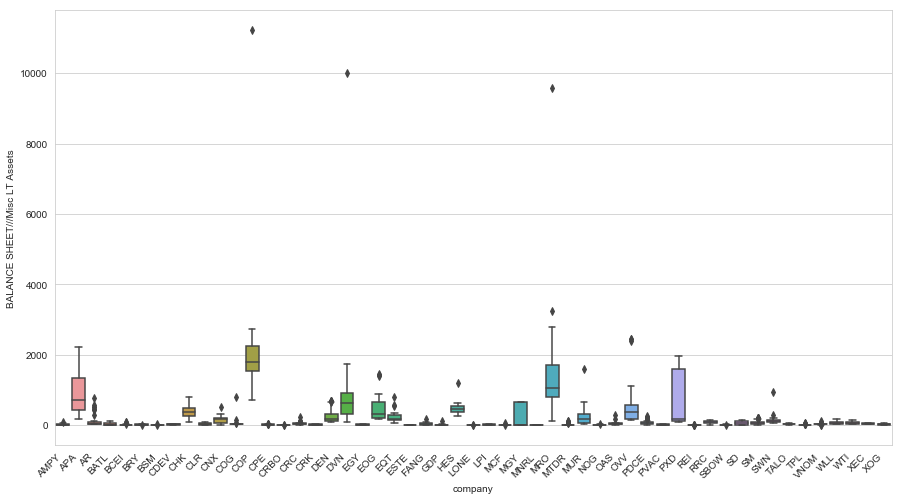

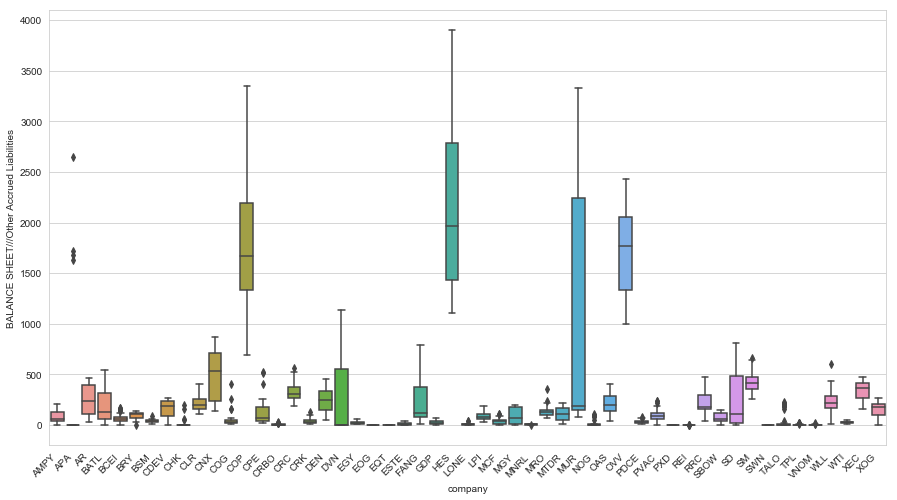

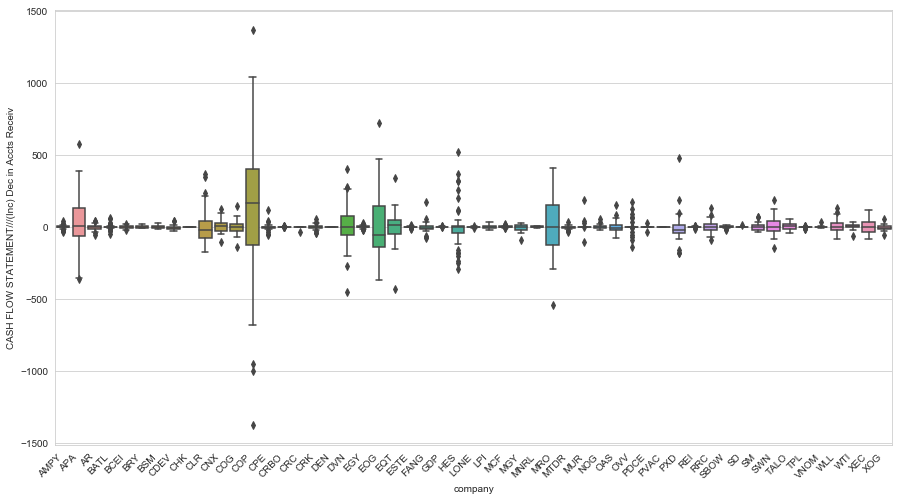

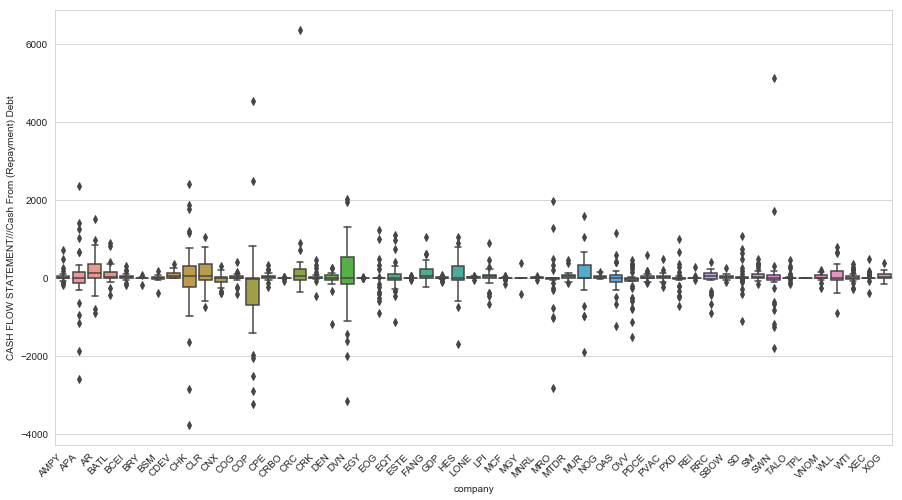

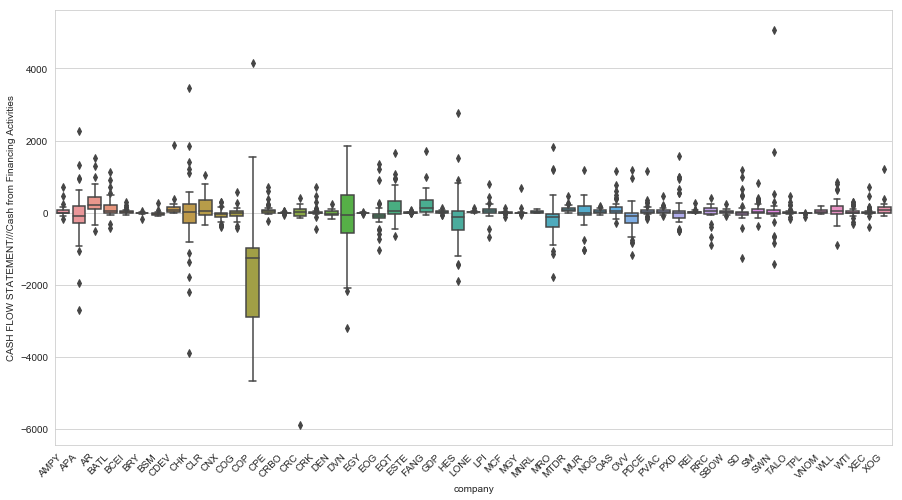

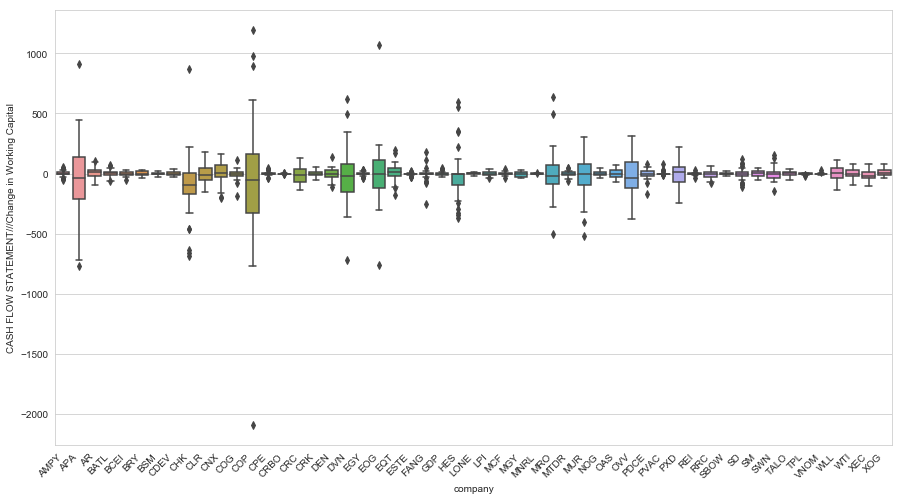

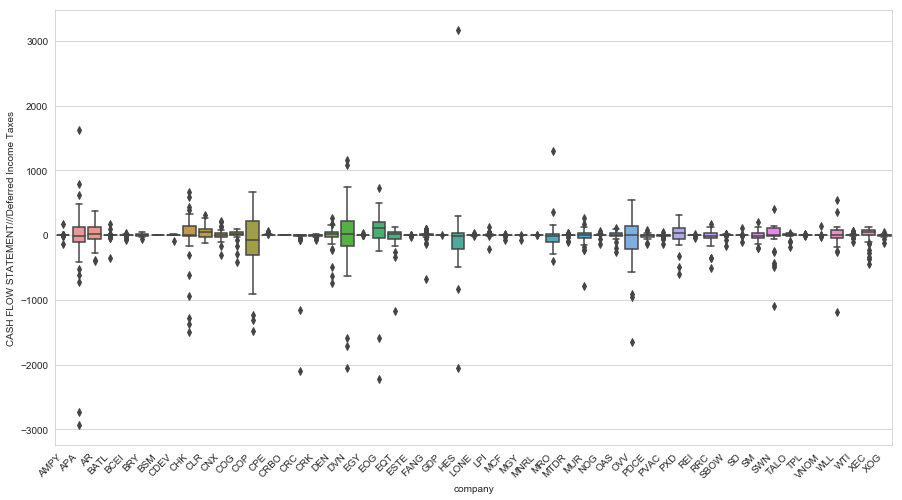

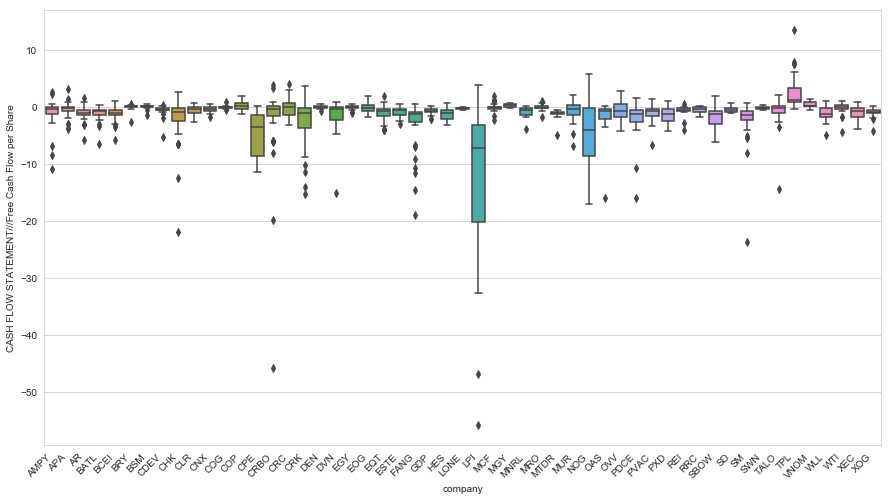

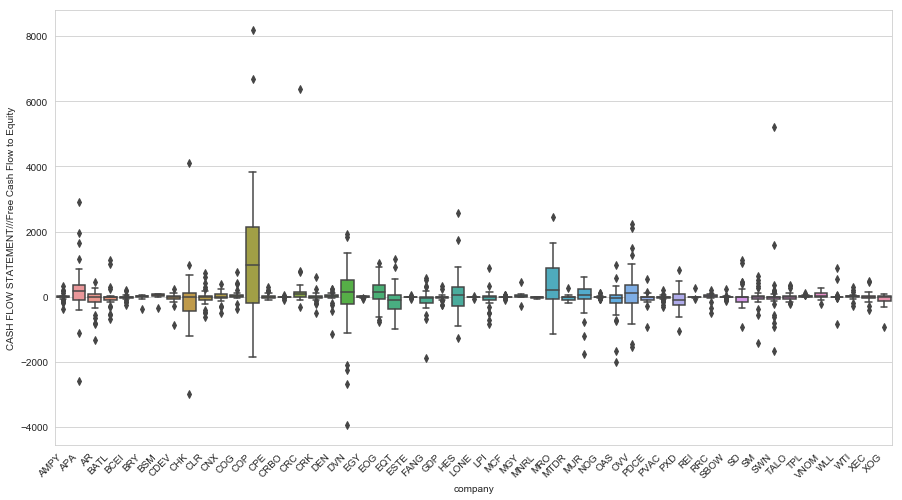

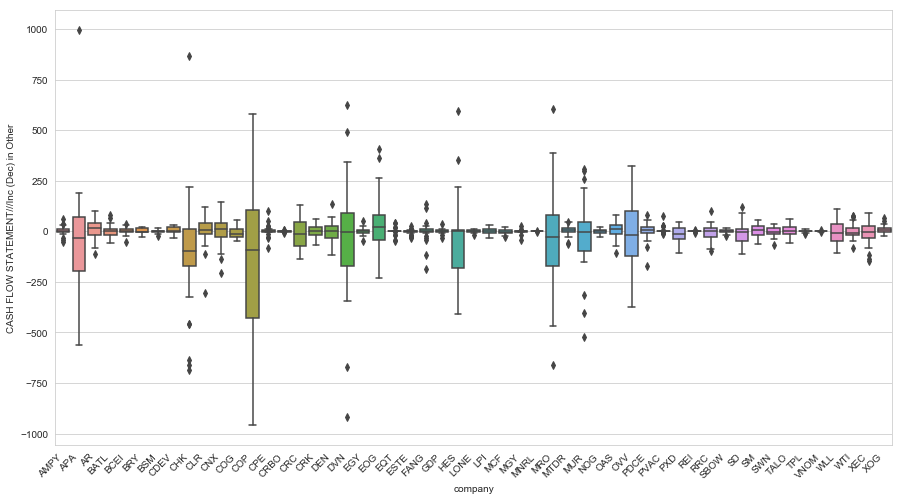

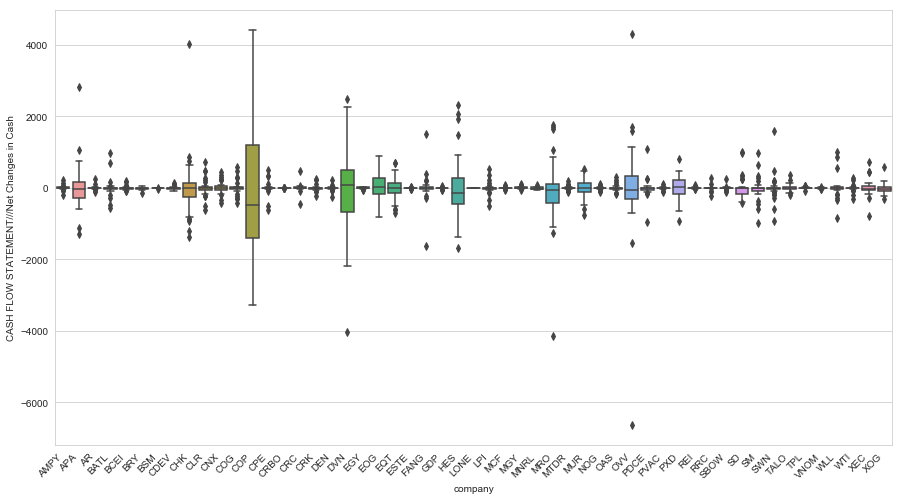

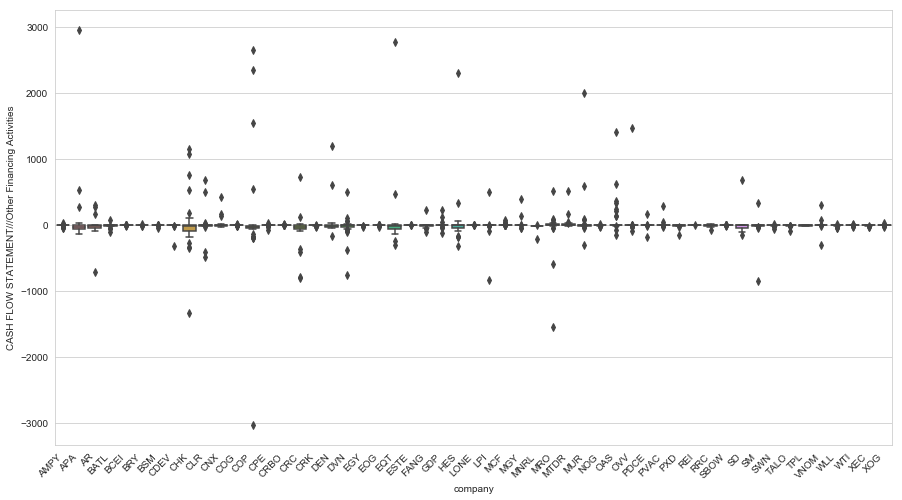

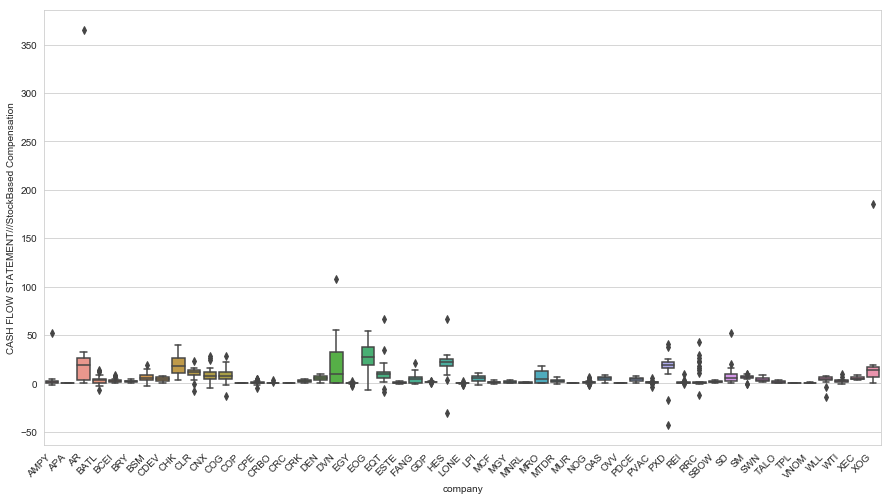

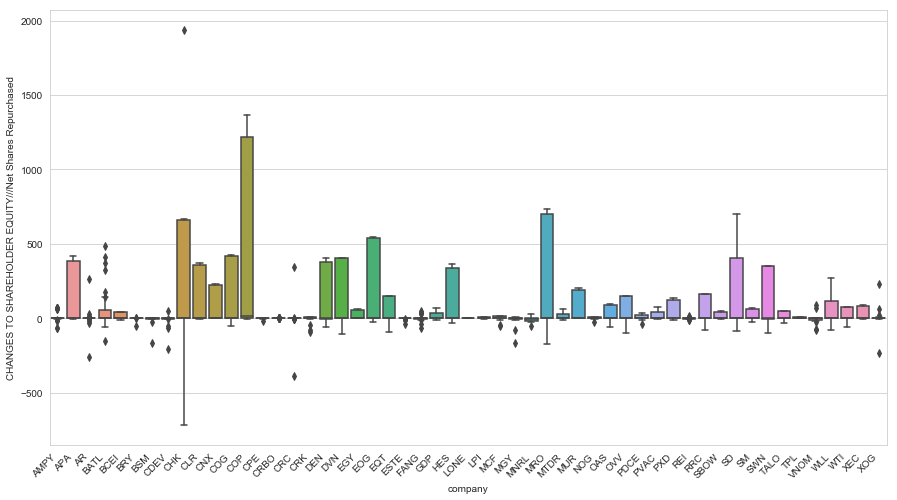

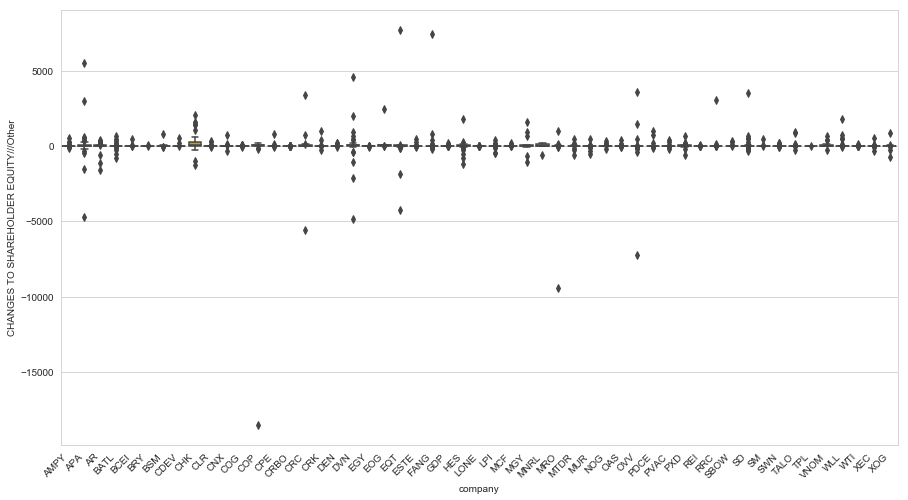

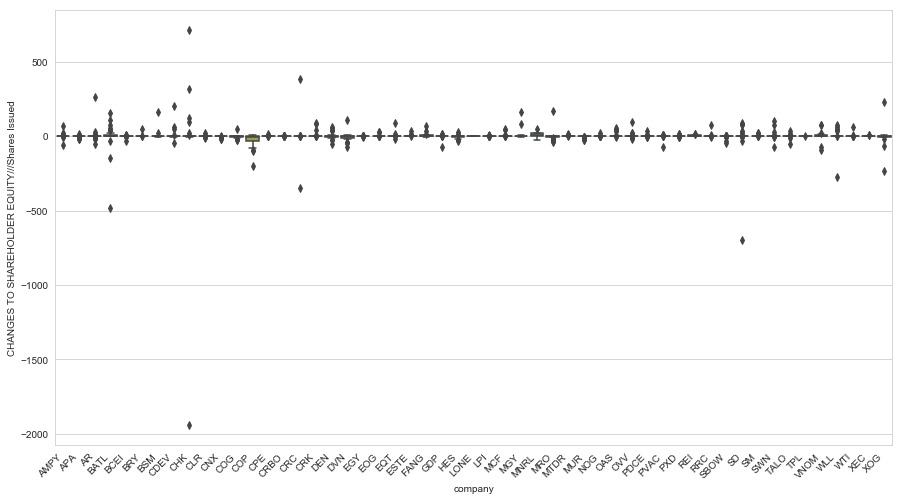

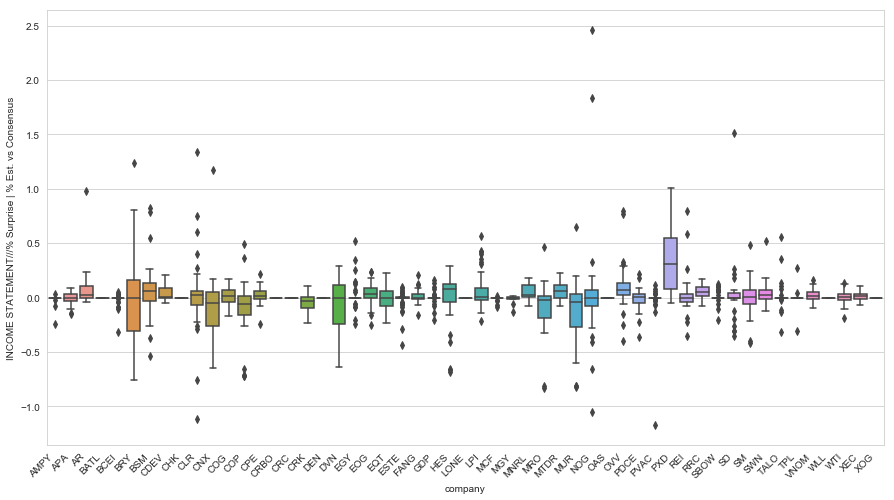

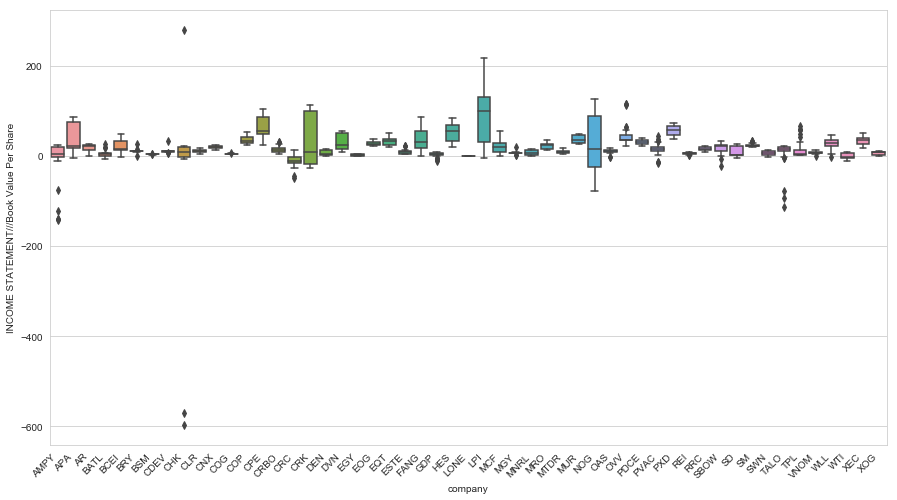

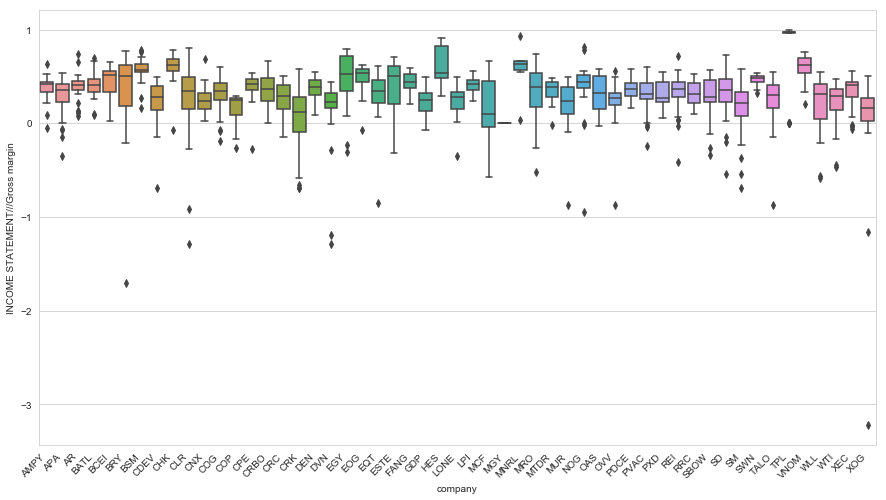

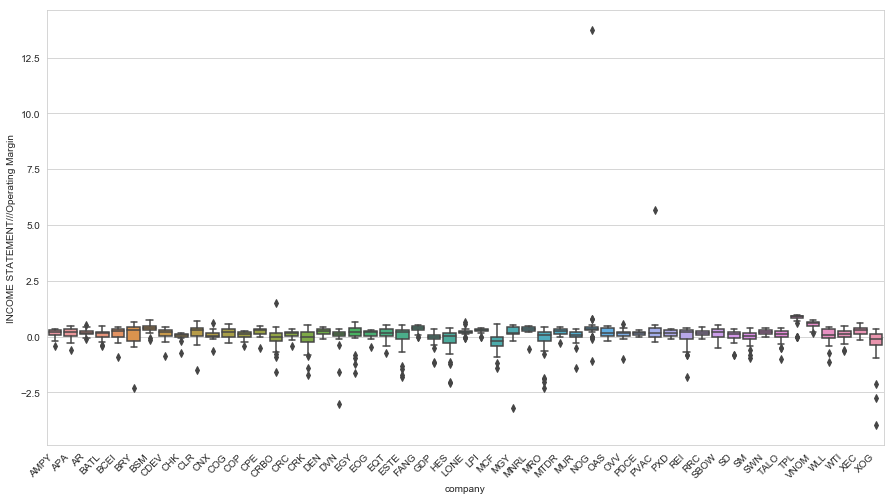

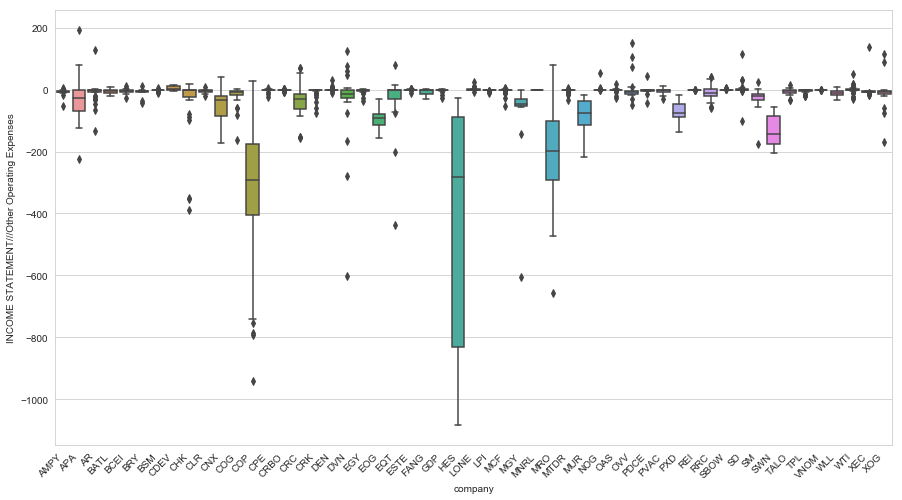

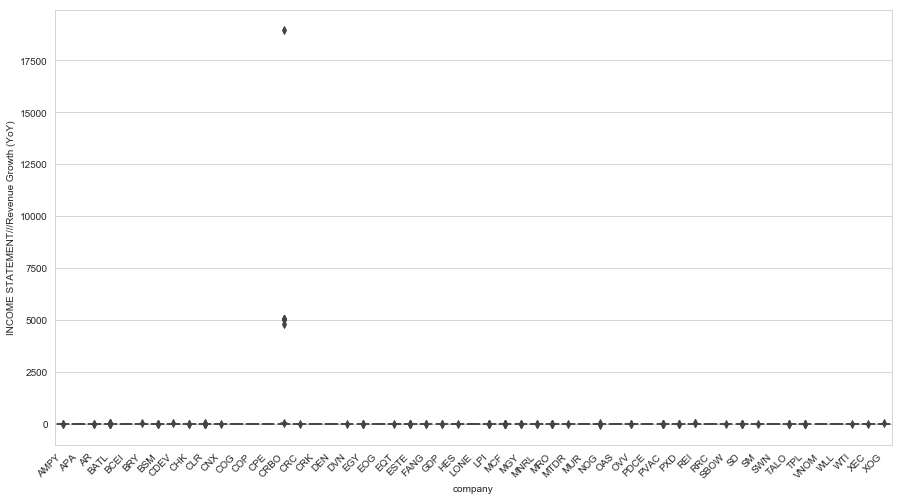

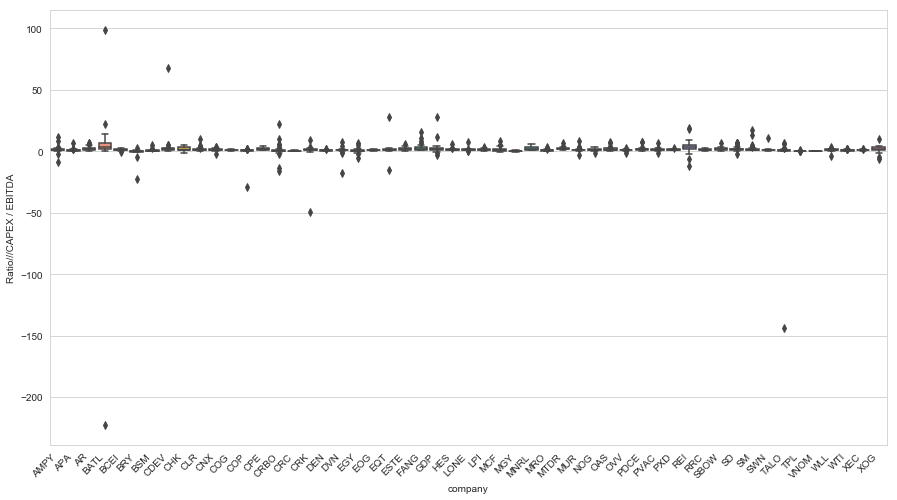

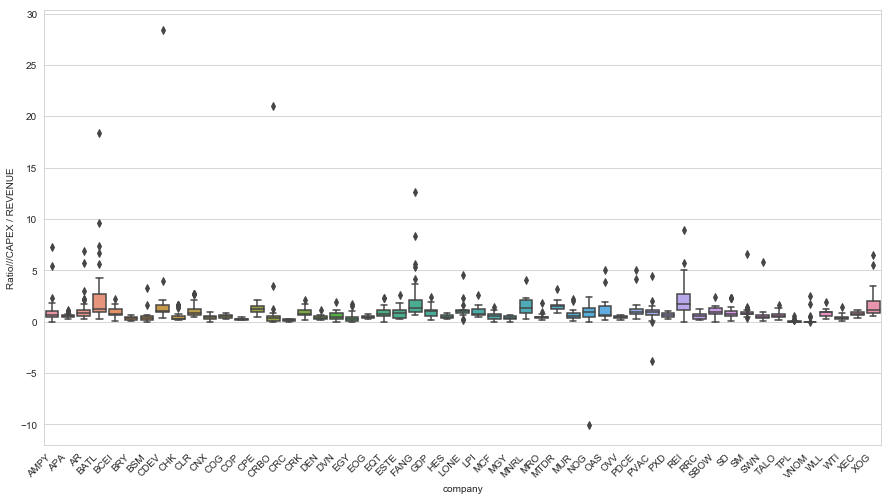

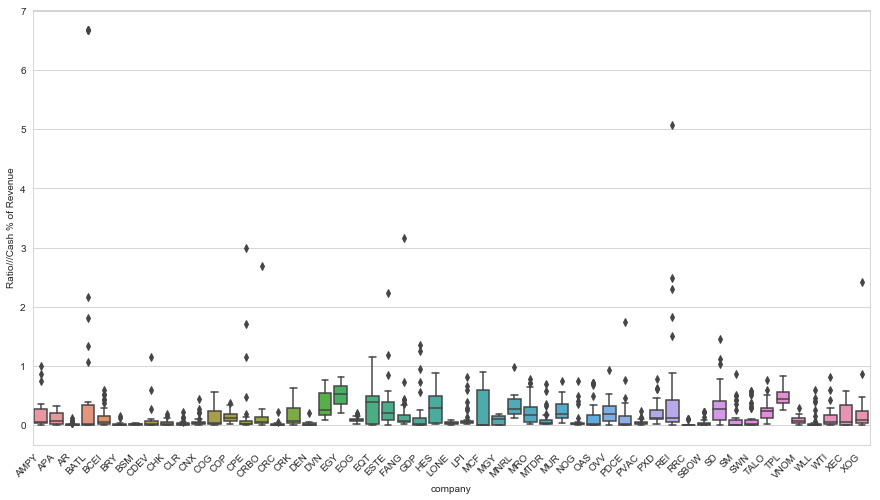

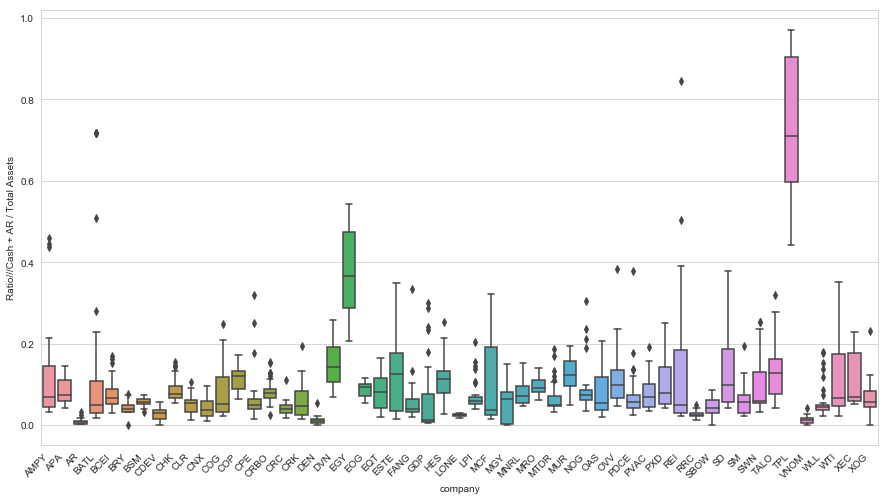

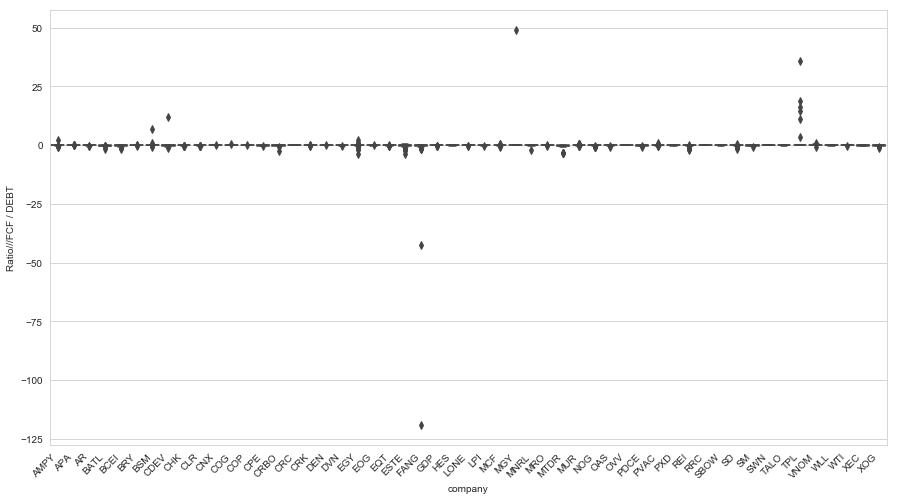

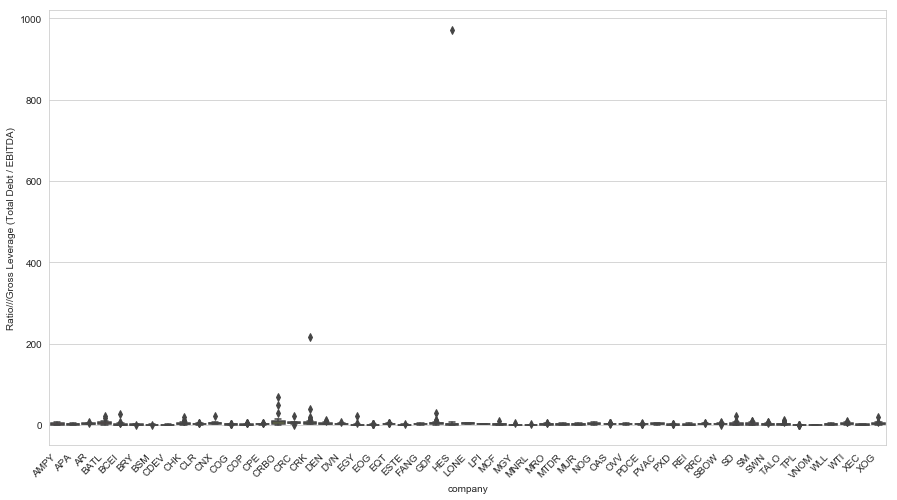

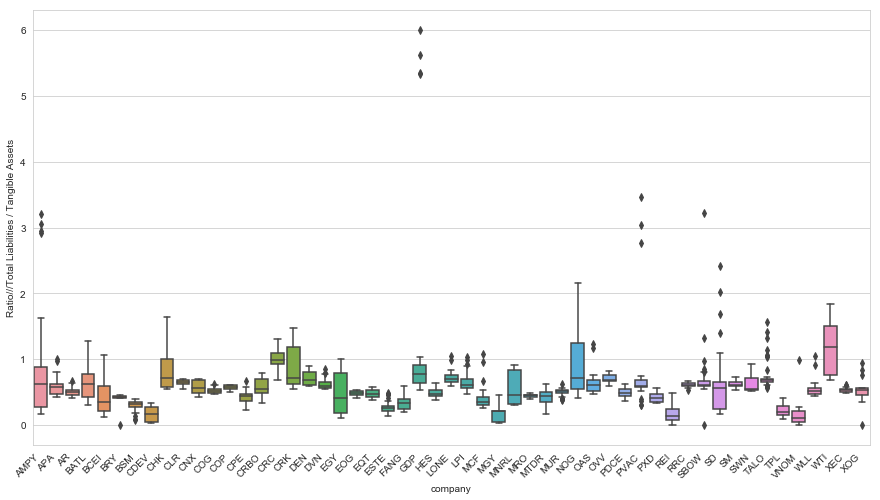

In [21]:
for f in features:
    plt.figure(figsize=(15,8))
    ax = sns.boxplot(x = data_tmp4['company'], y=data_tmp4[f])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.show()

Let's also consider, how metrics change in mean throught the timeline:

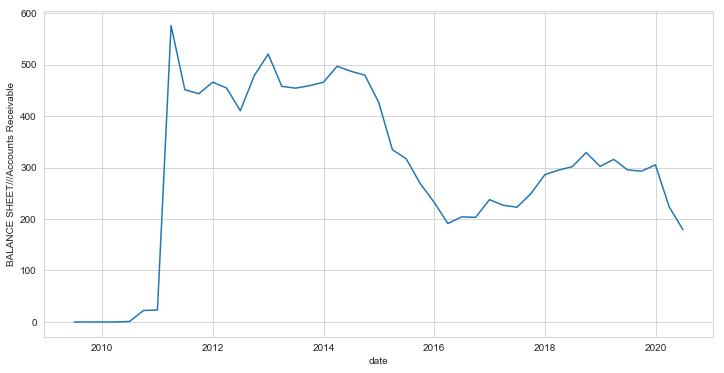

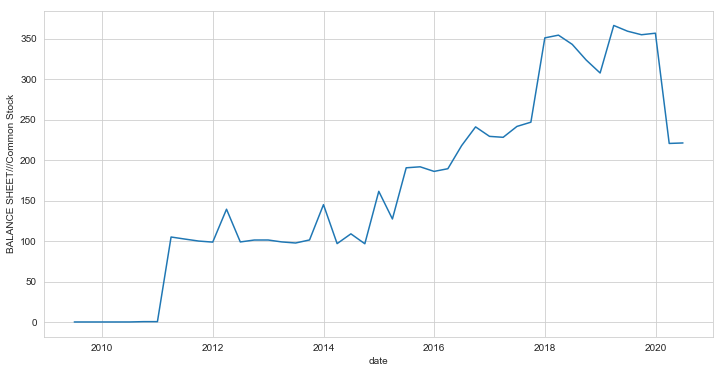

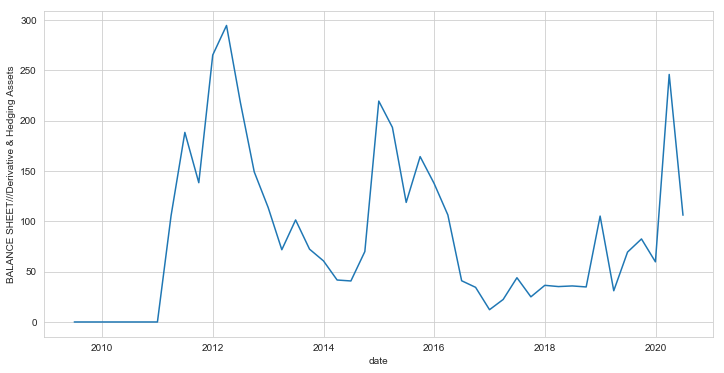

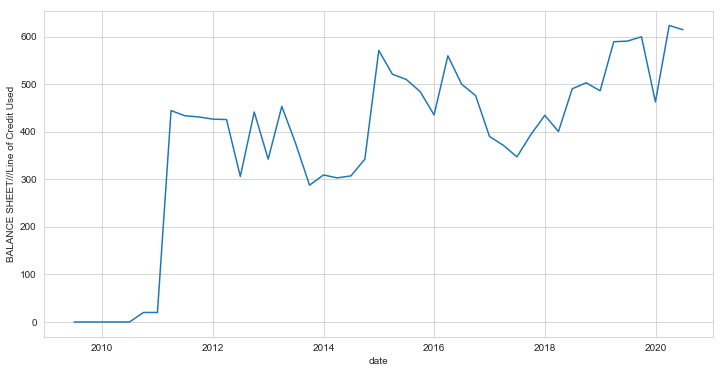

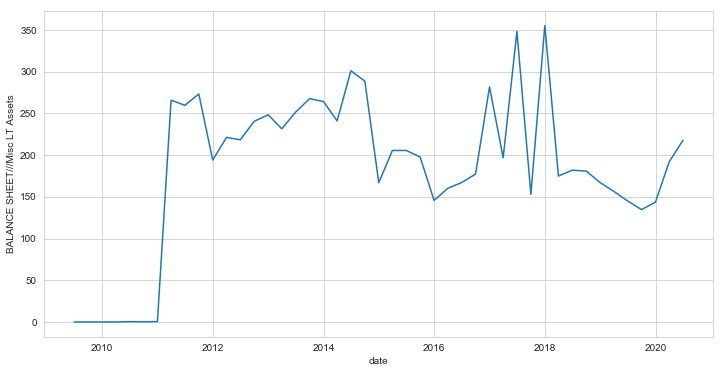

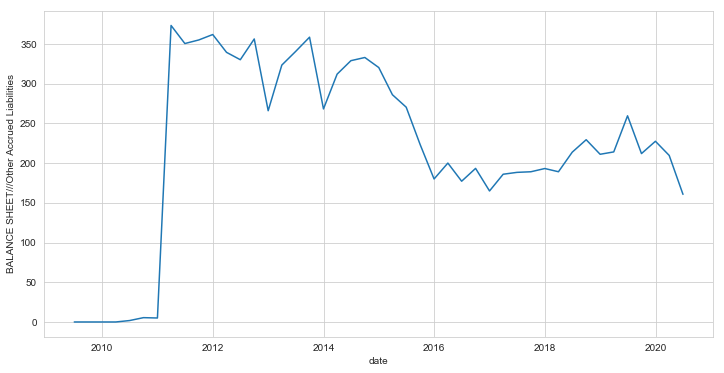

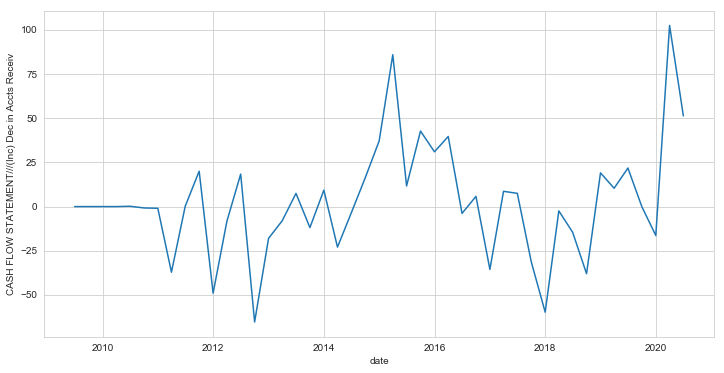

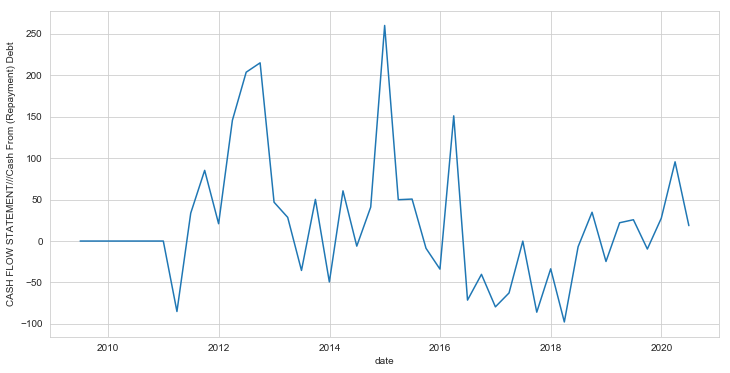

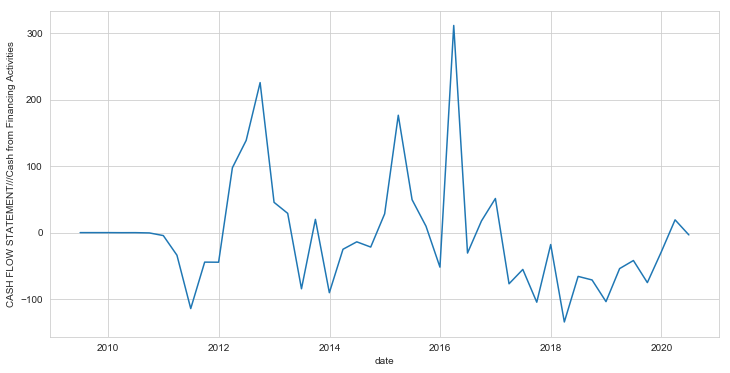

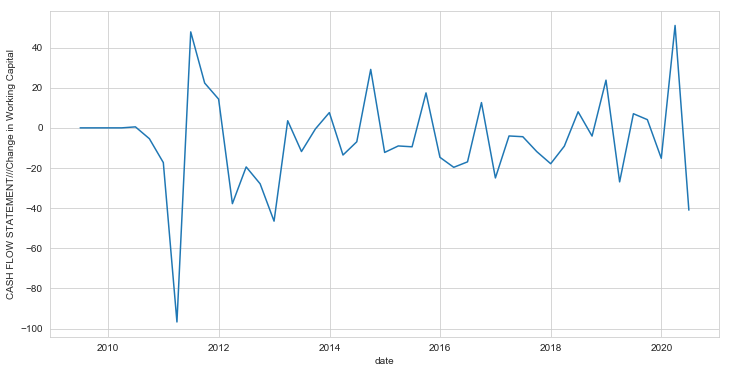

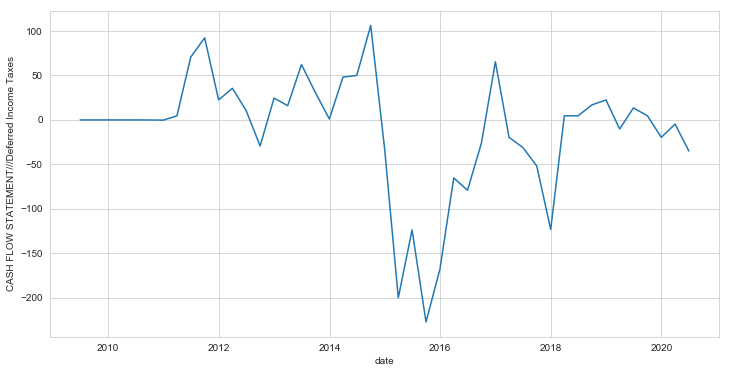

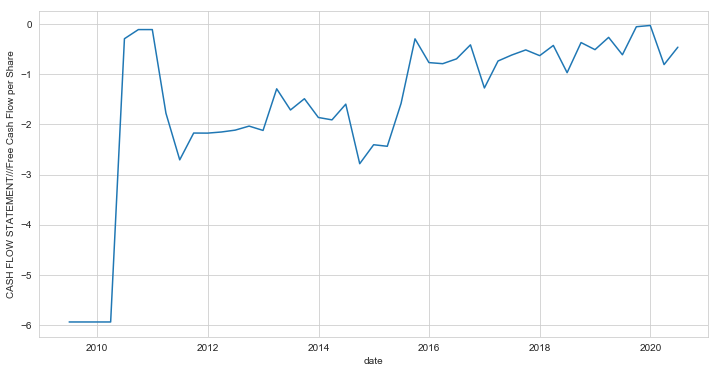

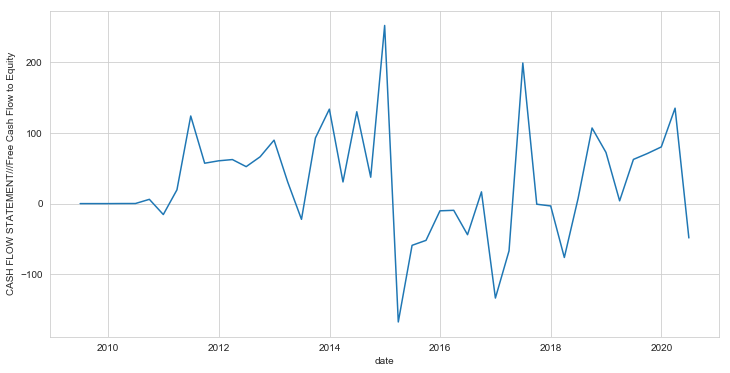

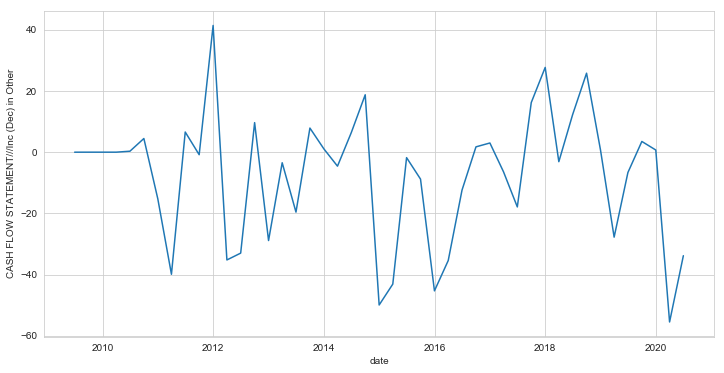

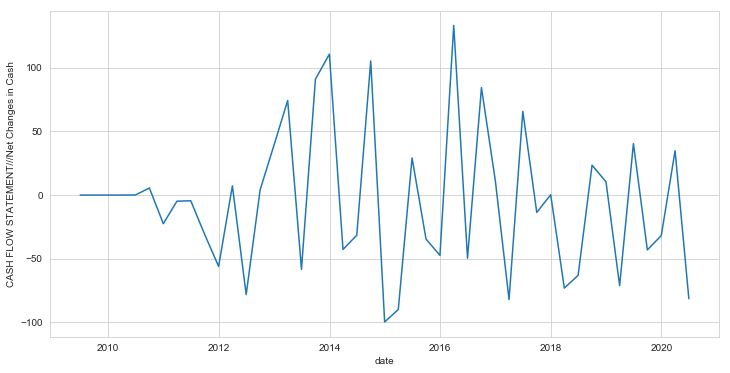

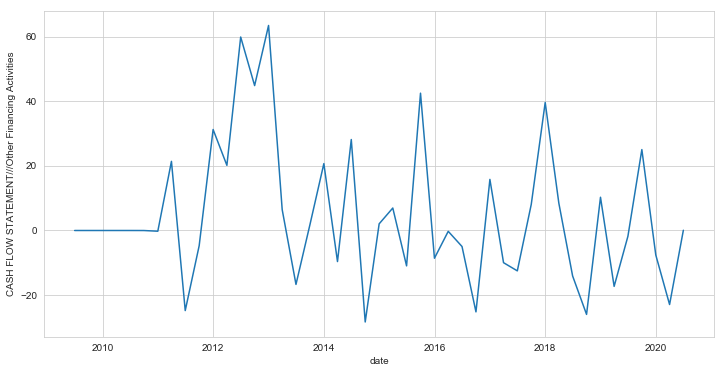

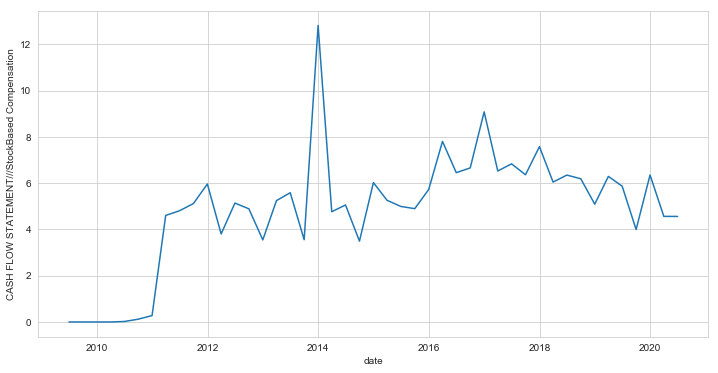

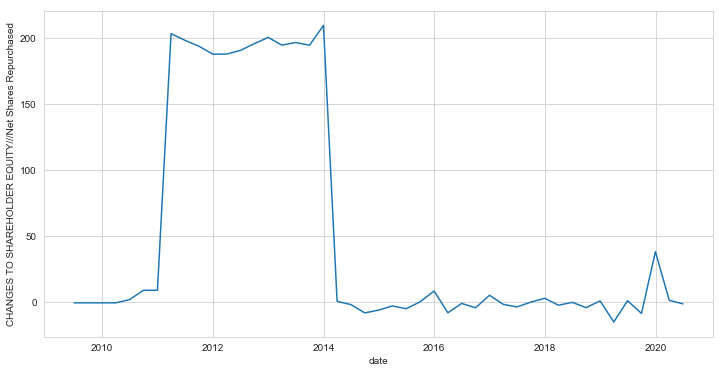

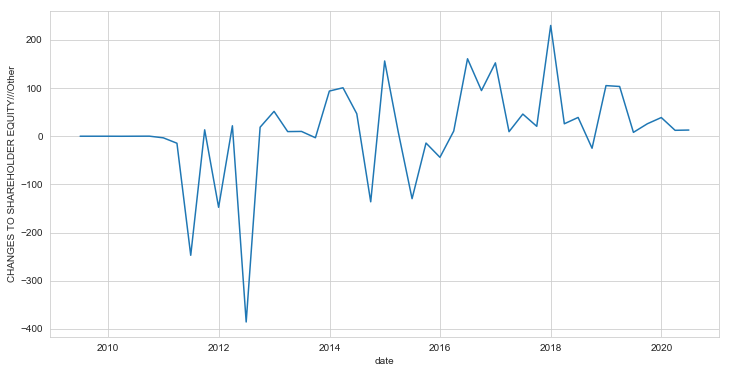

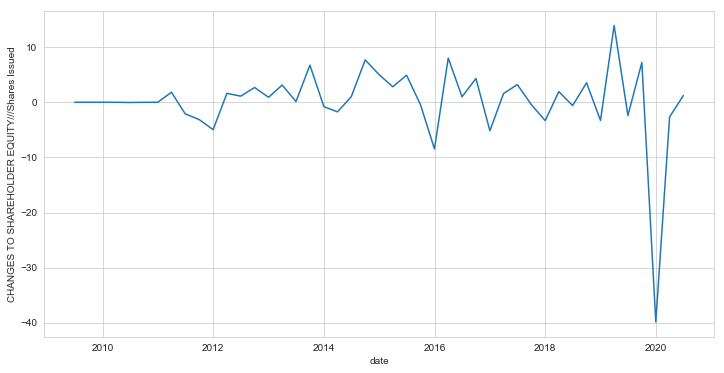

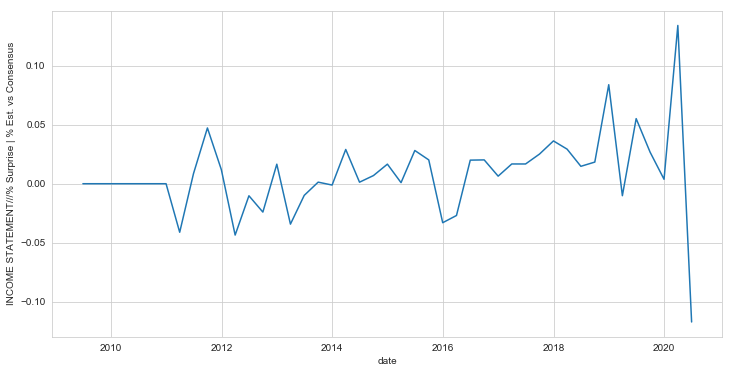

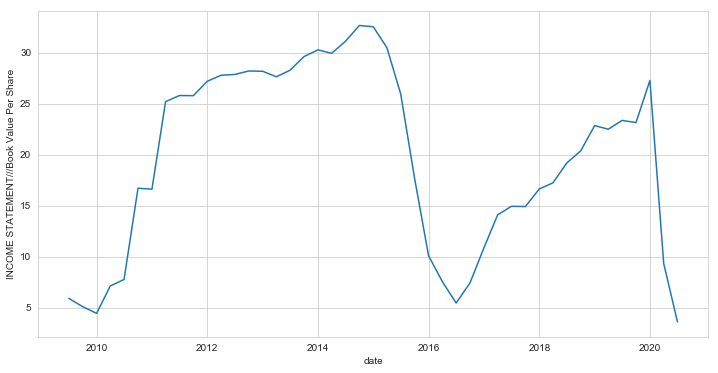

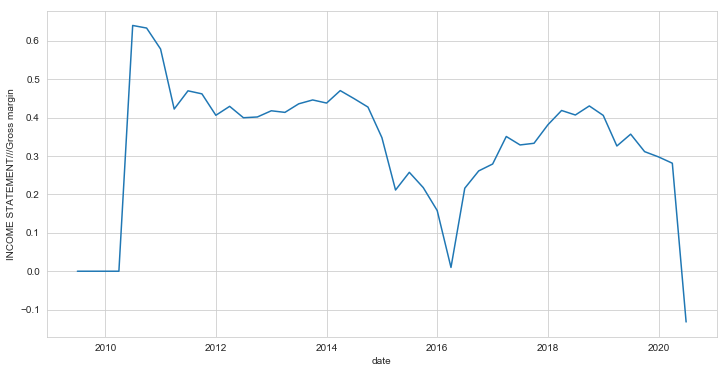

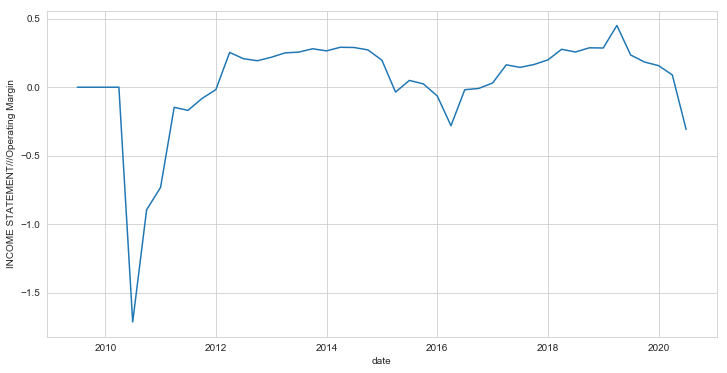

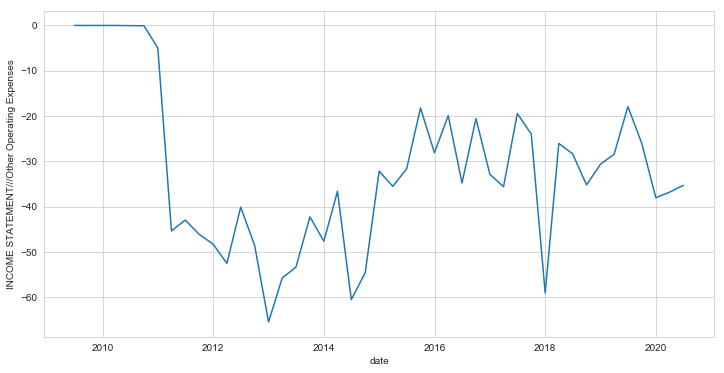

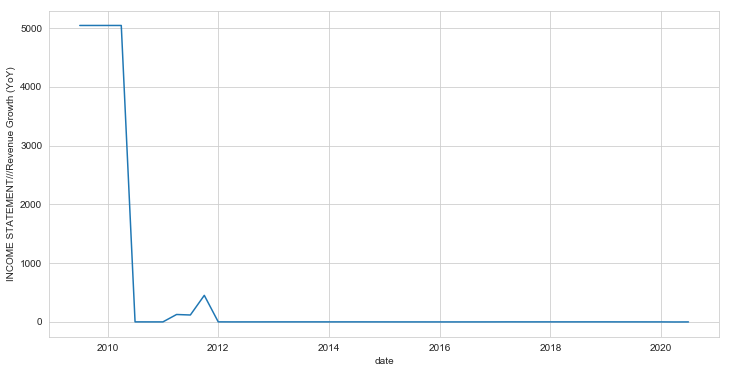

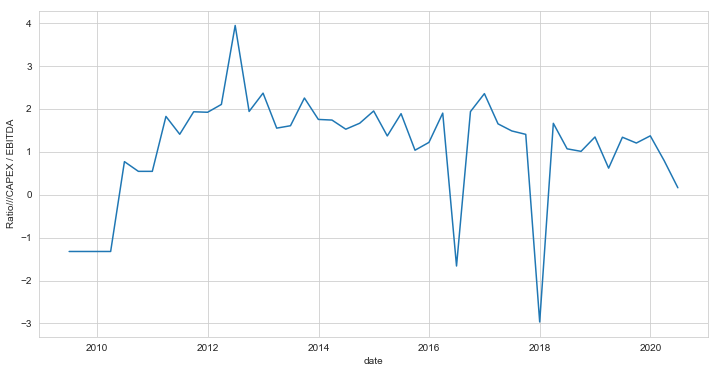

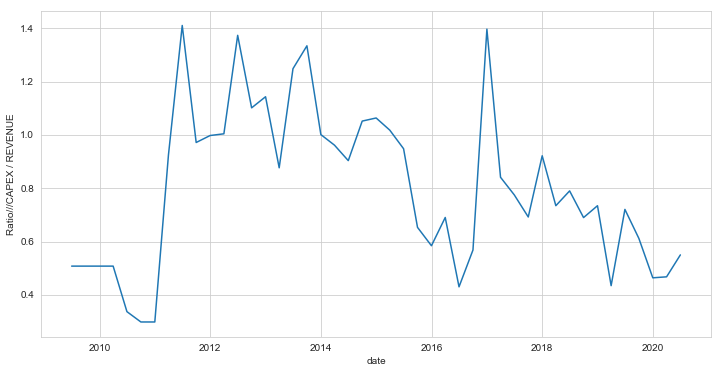

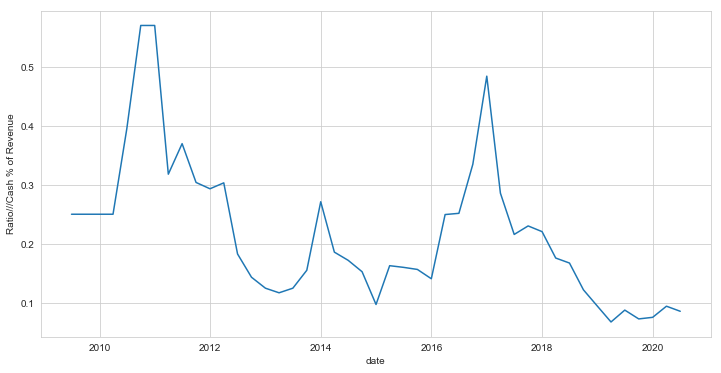

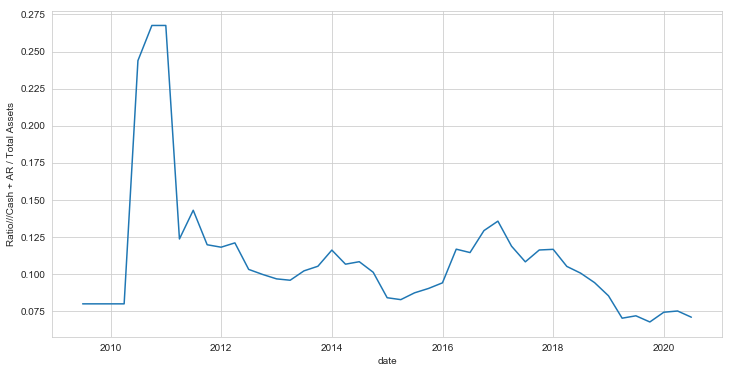

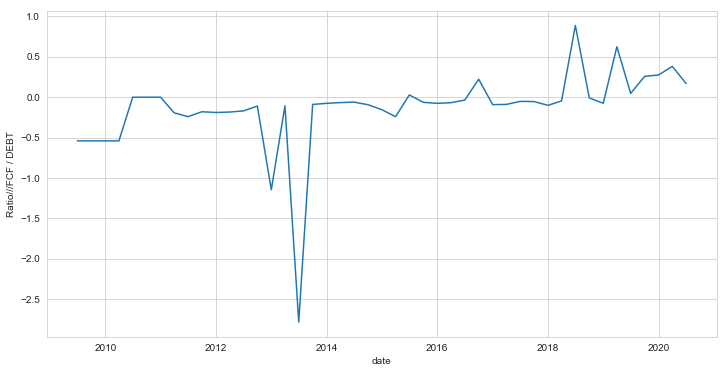

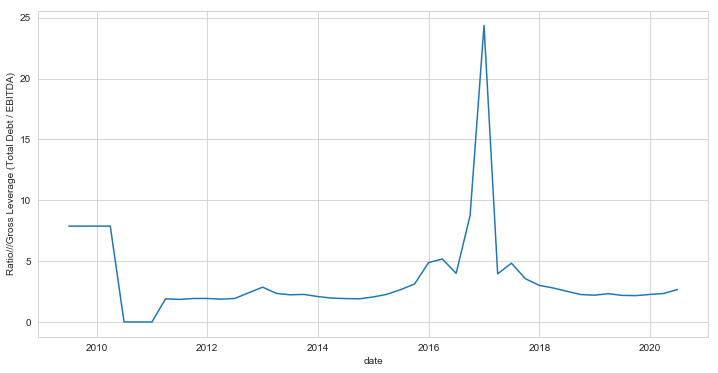

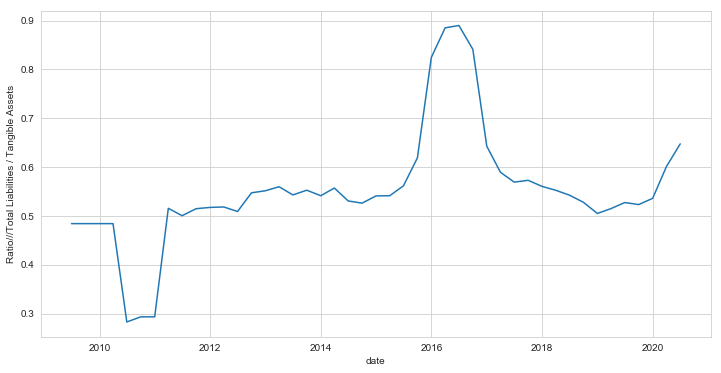

In [26]:
for f in features:
    dt = data_tmp4.loc[:,['date','company',f]].groupby('date').mean()[f]
    ax = sns.lineplot(x=dt.index,y=dt)
    plt.show()

I think that's probably enough for this stage.

__Suggested by my classmate performance metric: SMAPE__

## Test preparation

We make similar steps

In [8]:
data_dir = 'data/oil_gas_train_test'
directory = os.fsencode(data_dir)
rows_27 = pd.DataFrame([])

num_files = 0
row_success = 0
col_success = 0
date_success = 0
comp_names = []
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if re.search("^[A-Z]", filename) is not None:
        comp_names.append(filename)
        num_files+=1
        comp = pd.read_excel(data_dir+'/'+filename)
        if ('INCOME STATEMENT' in list(comp.loc[27,:])) and ('DDM Terminal Value' in list(comp.loc[409,:])):
            row_success+=1
        if comp.iloc[:, 7].isna().all() and comp.iloc[27, 8] == 'INCOME STATEMENT' \
            and comp.iloc[123,8] == 'BALANCE SHEET' and comp.iloc[261,8] == 'CASH FLOW STATEMENT' \
            and comp.iloc[324,8] == 'CHANGES TO SHAREHOLDER EQUITY' and comp.iloc[346,8] == 'Ratios' \
            and comp.iloc[362,8] == 'Valuation':
            col_success+=1
        if (comp.iloc[27,9:] == comp.iloc[123,9:]).all() and (comp.iloc[27,9:] == comp.iloc[324,9:]).all() \
            and (comp.iloc[27,9:] == comp.iloc[261,9:]).all() and (comp.iloc[27,9:] == comp.iloc[346,9:]).all() \
            and (comp.iloc[27,9:] == comp.iloc[362,9:]).all():
            date_success+=1
        
        rows_27 = pd.concat([rows_27, comp.iloc[27,:]], axis=1)

In [9]:
date_success, row_success, col_success

(52, 52, 52)

In [10]:
# let's store indexes of all of the statements
IS_index = 27
BS_index = 123
CFS_index = 261
CTSE_index = 324
R_index = 346
V_index = 362

In [11]:
statement_index = ['INCOME STATEMENT']*(BS_index-IS_index)+ \
['BALANCE SHEET']*(CFS_index-BS_index)+['CASH FLOW STATEMENT']*(CTSE_index-CFS_index)+\
['CHANGES TO SHAREHOLDER EQUITY']*(R_index-CTSE_index)+\
['Ratio']*(V_index-R_index)+['Valuation']*(comp.index[-1]+1-V_index)

In [12]:
comp_data = {}
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if re.search("^[A-Z]", filename) is not None:
        comp = pd.read_excel(data_dir+'/'+filename)
        comp = comp.iloc[27:, 8:]
        # here's the date range
        cols = comp.iloc[0, 1:].values
        comp['STATEMENT'] = statement_index
        comp.drop(index=[IS_index, BS_index, CFS_index, CTSE_index, R_index, V_index], inplace=True)
        comp.index = pd.MultiIndex.from_arrays([comp['STATEMENT'], comp['Unnamed: 8']], names=['STATEMENT','METRIC'])
        comp.drop(columns=['Unnamed: 8', 'STATEMENT'], inplace=True)
        comp.columns = cols
        comp_data[filename.split('.')[0]] = comp

In [13]:
comp_data['AMPY']

2011-03-31 2011-06-30  \
STATEMENT        METRIC                                                   
INCOME STATEMENT Revenue                                   0          0   
                 Consensus:                                0          0   
                 % Surprise | % Est. vs Consensus          0          0   
                 Revenue Growth (YoY)                    NaN        NaN   
                 Cost of Revenue                           0          0   
...                                                      ...        ...   
Valuation        Dividends Per Share (fwd only)          NaN        NaN   
                 Discounted Value (Base)                 NaN        NaN   
                 Discounted Value (Bull)                 NaN        NaN   
                 Discounted Value (Bear)                 NaN        NaN   
                 DDM Terminal Value                      NaN        NaN   

                                                  2011-09-30 2011-12-31  \
STATEMENT        METRIC                                                   
INCOME STATEMENT Revenue                                   0     61.863   
                 Consensus:                                0          0   
                 % Surprise | % Est. vs Consensus          0          0   
                 Revenue Growth (YoY)                    NaN        NaN   
                 Cost of Revenue                           0    -36.854   
...                                                      ...        ...   
Valuation        Dividends Per Share (fwd only)          NaN        NaN   
                 Discounted Value (Base)                 NaN        NaN   
                 Discounted Value (Bull)                 NaN        NaN   
                 Discounted Value (Bear)                 NaN        NaN   
                 DDM Terminal Value                      NaN        NaN   

                                                  2012-03-31 2012-06-30  \
STATEMENT        METRIC                                                   
INCOME STATEMENT Revenue                               48.41     49.259   
                 Consensus:                                0          0   
                 % Surprise | % Est. vs Consensus          0          0   
                 Revenue Growth (YoY)                    NaN        NaN   
                 Cost of Revenue                     -34.628    -33.967   
...                                                      ...        ...   
Valuation        Dividends Per Share (fwd only)          NaN        NaN   
                 Discounted Value (Base)                 NaN        NaN   
                 Discounted Value (Bull)                 NaN        NaN   
                 Discounted Value (Bear)                 NaN        NaN   
                 DDM Terminal Value                      NaN        NaN   

                                                  2012-09-30 2012-12-31  \
STATEMENT        METRIC                                                   
INCOME STATEMENT Revenue                              55.498     89.839   
                 Consensus:                                0          0   
                 % Surprise | % Est. vs Consensus          0          0   
                 Revenue Growth (YoY)                    NaN   0.452225   
                 Cost of Revenue                     -37.426    -50.763   
...                                                      ...        ...   
Valuation        Dividends Per Share (fwd only)          NaN        NaN   
                 Discounted Value (Base)                 NaN        NaN   
                 Discounted Value (Bull)                 NaN        NaN   
                 Discounted Value (Bear)                 NaN        NaN   
                 DDM Terminal Value                      NaN        NaN   

                                                  2013-03-31 2013-06-30  ...  \
STATEMENT        METRIC                                           

#### Issue with REI report

In [14]:
dups = pd.Series(comp_data['REI'].columns).value_counts()
dups[dups>1]

2011-09-30    2
2011-12-31    2
2011-06-30    2
dtype: int64

For some reason the data for REI has duplications, we drop less informative.

In [15]:
comp_data['REI'].columns

DatetimeIndex(['2011-03-31', '2011-06-30', '2011-09-30', '2011-12-31',
               '2011-06-30', '2011-09-30', '2011-12-31', '2012-03-31',
               '2012-06-30', '2013-06-30', '2013-09-30', '2013-12-31',
               '2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31',
               '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
               '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31',
               '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31',
               '2018-03-31', '2018-06-30', '2018-09-30', '2018-12-31',
               '2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31',
               '2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31',
               '2021-03-31', '2021-06-30'],
              dtype='datetime64[ns]', freq=None)

In [16]:
df_temp = comp_data['REI'][datetime.datetime(2011, 6, 30, 0, 0)]
# number of different non-na values in each of the columns
(~df_temp[~(df_temp.iloc[:,0] == df_temp.iloc[:,0])].isna()).sum()

2011-06-30     0
2011-06-30    26
dtype: int64

In [17]:
df_temp = comp_data['REI'][datetime.datetime(2011, 9, 30, 0, 0)]
(~df_temp[~(df_temp.iloc[:,0] == df_temp.iloc[:,0])].isna()).sum()

2011-09-30     0
2011-09-30    23
dtype: int64

In [18]:
df_temp = comp_data['REI'][datetime.datetime(2011, 12, 31, 0, 0)]
(~df_temp[~(df_temp.iloc[:,0] == df_temp.iloc[:,0])].isna()).sum()

2011-12-31     0
2011-12-31    23
dtype: int64

In [19]:
mask = [True]*comp_data['REI'].shape[1]
mask[1] = False
mask[2] = False
mask[3] = False
comp_data['REI'] = comp_data['REI'].iloc[:,mask]

In [20]:
dups = pd.Series(comp_data['REI'].columns).value_counts()
dups[dups>1]

Series([], dtype: int64)

In [21]:
for k in comp_data.keys():
    comp_data[k] = comp_data[k][~comp_data[k].index.duplicated()]

In [22]:
data = pd.concat(comp_data, names=['Company', 'Statement', 'Metric'])

In [23]:
data

2010-06-30  \
Company Statement        Metric                                        
CDEV    INCOME STATEMENT Revenue                                 NaN   
                         Consensus:                              NaN   
                         % Surprise | % Est. vs Consensus        NaN   
                         Revenue Growth (YoY)                    NaN   
                         Cost of Revenue                         NaN   
...                                                              ...   
MCF     Valuation        Dividends Per Share (fwd only)          NaN   
                         Discounted Value (Base)                 NaN   
                         Discounted Value (Bull)                 NaN   
                         Discounted Value (Bear)                 NaN   
                         DDM Terminal Value                      NaN   

                                                          2010-09-30  \
Company Statement        Metric                                        
CDEV    INCOME STATEMENT Revenue                                 NaN   
                         Consensus:                              NaN   
                         % Surprise | % Est. vs Consensus        NaN   
                         Revenue Growth (YoY)                    NaN   
                         Cost of Revenue                         NaN   
...                                                              ...   
MCF     Valuation        Dividends Per Share (fwd only)          NaN   
                         Discounted Value (Base)                 NaN   
                         Discounted Value (Bull)                 NaN   
                         Discounted Value (Bear)                 NaN   
                         DDM Terminal Value                      NaN   

                                                          2010-12-31  \
Company Statement        Metric                                        
CDEV    INCOME STATEMENT Revenue                                 NaN   
                         Consensus:                              NaN   
                         % Surprise | % Est. vs Consensus        NaN   
                         Revenue Growth (YoY)                    NaN   
                         Cost of Revenue                         NaN   
...                                                              ...   
MCF     Valuation        Dividends Per Share (fwd only)          NaN   
                         Discounted Value (Base)                 NaN   
                         Discounted Value (Bull)                 NaN   
                         Discounted Value (Bear)                 NaN   
                         DDM Terminal Value                      NaN   

                                                          2011-03-31  \
Company Statement        Metric                                        
CDEV    INCOME STATEMENT Revenue                                   0   
                         Consensus:                                0   
                         % Surprise | % Est. vs Consensus          0   
                         Revenue Growth (YoY)                    NaN   
                         Cost of Revenue                           0   
...                                                              ...   
MCF     Valuation        Dividends Per Share (fwd only)          NaN   
                         Discounted Value (Base)                 NaN   
                         Discounted Value (Bull)                 NaN   
                         Discounted Value (Bear)                 NaN   
                         DDM Terminal Value                      NaN   

                                                          2011-06-30  \
Company Statement        Metric                                        
CDEV    INCOME STATEMENT Revenue                                   0   
                         Consensus:                                0   
                      

In [26]:
idx = pd.IndexSlice
data_tmp = pd.DataFrame([])
for cmp in data.index.levels[0]:
    ttt = data.loc[idx[cmp,:,:]]
    ttt.index=ttt.index.droplevel(0)
    ttt = ttt.T
    ttt.columns = ttt.columns.tolist()
    ttt['date'] = ttt.index
    ttt['company'] = cmp
    ttt = ttt[ttt.columns[-2:].tolist() + ttt.columns[:-2].tolist()]
    ttt.reset_index(drop=True, inplace=True)
    data_tmp = pd.concat([data_tmp, ttt],axis=0)
data_tmp = data_tmp.rename(columns = {x: str(x[0]) + '///' + str(x[1]) for x in data_tmp.columns[2:]})
data_tmp.reset_index(drop=True, inplace=True)

We convert their types

In [27]:
for c in data_tmp.columns[2:]:
    #print(c)
    try:
        data_tmp[c] = pd.to_numeric(data_tmp[c])
    except:
        pass

Let's consider remaining object types

In [28]:
obj_comps = data_tmp.columns[data_tmp.dtypes=='object'].tolist()
obj_comps.remove('company')

In [29]:
pd.to_numeric(data_tmp[obj_comps[0]])

ValueError: Unable to parse string "n.a." at position 48

In [30]:
data_tmp[obj_comps[0]][data_tmp[obj_comps[0]]=="#N/A Field Not Applicable"] = np.nan

/Users/danilculkov/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
data_tmp[obj_comps[0]] = pd.to_numeric(data_tmp[obj_comps[0]])

ValueError: Unable to parse string "n.a." at position 48

In [33]:
data_tmp[obj_comps[1]][data_tmp[obj_comps[1]]=="n.a."] = np.nan

/Users/danilculkov/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
data_tmp[obj_comps[1]] = pd.to_numeric(data_tmp[obj_comps[1]])

In [35]:
data_tmp[obj_comps[2]][data_tmp[obj_comps[2]]=="n.a."] = np.nan

/Users/danilculkov/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
data_tmp[obj_comps[2]] = pd.to_numeric(data_tmp[obj_comps[2]])

ValueError: Unable to parse string "#N/A Field Not Applicable" at position 1443

In [37]:
data_tmp[obj_comps[3]][data_tmp[obj_comps[3]]=="n.a."] = np.nan

/Users/danilculkov/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
data_tmp[obj_comps[3]] = pd.to_numeric(data_tmp[obj_comps[3]])

In [39]:
data_tmp[obj_comps[4]][data_tmp[obj_comps[4]]=="n.a."] = np.nan

/Users/danilculkov/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
data_tmp[obj_comps[4]] = pd.to_numeric(data_tmp[obj_comps[4]])

In [41]:
data_tmp.dtypes.value_counts()

float64           318
object              4
datetime64[ns]      1
dtype: int64

Now we leave only selected columns

In [45]:
data_train = pd.read_excel('data/data_tmp4.xlsx',index_col=0)
data_train.head()

date company  BALANCE SHEET///Accounts Receivable  \
0 2011-12-31    AMPY                               27.454   
1 2012-03-31    AMPY                               21.830   
2 2012-06-30    AMPY                               19.567   
3 2012-09-30    AMPY                               23.307   
4 2012-12-31    AMPY                               39.484   

   BALANCE SHEET///Common Stock  BALANCE SHEET///Derivative & Hedging Assets  \
0                         0.000                                        4.957   
1                         0.000                                        0.517   
2                         0.665                                       12.038   
3                         0.665                                        0.987   
4                         0.666                                        5.695   

   BALANCE SHEET///Line of Credit Used  BALANCE SHEET///Misc LT Assets  \
0                                234.8                           1.879   
1                                234.8                           1.663   
2                                151.7                           3.660   
3                                250.0                          13.454   
4                                344.0                          25.413   

   BALANCE SHEET///Other Accrued Liabilities  \
0                                      0.000   
1                                     50.477   
2                                     62.985   
3                                     64.507   
4                                     98.649   

   CASH FLOW STATEMENT///(Inc) Dec in Accts Receiv  \
0                                           -3.905   
1                                            5.624   
2                                            2.263   
3                                           -3.740   
4                                          -26.992   

   CASH FLOW STATEMENT///Cash From (Repayment) Debt  ...  \
0                                              36.2  ...   
1                                               0.0  ...   
2                                             -83.1  ...   
3                                              64.6  ...   
4                                             477.7  ...   

   INCOME STATEMENT///Other Operating Expenses  INCOME STATEMENT///Revenue  \
0                                       -3.902                      61.863   
1                                       -5.376                      48.410   
2                                       -6.272                      49.259   
3                                       -6.450                      55.498   
4                                       -6.823                      89.839   

   INCOME STATEMENT///Revenue Growth (YoY)  Ratio///CAPEX / EBITDA  \
0                                 0.115635                2.386183   
1                                 0.115635                2.386183   
2                                 0.115635                3.498998   
3                                 0.115635                2.928185   
4                                 0.452225                8.194718   

   Ratio///CAPEX / REVENUE  Ratio///Cash % of Revenue  \
0                 1.496922                   0.044009   
1                 1.496922                   0.044009   
2                 2.269210                   0.053065   
3                 1.813218                   0.021738   
4                 5.440098                   0.077685   

   Ratio///Cash + AR / Total Assets  Ratio///FCF / DEBT  \
0                          0.045053           -0.162479   
1                          0.045053           -0.162479   
2                          0.039503           -0.567779   
3                          0.032677           -0.304730   
4                          0.034657           -0.642888   

   Ratio///Gross Leverage (Total Debt / EBITDA)  \
0                                      2.078175   
1                                      2.078175   

In [46]:
target = ['INCOME STATEMENT///Operating Income', 'INCOME STATEMENT///Revenue']

In [52]:
data_tmp.drop(columns=data_tmp.columns[~data_tmp.columns.isin(data_train.columns)],inplace=True)

In [53]:
data_tmp.dtypes.value_counts()

float64           35
datetime64[ns]     1
object             1
dtype: int64

Wee see that most of the nas come from the time before 2012. There's definitely no sense to consider samples without actual target values:

In [54]:
data_tmp = data_tmp[~np.any(data_tmp[target].isna(),axis=1)]

In [55]:
data_tmp

date company  INCOME STATEMENT///Revenue  \
3    2011-03-31    CDEV                       0.000   
4    2011-06-30    CDEV                       0.000   
5    2011-09-30    CDEV                       0.000   
6    2011-12-31    CDEV                       0.000   
7    2012-03-31    CDEV                       0.000   
...         ...     ...                         ...   
2335 2020-06-30     MCF                      17.842   
2336 2020-09-30     MCF                      31.348   
2337 2020-12-31     MCF                      29.157   
2338 2021-03-31     MCF                      59.950   
2339 2021-06-30     MCF                      83.640   

      INCOME STATEMENT///% Surprise | % Est. vs Consensus  \
3                                              0.000000     
4                                              0.000000     
5                                              0.000000     
6                                              0.000000     
7                                              0.000000     
...                                                 ...     
2335                                           0.000000     
2336                                           0.000000     
2337                                           0.000000     
2338                                          -0.054416     
2339                                           0.213933     

      INCOME STATEMENT///Revenue Growth (YoY)  \
3                                         NaN   
4                                         NaN   
5                                         NaN   
6                                         NaN   
7                                         NaN   
...                                       ...   
2335                                 0.398057   
2336                                 1.498446   
2337                                -0.216062   
2338                                 0.734012   
2339                                 3.687815   

      INCOME STATEMENT///Gross margin  \
3                            0.000000   
4                            0.000000   
5                            0.000000   
6                            0.000000   
7                            0.000000   
...                               ...   
2335                        -0.245993   
2336                         0.255455   
2337                         0.212127   
2338                         0.389141   
2339                         0.426518   

      INCOME STATEMENT///Other Operating Expenses  \
3                                           0.000   
4                                           0.000   
5                                           0.000   
6                                           0.000   
7                                           0.000   
...                                           ...   
2335                                      -11.173   
2336                                        0.643   
2337                                        0.613   
2338                                        1.650   
2339                                        0.313   

      INCOME STATEMENT///Operating Income  \
3                                   0.000   
4                                   0.000   
5                                   0.000   
6                                   0.000   
7                                   0.000   
...                                   ...   
2335                              -21.275   
2336                                2.521   
2337                               -0.874   
2338                               13.620   
2339                               22.504   

      INCOME STATEMENT///Operating Margin  \
3                                0.000000   
4                                0.000000   
5                                0.000000   
6                                0.000000   
7                                0.000000   
...                                   ...   
2335                            -1.192411 

In [56]:
data_tmp.isna().sum()[data_tmp.isna().sum()>0]

INCOME STATEMENT///Revenue Growth (YoY)                   411
BALANCE SHEET///Line of Credit Used                       205
CASH FLOW STATEMENT///Free Cash Flow per Share            388
CHANGES TO SHAREHOLDER EQUITY///Other                     104
CHANGES TO SHAREHOLDER EQUITY///Shares Issued             104
CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased    309
Ratio///CAPEX / REVENUE                                   205
Ratio///CAPEX / EBITDA                                    205
Ratio///FCF / DEBT                                        205
Ratio///Gross Leverage (Total Debt / EBITDA)              228
Ratio///Total Liabilities / Tangible Assets               247
Ratio///Cash + AR / Total Assets                          205
Ratio///Cash % of Revenue                                 205
dtype: int64

It's much more better! Consider now zero target values:

In [57]:
data_tmp[np.all(data_tmp[target]==0,axis=1)]

date company  INCOME STATEMENT///Revenue  \
3    2011-03-31    CDEV                         0.0   
4    2011-06-30    CDEV                         0.0   
5    2011-09-30    CDEV                         0.0   
6    2011-12-31    CDEV                         0.0   
7    2012-03-31    CDEV                         0.0   
...         ...     ...                         ...   
1695 2017-12-31     BRY                         0.0   
2208 2011-03-31     REI                         0.0   
2210 2011-09-30     REI                         0.0   
2211 2011-12-31     REI                         0.0   
2212 2012-03-31     REI                         0.0   

      INCOME STATEMENT///% Surprise | % Est. vs Consensus  \
3                                                   0.0     
4                                                   0.0     
5                                                   0.0     
6                                                   0.0     
7                                                   0.0     
...                                                 ...     
1695                                                0.0     
2208                                                0.0     
2210                                                0.0     
2211                                                0.0     
2212                                                0.0     

      INCOME STATEMENT///Revenue Growth (YoY)  \
3                                         NaN   
4                                         NaN   
5                                         NaN   
6                                         NaN   
7                                         NaN   
...                                       ...   
1695                                      NaN   
2208                                      NaN   
2210                                      NaN   
2211                                      NaN   
2212                                      NaN   

      INCOME STATEMENT///Gross margin  \
3                                 0.0   
4                                 0.0   
5                                 0.0   
6                                 0.0   
7                                 0.0   
...                               ...   
1695                              0.0   
2208                              0.0   
2210                              0.0   
2211                              0.0   
2212                              0.0   

      INCOME STATEMENT///Other Operating Expenses  \
3                                             0.0   
4                                             0.0   
5                                             0.0   
6                                             0.0   
7                                             0.0   
...                                           ...   
1695                                          0.0   
2208                                          0.0   
2210                                          0.0   
2211                                          0.0   
2212                                          0.0   

      INCOME STATEMENT///Operating Income  \
3                                     0.0   
4                                     0.0   
5                                     0.0   
6                                     0.0   
7                                     0.0   
...                                   ...   
1695                                  0.0   
2208                                  0.0   
2210                                  0.0   
2211                                  0.0   
2212                                  0.0   

      INCOME STATEMENT///Operating Margin  \
3                                     0.0   
4                                     0.0   
5                                     0.0   
6                                     0.0   
7                                     0.0   
...                                   ...   
1695                                  0.0 

There's no sense in such samples, so we drop them:

In [58]:
data_tmp = data_tmp[~np.all(data_tmp[target]==0,axis=1)]

In [59]:
data_tmp

date company  INCOME STATEMENT///Revenue  \
23   2016-03-31    CDEV                      23.750   
24   2016-06-30    CDEV                      29.390   
25   2016-09-30    CDEV                      29.273   
26   2016-12-31    CDEV                      30.771   
27   2017-03-31    CDEV                      60.700   
...         ...     ...                         ...   
2335 2020-06-30     MCF                      17.842   
2336 2020-09-30     MCF                      31.348   
2337 2020-12-31     MCF                      29.157   
2338 2021-03-31     MCF                      59.950   
2339 2021-06-30     MCF                      83.640   

      INCOME STATEMENT///% Surprise | % Est. vs Consensus  \
23                                             0.000000     
24                                             0.000000     
25                                             0.121571     
26                                            -0.000942     
27                                             0.126160     
...                                                 ...     
2335                                           0.000000     
2336                                           0.000000     
2337                                           0.000000     
2338                                          -0.054416     
2339                                           0.213933     

      INCOME STATEMENT///Revenue Growth (YoY)  \
23                                        NaN   
24                                        NaN   
25                                        NaN   
26                                        NaN   
27                                   1.555789   
...                                       ...   
2335                                 0.398057   
2336                                 1.498446   
2337                                -0.216062   
2338                                 0.734012   
2339                                 3.687815   

      INCOME STATEMENT///Gross margin  \
23                          -0.150274   
24                           0.098843   
25                           0.134732   
26                           0.277209   
27                           0.310231   
...                               ...   
2335                        -0.245993   
2336                         0.255455   
2337                         0.212127   
2338                         0.389141   
2339                         0.426518   

      INCOME STATEMENT///Other Operating Expenses  \
23                                          0.000   
24                                         -0.242   
25                                         -0.871   
26                                          3.253   
27                                          0.887   
...                                           ...   
2335                                      -11.173   
2336                                        0.643   
2337                                        0.613   
2338                                        1.650   
2339                                        0.313   

      INCOME STATEMENT///Operating Income  \
23                                 -6.105   
24                                  0.056   
25                                 -1.775   
26                                 -1.932   
27                                  7.653   
...                                   ...   
2335                              -21.275   
2336                                2.521   
2337                               -0.874   
2338                               13.620   
2339                               22.504   

      INCOME STATEMENT///Operating Margin  \
23                              -0.257053   
24                               0.001905   
25                              -0.060636   
26                              -0.062786   
27                               0.126079   
...                                   ...   
2335                            -1.192411 

In [60]:
data_tmp.isna().sum()[data_tmp.isna().sum()>0]

INCOME STATEMENT///Revenue Growth (YoY)                   212
BALANCE SHEET///Line of Credit Used                       161
CASH FLOW STATEMENT///Free Cash Flow per Share            189
CHANGES TO SHAREHOLDER EQUITY///Other                     104
CHANGES TO SHAREHOLDER EQUITY///Shares Issued             104
CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased    265
Ratio///CAPEX / REVENUE                                   161
Ratio///CAPEX / EBITDA                                    161
Ratio///FCF / DEBT                                        161
Ratio///Gross Leverage (Total Debt / EBITDA)              184
Ratio///Total Liabilities / Tangible Assets               161
Ratio///Cash + AR / Total Assets                          161
Ratio///Cash % of Revenue                                 161
dtype: int64

Consider now these features separetely:

__BALANCE SHEET///Line of Credit Used__

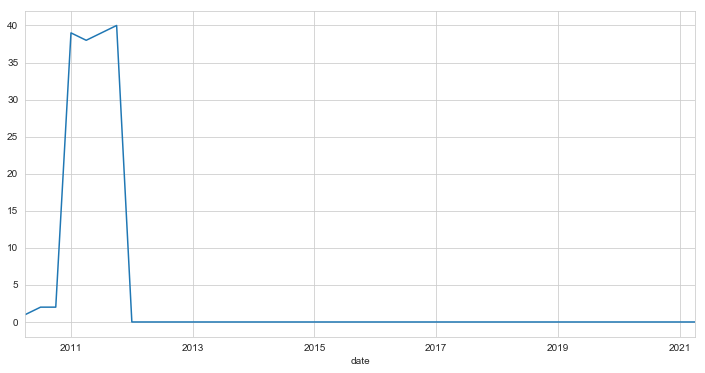

In [61]:
_ = data_tmp[['date', 'company','BALANCE SHEET///Line of Credit Used']].groupby('date').aggregate(lambda x: sum(x.isna()))['BALANCE SHEET///Line of Credit Used'].plot()

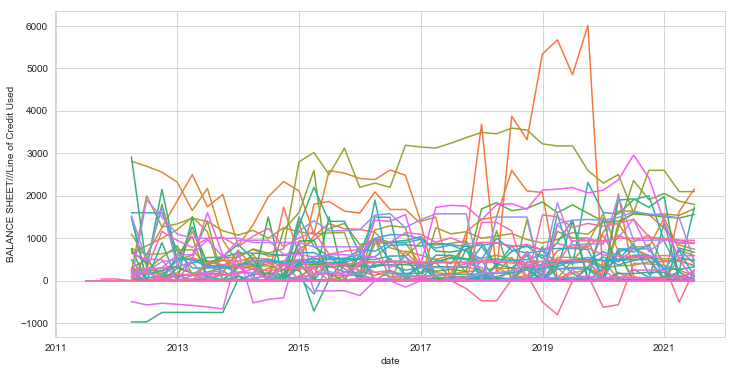

In [62]:
_ = sns.lineplot(x=data_tmp['date'], y = data_tmp['BALANCE SHEET///Line of Credit Used'], hue=data_tmp['company'], legend=False)

Let's take the values from the nearest date (backfill)

In [63]:
for c in data_tmp['company'].unique():
    data_tmp.loc[data_tmp['company']==c,'BALANCE SHEET///Line of Credit Used'] =\
    data_tmp.loc[data_tmp['company']==c,'BALANCE SHEET///Line of Credit Used'].fillna(method='backfill')

/Users/danilculkov/opt/anaconda3/envs/practice/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [64]:
data_tmp['BALANCE SHEET///Line of Credit Used'].isna().sum()

0

__CASH FLOW STATEMENT///Free Cash Flow per Share__

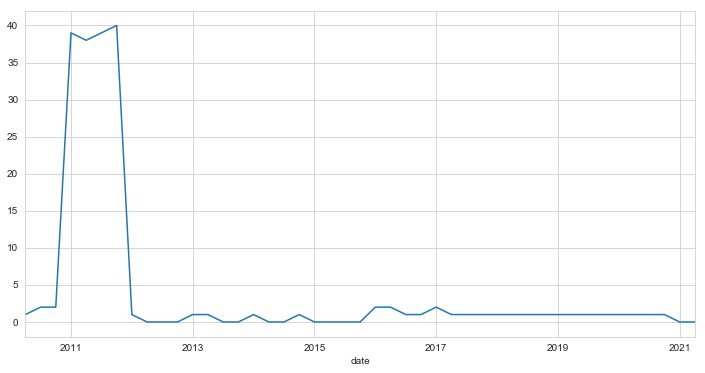

In [65]:
_ = data_tmp[['date', 'company','CASH FLOW STATEMENT///Free Cash Flow per Share']].groupby('date').aggregate(lambda x: sum(x.isna()))['CASH FLOW STATEMENT///Free Cash Flow per Share'].plot()

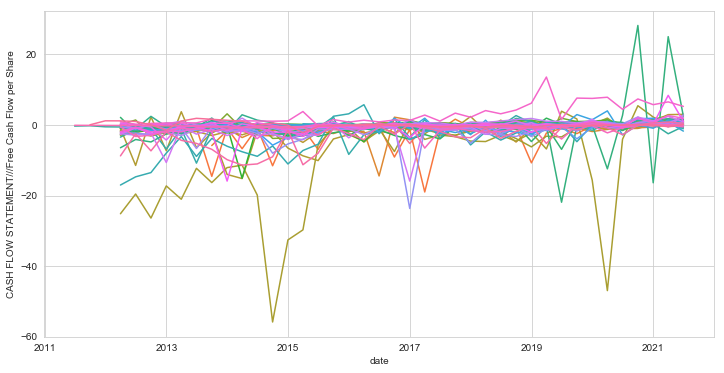

In [66]:
_ = sns.lineplot(x=data_tmp['date'], y = data_tmp['CASH FLOW STATEMENT///Free Cash Flow per Share'], hue=data_tmp['company'], legend=False)

Let's fill in this way:

* Before 2012 with backfill
* Starting from 2012 with mean

In [68]:
for c in data_tmp['company'].unique():
    m = data_tmp.loc[(data_tmp['date'].dt.year>=2012)&(data_tmp['company']==c),
                      'CASH FLOW STATEMENT///Free Cash Flow per Share'].mean()
    data_tmp.loc[(data_tmp['date'].dt.year>=2012)&(data_tmp['company']==c),
                  'CASH FLOW STATEMENT///Free Cash Flow per Share']=\
    data_tmp.loc[(data_tmp['date'].dt.year>=2012)&(data_tmp['company']==c),
                  'CASH FLOW STATEMENT///Free Cash Flow per Share'].fillna(value=m)

/Users/danilculkov/opt/anaconda3/envs/practice/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [69]:
for c in data_tmp['company'].unique():
    data_tmp.loc[data_tmp['company']==c,'CASH FLOW STATEMENT///Free Cash Flow per Share']=\
    data_tmp.loc[data_tmp['company']==c,'CASH FLOW STATEMENT///Free Cash Flow per Share'].fillna(method='backfill')

In [71]:
data_tmp['CASH FLOW STATEMENT///Free Cash Flow per Share'].isna().sum()

0

In [73]:
data_tmp.loc[data_tmp['company']=='LONE','CASH FLOW STATEMENT///Free Cash Flow per Share']

1463    0.0
1464    0.0
1465    0.0
1466    0.0
1467    0.0
1468    0.0
1469    0.0
1470    0.0
1471    0.0
1472    0.0
1473    0.0
1474    0.0
1475    0.0
1476    0.0
1477    0.0
1478    0.0
1479    0.0
1480    0.0
1481    0.0
1482    0.0
1483    0.0
1484    0.0
Name: CASH FLOW STATEMENT///Free Cash Flow per Share, dtype: float64

For this company we have no informatino about this feature at all, let's fill with the median for the corresponding year: 

In [75]:
for d in data_tmp.loc[data_tmp['company']=='LONE'].date:
    data_tmp.loc[(data_tmp['company']=='LONE')&(data_tmp['date']==d),'CASH FLOW STATEMENT///Free Cash Flow per Share'] =\
    data_tmp.loc[data_tmp['date']==d,'CASH FLOW STATEMENT///Free Cash Flow per Share'].median()

/Users/danilculkov/opt/anaconda3/envs/practice/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/danilculkov/opt/anaconda3/envs/practice/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/danilculkov/opt/anaconda3/envs/practice/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWa

In [76]:
data_tmp['CASH FLOW STATEMENT///Free Cash Flow per Share'].isna().sum()

0

No nas left here!

__CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased__

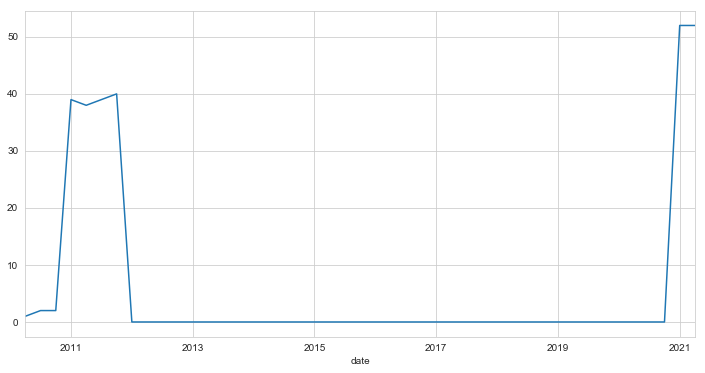

In [77]:
_ = data_tmp[['date', 'company','CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased']].groupby('date').aggregate(lambda x: sum(x.isna()))['CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased'].plot()

Let's forward propogate after 2012 and do backfill before 2012

In [79]:
for c in data_tmp['company'].unique():
    data_tmp.loc[(data_tmp['date'].dt.year>=2012)&(data_tmp['company']==c),
                  'CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased']=\
    data_tmp.loc[(data_tmp['date'].dt.year>=2012)&(data_tmp['company']==c),
                  'CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased'].fillna(method='ffill')

/Users/danilculkov/opt/anaconda3/envs/practice/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [80]:
for c in data_tmp['company'].unique():
    data_tmp.loc[data_tmp['company']==c,'CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased']=\
    data_tmp.loc[data_tmp['company']==c,'CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased'].fillna(method='backfill')

In [81]:
data_tmp['CHANGES TO SHAREHOLDER EQUITY///Net Shares Repurchased'].isna().sum()

0

__CHANGES TO SHAREHOLDER EQUITY///Other__

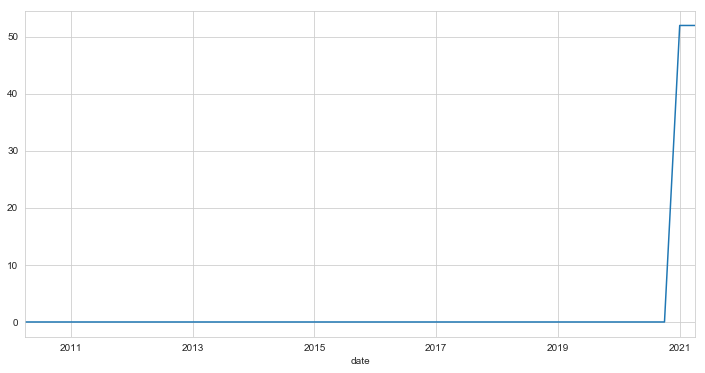

In [82]:
_ = data_tmp[['date', 'company','CHANGES TO SHAREHOLDER EQUITY///Other']].groupby('date').aggregate(lambda x: sum(x.isna()))['CHANGES TO SHAREHOLDER EQUITY///Other'].plot()

Let's forward propagate

In [83]:
for c in data_tmp['company'].unique():
    data_tmp.loc[data_tmp['company']==c,'CHANGES TO SHAREHOLDER EQUITY///Other']=\
    data_tmp.loc[data_tmp['company']==c,'CHANGES TO SHAREHOLDER EQUITY///Other'].fillna(method='ffill')

In [84]:
data_tmp['CHANGES TO SHAREHOLDER EQUITY///Other'].isna().sum()

0

__CHANGES TO SHAREHOLDER EQUITY///Shares Issued__

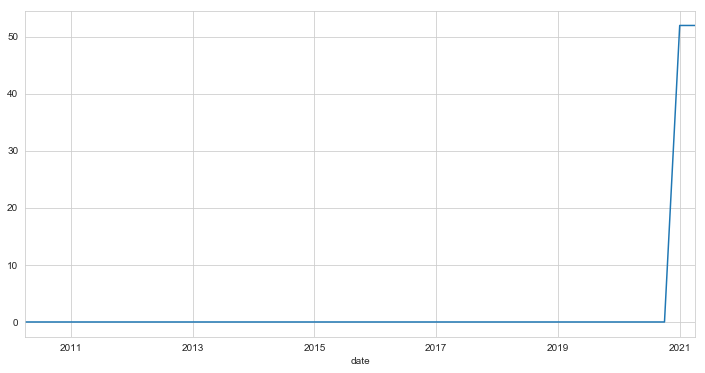

In [85]:
_ = data_tmp[['date', 'company','CHANGES TO SHAREHOLDER EQUITY///Shares Issued']].groupby('date').aggregate(lambda x: sum(x.isna()))['CHANGES TO SHAREHOLDER EQUITY///Shares Issued'].plot()

Let's forward propagate

In [86]:
for c in data_tmp['company'].unique():
    data_tmp.loc[data_tmp['company']==c,'CHANGES TO SHAREHOLDER EQUITY///Shares Issued']=\
    data_tmp.loc[data_tmp['company']==c,'CHANGES TO SHAREHOLDER EQUITY///Shares Issued'].fillna(method='ffill')

In [87]:
data_tmp['CHANGES TO SHAREHOLDER EQUITY///Shares Issued'].isna().sum()

0

__INCOME STATEMENT///Revenue Growth (YoY)__

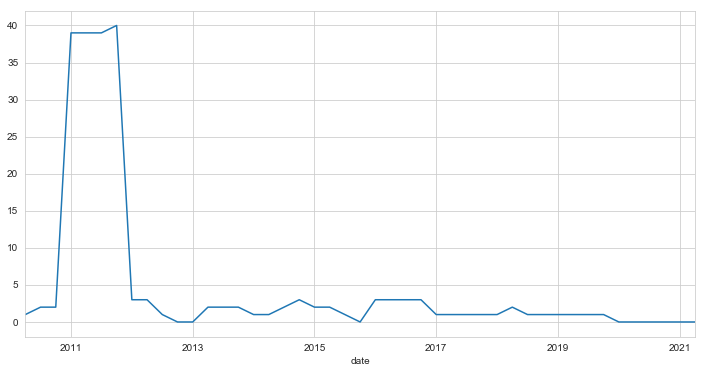

In [88]:
_ = data_tmp[['date', 'company','INCOME STATEMENT///Revenue Growth (YoY)']].groupby('date').aggregate(lambda x: sum(x.isna()))['INCOME STATEMENT///Revenue Growth (YoY)'].plot()

Let's fill in this way:

* Before 2012 with backfill
* Starting from 2012 with mean

In [89]:
for c in data_tmp['company'].unique():
    m = data_tmp.loc[(data_tmp['date'].dt.year>=2012)&(data_tmp['company']==c),
                      'INCOME STATEMENT///Revenue Growth (YoY)'].mean()
    data_tmp.loc[(data_tmp['date'].dt.year>=2012)&(data_tmp['company']==c),
                  'INCOME STATEMENT///Revenue Growth (YoY)']=\
    data_tmp.loc[(data_tmp['date'].dt.year>=2012)&(data_tmp['company']==c),
                  'INCOME STATEMENT///Revenue Growth (YoY)'].fillna(value=m)

In [90]:
for c in data_tmp['company'].unique():
    data_tmp.loc[data_tmp['company']==c,'INCOME STATEMENT///Revenue Growth (YoY)']=\
    data_tmp.loc[data_tmp['company']==c,'INCOME STATEMENT///Revenue Growth (YoY)'].fillna(method='backfill')

In [91]:
data_tmp['CASH FLOW STATEMENT///Free Cash Flow per Share'].isna().sum()

0

__Ratio///CAPEX / EBITDA__

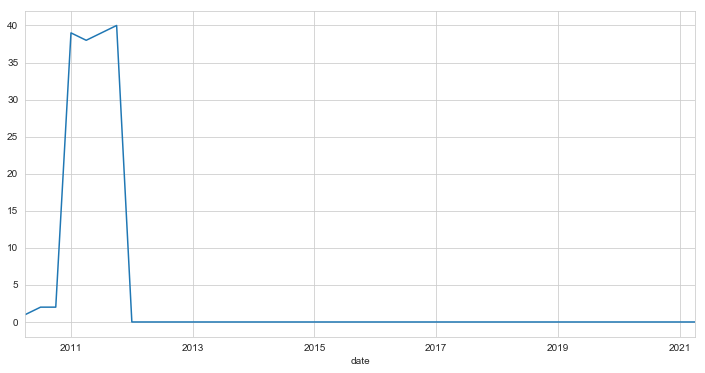

In [92]:
_ = data_tmp[['date', 'company','Ratio///CAPEX / EBITDA']].groupby('date').aggregate(lambda x: sum(x.isna()))['Ratio///CAPEX / EBITDA'].plot()

In [93]:
for c in data_tmp['company'].unique():
    data_tmp.loc[data_tmp['company']==c,'Ratio///CAPEX / EBITDA'] =\
    data_tmp.loc[data_tmp['company']==c,'Ratio///CAPEX / EBITDA'].fillna(method='backfill')

In [94]:
data_tmp['Ratio///CAPEX / EBITDA'].isna().sum()

0

__Ratio///CAPEX / REVENUE__

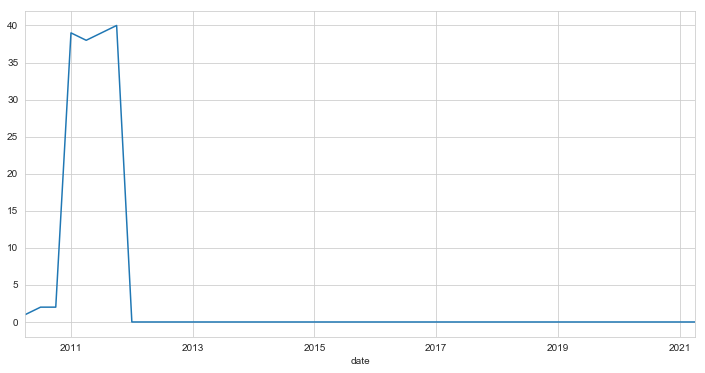

In [95]:
_ = data_tmp[['date', 'company','Ratio///CAPEX / REVENUE']].groupby('date').aggregate(lambda x: sum(x.isna()))['Ratio///CAPEX / REVENUE'].plot()

Let's take the values from the nearest date (backfill)

In [96]:
for c in data_tmp['company'].unique():
    data_tmp.loc[data_tmp['company']==c,'Ratio///CAPEX / REVENUE'] =\
    data_tmp.loc[data_tmp['company']==c,'Ratio///CAPEX / REVENUE'].fillna(method='backfill')

In [97]:
data_tmp['Ratio///CAPEX / REVENUE'].isna().sum()

0

__Ratio///Cash % of Revenue__

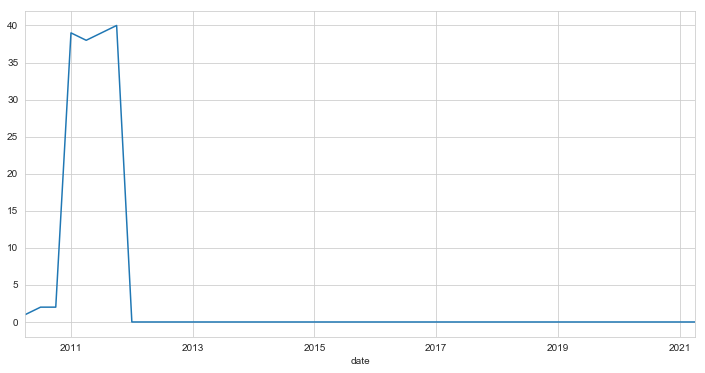

In [98]:
_ = data_tmp[['date', 'company','Ratio///Cash % of Revenue']].groupby('date').aggregate(lambda x: sum(x.isna()))['Ratio///Cash % of Revenue'].plot()

Let's take the values from the nearest date (backfill)

In [99]:
for c in data_tmp['company'].unique():
    data_tmp.loc[data_tmp['company']==c,'Ratio///Cash % of Revenue'] =\
    data_tmp.loc[data_tmp['company']==c,'Ratio///Cash % of Revenue'].fillna(method='backfill')

In [100]:
data_tmp['Ratio///Cash % of Revenue'].isna().sum()

0

__Ratio///Cash + AR / Total Assets__

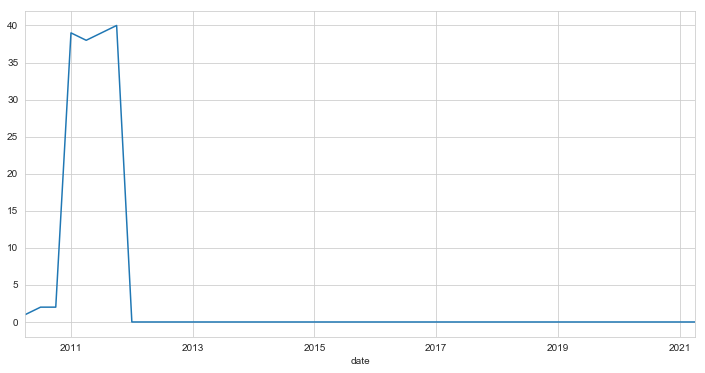

In [101]:
_ = data_tmp[['date', 'company','Ratio///Cash + AR / Total Assets']].groupby('date').aggregate(lambda x: sum(x.isna()))['Ratio///Cash + AR / Total Assets'].plot()

Let's take the values from the nearest date (backfill)

In [102]:
for c in data_tmp['company'].unique():
    data_tmp.loc[data_tmp['company']==c,'Ratio///Cash + AR / Total Assets'] =\
    data_tmp.loc[data_tmp['company']==c,'Ratio///Cash + AR / Total Assets'].fillna(method='backfill')

In [103]:
data_tmp['Ratio///Cash + AR / Total Assets'].isna().sum()

0

__Ratio///FCF / DEBT__

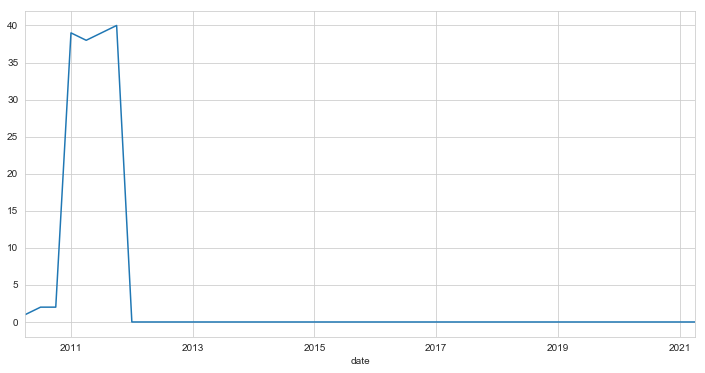

In [104]:
_ = data_tmp[['date', 'company','Ratio///FCF / DEBT']].groupby('date').aggregate(lambda x: sum(x.isna()))['Ratio///FCF / DEBT'].plot()

Let's take the values from the nearest date (backfill)

In [105]:
for c in data_tmp['company'].unique():
    data_tmp.loc[data_tmp['company']==c,'Ratio///FCF / DEBT'] =\
    data_tmp.loc[data_tmp['company']==c,'Ratio///FCF / DEBT'].fillna(method='backfill')

In [106]:
data_tmp['Ratio///FCF / DEBT'].isna().sum()

0

__Ratio///Gross Leverage (Total Debt / EBITDA)__

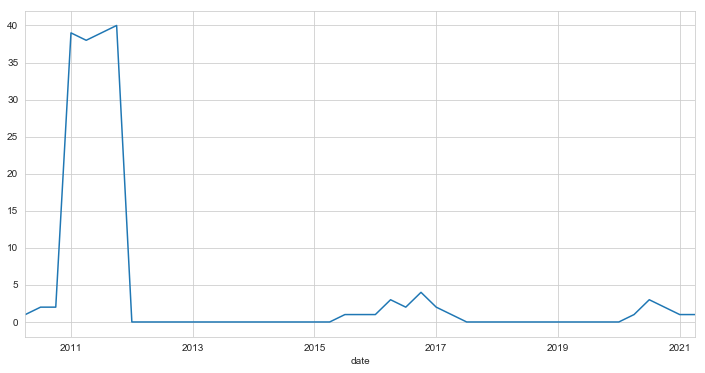

In [107]:
_ = data_tmp[['date', 'company','Ratio///Gross Leverage (Total Debt / EBITDA)']].groupby('date').aggregate(lambda x: sum(x.isna()))['Ratio///Gross Leverage (Total Debt / EBITDA)'].plot()

Let's fill in this way:

* Before 2012 with backfill
* Starting from 2012 with mean

In [108]:
for c in data_tmp['company'].unique():
    m = data_tmp.loc[(data_tmp['date'].dt.year>=2012)&(data_tmp['company']==c),
                      'Ratio///Gross Leverage (Total Debt / EBITDA)'].mean()
    data_tmp.loc[(data_tmp['date'].dt.year>=2012)&(data_tmp['company']==c),
                  'Ratio///Gross Leverage (Total Debt / EBITDA)']=\
    data_tmp.loc[(data_tmp['date'].dt.year>=2012)&(data_tmp['company']==c),
                  'Ratio///Gross Leverage (Total Debt / EBITDA)'].fillna(value=m)

In [109]:
for c in data_tmp['company'].unique():
    data_tmp.loc[data_tmp['company']==c,'Ratio///Gross Leverage (Total Debt / EBITDA)']=\
    data_tmp.loc[data_tmp['company']==c,'Ratio///Gross Leverage (Total Debt / EBITDA)'].fillna(method='backfill')

In [110]:
data_tmp['Ratio///Gross Leverage (Total Debt / EBITDA)'].isna().sum()

0

__Ratio///Total Liabilities / Tangible Assets__

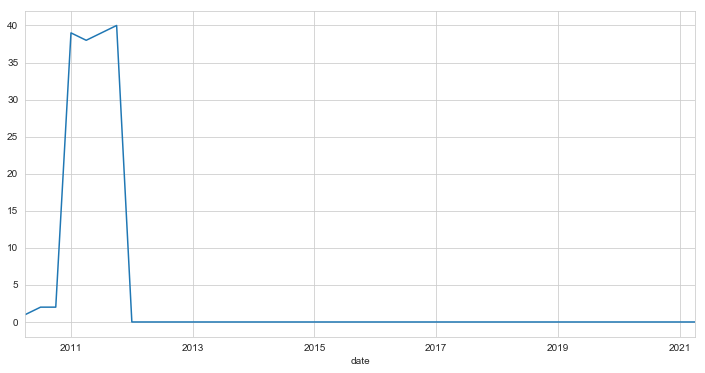

In [111]:
_ = data_tmp[['date', 'company','Ratio///Total Liabilities / Tangible Assets']].groupby('date').aggregate(lambda x: sum(x.isna()))['Ratio///Total Liabilities / Tangible Assets'].plot()

Let's take the values from the nearest date (backfill)

In [112]:
for c in data_tmp['company'].unique():
    data_tmp.loc[data_tmp['company']==c,'Ratio///Total Liabilities / Tangible Assets'] =\
    data_tmp.loc[data_tmp['company']==c,'Ratio///Total Liabilities / Tangible Assets'].fillna(method='backfill')

In [113]:
data_tmp['Ratio///Total Liabilities / Tangible Assets'].isna().sum()

0

__RESULT__

In [114]:
data_tmp.isna().sum().sum()

0

We have zero na values left!!!

In [117]:
data_tmp

date company  INCOME STATEMENT///Revenue  \
23   2016-03-31    CDEV                      23.750   
24   2016-06-30    CDEV                      29.390   
25   2016-09-30    CDEV                      29.273   
26   2016-12-31    CDEV                      30.771   
27   2017-03-31    CDEV                      60.700   
...         ...     ...                         ...   
2335 2020-06-30     MCF                      17.842   
2336 2020-09-30     MCF                      31.348   
2337 2020-12-31     MCF                      29.157   
2338 2021-03-31     MCF                      59.950   
2339 2021-06-30     MCF                      83.640   

      INCOME STATEMENT///% Surprise | % Est. vs Consensus  \
23                                             0.000000     
24                                             0.000000     
25                                             0.121571     
26                                            -0.000942     
27                                             0.126160     
...                                                 ...     
2335                                           0.000000     
2336                                           0.000000     
2337                                           0.000000     
2338                                          -0.054416     
2339                                           0.213933     

      INCOME STATEMENT///Revenue Growth (YoY)  \
23                                   0.893269   
24                                   0.893269   
25                                   0.893269   
26                                   0.893269   
27                                   1.555789   
...                                       ...   
2335                                 0.398057   
2336                                 1.498446   
2337                                -0.216062   
2338                                 0.734012   
2339                                 3.687815   

      INCOME STATEMENT///Gross margin  \
23                          -0.150274   
24                           0.098843   
25                           0.134732   
26                           0.277209   
27                           0.310231   
...                               ...   
2335                        -0.245993   
2336                         0.255455   
2337                         0.212127   
2338                         0.389141   
2339                         0.426518   

      INCOME STATEMENT///Other Operating Expenses  \
23                                          0.000   
24                                         -0.242   
25                                         -0.871   
26                                          3.253   
27                                          0.887   
...                                           ...   
2335                                      -11.173   
2336                                        0.643   
2337                                        0.613   
2338                                        1.650   
2339                                        0.313   

      INCOME STATEMENT///Operating Income  \
23                                 -6.105   
24                                  0.056   
25                                 -1.775   
26                                 -1.932   
27                                  7.653   
...                                   ...   
2335                              -21.275   
2336                                2.521   
2337                               -0.874   
2338                               13.620   
2339                               22.504   

      INCOME STATEMENT///Operating Margin  \
23                              -0.257053   
24                               0.001905   
25                              -0.060636   
26                              -0.062786   
27                               0.126079   
...                                   ...   
2335                            -1.192411 

In [118]:
data_tmp.reset_index(drop=True, inplace=True)

In [119]:
data_tmp.to_excel('data/data_train_test.xlsx')

In [127]:
sorted(data_tmp['date'].unique())

[numpy.datetime64('2010-06-30T00:00:00.000000000'),
 numpy.datetime64('2010-09-30T00:00:00.000000000'),
 numpy.datetime64('2010-12-31T00:00:00.000000000'),
 numpy.datetime64('2011-03-31T00:00:00.000000000'),
 numpy.datetime64('2011-06-30T00:00:00.000000000'),
 numpy.datetime64('2011-09-30T00:00:00.000000000'),
 numpy.datetime64('2011-12-31T00:00:00.000000000'),
 numpy.datetime64('2012-03-31T00:00:00.000000000'),
 numpy.datetime64('2012-06-30T00:00:00.000000000'),
 numpy.datetime64('2012-09-30T00:00:00.000000000'),
 numpy.datetime64('2012-12-31T00:00:00.000000000'),
 numpy.datetime64('2013-03-31T00:00:00.000000000'),
 numpy.datetime64('2013-06-30T00:00:00.000000000'),
 numpy.datetime64('2013-09-30T00:00:00.000000000'),
 numpy.datetime64('2013-12-31T00:00:00.000000000'),
 numpy.datetime64('2014-03-31T00:00:00.000000000'),
 numpy.datetime64('2014-06-30T00:00:00.000000000'),
 numpy.datetime64('2014-09-30T00:00:00.000000000'),
 numpy.datetime64('2014-12-31T00:00:00.000000000'),
 numpy.datet

In [123]:
data_train = pd.read_excel('data/data_tmp4.xlsx', index_col=0)

In [128]:
sorted(data_train['date'].unique())

[numpy.datetime64('2009-06-30T00:00:00.000000000'),
 numpy.datetime64('2009-09-30T00:00:00.000000000'),
 numpy.datetime64('2009-12-31T00:00:00.000000000'),
 numpy.datetime64('2010-03-31T00:00:00.000000000'),
 numpy.datetime64('2010-06-30T00:00:00.000000000'),
 numpy.datetime64('2010-09-30T00:00:00.000000000'),
 numpy.datetime64('2010-12-31T00:00:00.000000000'),
 numpy.datetime64('2011-03-31T00:00:00.000000000'),
 numpy.datetime64('2011-06-30T00:00:00.000000000'),
 numpy.datetime64('2011-09-30T00:00:00.000000000'),
 numpy.datetime64('2011-12-31T00:00:00.000000000'),
 numpy.datetime64('2012-03-31T00:00:00.000000000'),
 numpy.datetime64('2012-06-30T00:00:00.000000000'),
 numpy.datetime64('2012-09-30T00:00:00.000000000'),
 numpy.datetime64('2012-12-31T00:00:00.000000000'),
 numpy.datetime64('2013-03-31T00:00:00.000000000'),
 numpy.datetime64('2013-06-30T00:00:00.000000000'),
 numpy.datetime64('2013-09-30T00:00:00.000000000'),
 numpy.datetime64('2013-12-31T00:00:00.000000000'),
 numpy.datet

We have 4 date to make predictions